1. Исследовательский анализ данных (EDA)

Цель этапа:
Провести первичный анализ анкетных данных студентов, выявить структуру, качество и основные закономерности в данных.
Задачи:
Определить распределение по факультетам
Найти пропуски
Выделить бинарные признаки
Проанализировать их баланс и связи
Оценить связь бинарных признаков с факультетом

In [1]:
# 1.1 Импорт библиотек и загрузка данных

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap
import numpy as np
import re
from scipy.stats import chi2_contingency

INPUT_PATH = "../data/dlia_studentov.xlsx"
OUTPUT_DIR = "../outputs/eda_students"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def short_label(label, max_len=40):
    label = str(label)
    return textwrap.shorten(label, width=max_len, placeholder="...")

def safe_filename(label, max_len=40):
    label = str(label)
    label = re.sub(r'[^A-Za-zА-Яа-я0-9_]+', '_', label)
    return label[:max_len]

print("[1] Загрузка данных...")
df = pd.read_excel(INPUT_PATH)
print(f"Строк: {df.shape[0]}, Столбцов: {df.shape[1]}")
display(df.head())

[1] Загрузка данных...
Строк: 711, Столбцов: 23


ID       Время создания  \
0  1408291245  2023-06-07 20:41:17   
1  1405883214  2023-06-05 09:02:21   
2  1405869646  2023-06-05 08:44:38   
3  1405856131  2023-06-05 08:26:39   
4  1405854542  2023-06-05 08:24:47   

  На каком факультете/в каком институте Вы обучаетесь?  \
0                 институт истории и социальных наук     
1                                институт педагогики     
2                                институт педагогики     
3                                институт педагогики     
4                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

  Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                нет                                                                             
1                                                 да                                                                             
2                                                 да                                                                             
3                                                 да                                                                             
4                                                 да                                                                             

  Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                нет                                                                                           
1                                                 да                                                                                           
2                                                 да                                                                                           
3                                                 да                                                                                           
4                                                 да                                                                                           

  Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                нет                                                  
1                                                нет                                                  
2                                                 да                                                  
3                                                нет                                                  
4                                                нет                                                  

  Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                нет                                                                             
1                                                 да                                                                             
2                                                 да                                                                             
3                                                нет                         

1.2 Приведение строковых чисел к числовым типам

In [2]:
# Преобразуем строки-числа в числовой формат (если возможно)
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = pd.to_numeric(df[col])
        except Exception:
            pass

1.3 Анализ распределения по факультетам


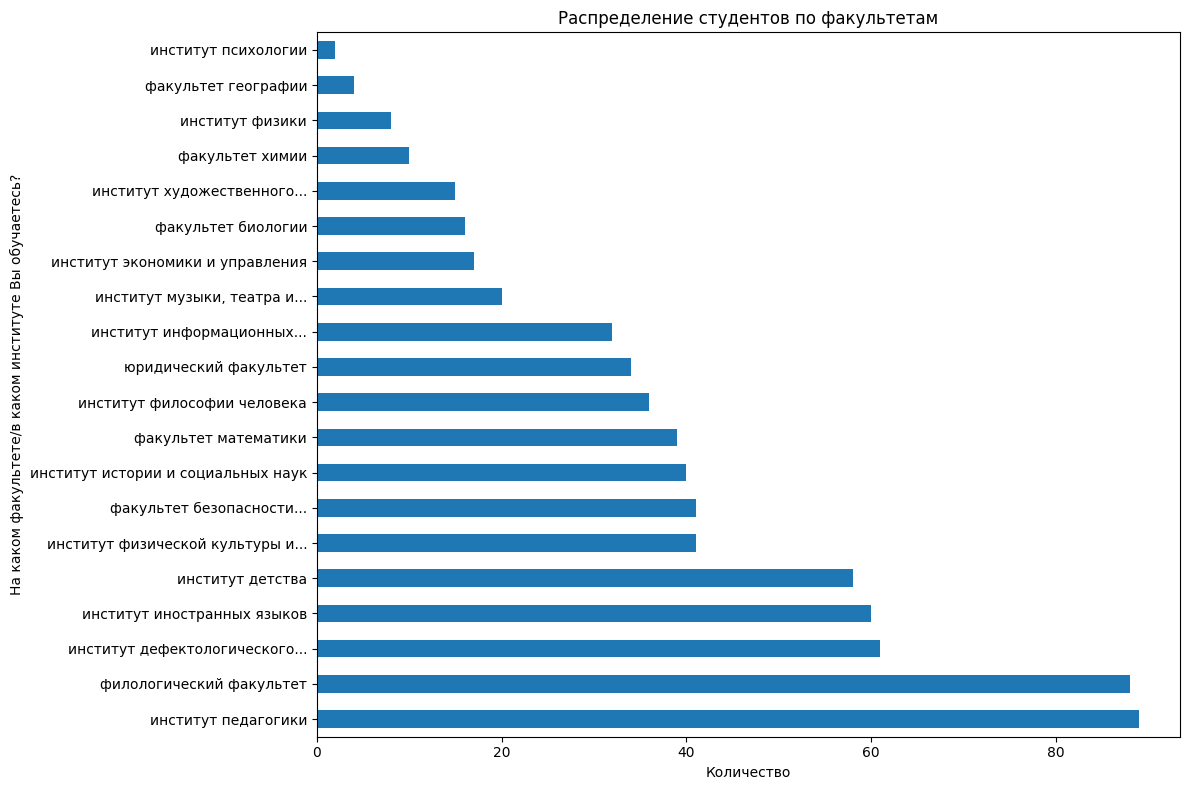

In [3]:
# Поиск столбца с факультетом
faculty_cols = [col for col in df.columns if "институт" in col.lower() or "факультет" in col.lower()]
if faculty_cols:
    faculty_col = faculty_cols[0]
    plt.figure(figsize=(12, 8))
    ax = df[faculty_col].value_counts().plot(kind="barh")
    ax.set_yticklabels([short_label(x, 35) for x in df[faculty_col].value_counts().index], fontsize=10)
    plt.title("Распределение студентов по факультетам")
    plt.xlabel("Количество")
    plt.tight_layout()
    plt.show()
else:
    print("Столбец факультета не найден.")

1.4 Анализ пропусков


In [4]:
missing = df.isnull().mean().sort_values(ascending=False)
missing_to_plot = missing[missing > 0]
if not missing_to_plot.empty:
    plt.figure(figsize=(10, 6))
    ax = missing_to_plot.plot(kind="barh", title="Доля пропусков по признакам")
    ax.set_yticklabels([short_label(x, 40) for x in missing_to_plot.index], fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("Нет признаков с пропусками.")

Нет признаков с пропусками.


1.5 Поиск бинарных признаков и их анализ


In [5]:
binary_map = {
    "использую": 1, "не использую": 0,
    "использовать": 1, "не использовать": 0,
    "да": 1, "нет": 0,
    "Да": 1, "Нет": 0,
    "yes": 1, "no": 0,
    "Yes": 1, "No": 0,
    1: 1, 0: 0,
    "1": 1, "0": 0,
}
binary_cols = []
for col in df.columns:
    vals = df[col].dropna().unique()
    if all(str(x).strip().lower() in binary_map for x in vals):
        df[col] = df[col].map(lambda x: binary_map.get(str(x).strip().lower(), pd.NA)).astype(float)
        binary_cols.append(col)

print(f"Найдено бинарных признаков: {len(binary_cols)}")

Найдено бинарных признаков: 19


1.5.1 Доля единиц в бинарных признаках

In [6]:
bin_stats = []
for col in binary_cols:
    counts = df[col].value_counts(dropna=False)
    ones = counts.get(1, 0)
    zeros = counts.get(0, 0)
    total = ones + zeros
    frac_ones = ones / total if total > 0 else 0
    bin_stats.append({"feature": col, "frac_ones": frac_ones, "ones": ones, "zeros": zeros, "total": total})
bin_stats_df = pd.DataFrame(bin_stats)
bin_stats_df["min_frac"] = bin_stats_df["frac_ones"].combine(1 - bin_stats_df["frac_ones"], min)
display(bin_stats_df.sort_values("frac_ones"))

feature  frac_ones  ones  zeros  \
3   Необходим ли автоматический мониторинг присутс...   0.502110   357    354   
2   Был ли автоматический мониторинг присутствия с...   0.528833   376    335   
13  Была ли предусмотрена рефлексия (отзыв) после ...   0.645570   459    252   
15  Была ли предусмотрена рефлексия (отзыв) после ...   0.652602   464    247   
14  Необходима ли рефлексия (отзыв) после выполнен...   0.658228   468    243   
17  Было ли организовано взаимодействие с преподав...   0.738397   525    186   
16  Необходима ли рефлексия (отзыв) после завершен...   0.746835   531    180   
6   Были ли для каждого Практического задания разр...   0.776371   552    159   
8   Был ли встроенный электронный журнал прогресса...   0.793249   564    147   
11  Необходимо ли встраивать в электронный курс ви...   0.807314   574    137   
0   Был ли предусмотрен фидбек (отклик преподавате...   0.850914   605    106   
18  Необходимо ли организовывать взаимодействие с ...   0.870605   619     92   
5   Необходимо ли представлять материалы для практ...   0.880450   626     85   
12  Были ли встроенные в электронный курс тесты по...   0.890295   633     78   
7   Необходимы ли для каждого Практического задани...   0.904360   643     68   
4   Материалы, представленные для практического за...   0.914205   650     61   
9   Необходим ли встроенный электронный журнал про...   0.917018   652     59   
1   Необходим ли фидбек (отклик преподавателя на в...   0.931083   662     49   
10  Были ли встроенны в электронный курс видеолекции?   0.938115   667     44   

    total  min_frac  
3     711  0.497890  
2     711  0.471167  
13    711  0.354430  
15    711  0.347398  
14    711  0.341772  
17    711  0.261603  
16    711  0.253165  
6     711  0.223629  
8     711  0.206751  
11    711  0.192686  
0     711  0.149086  
18    711  0.129395  
5     711  0.119550  
12    711  0.109705  
7     711  0.095640  
4     711  0.085795  
9     711  0.082982  
1     711  0.068917  
10    711  0.061885

1.5.2 Признаки с низкой информативностью

In [7]:
uninformative = bin_stats_df[(bin_stats_df["frac_ones"] < 0.05) | (bin_stats_df["frac_ones"] > 0.95)]
print("Малоинформативные бинарные признаки (перекос):")
display(uninformative)

Малоинформативные бинарные признаки (перекос):


Empty DataFrame
Columns: [feature, frac_ones, ones, zeros, total, min_frac]
Index: []

1.6 Boxplot и корреляции бинарных признаков

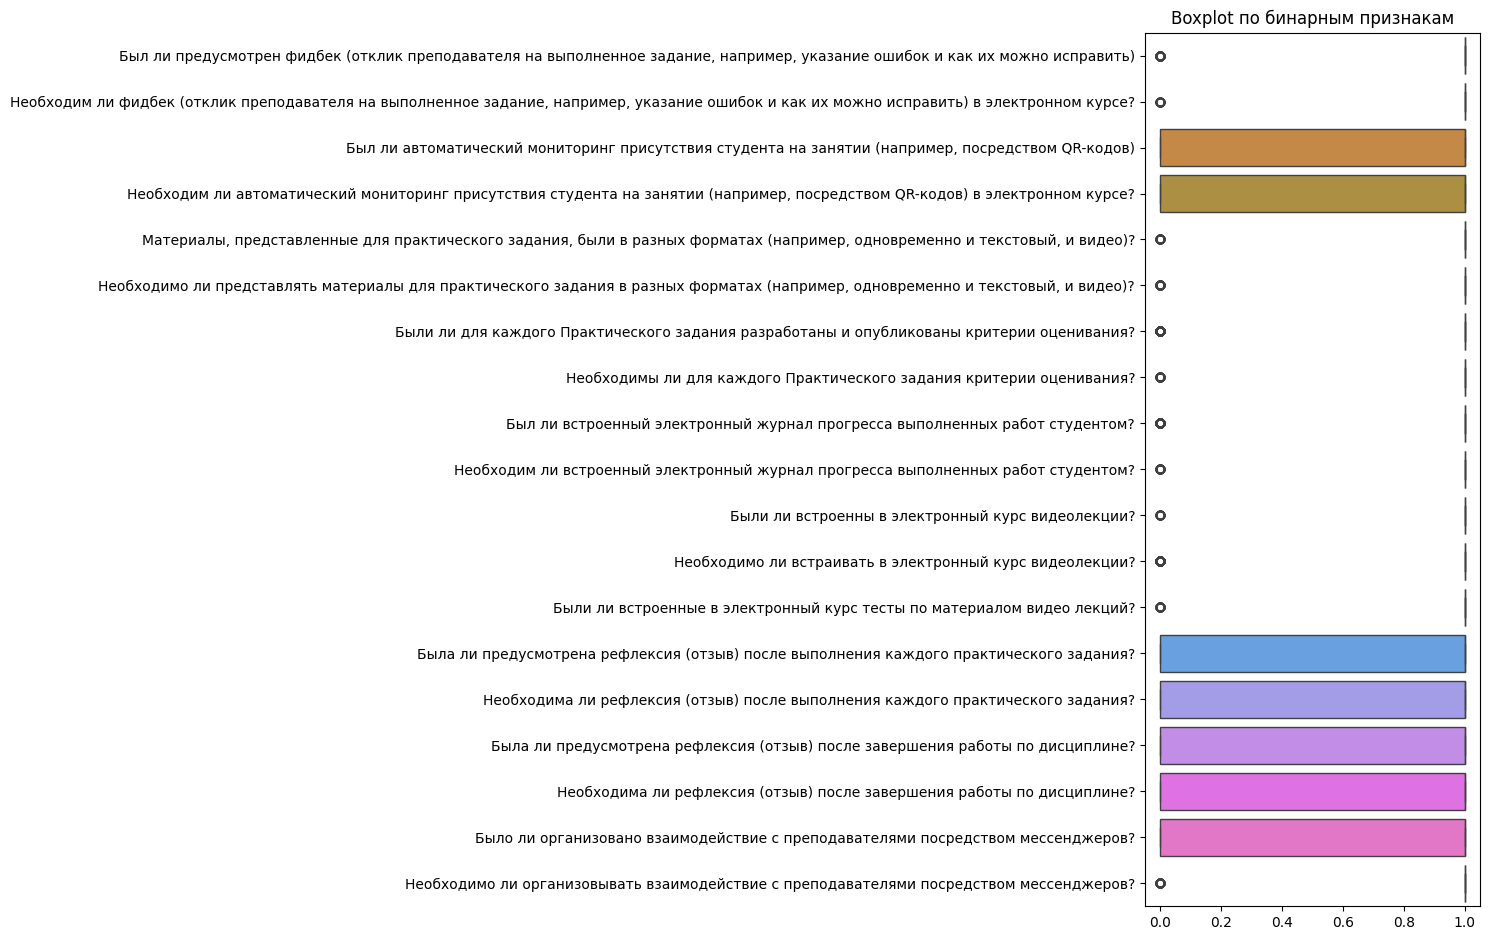

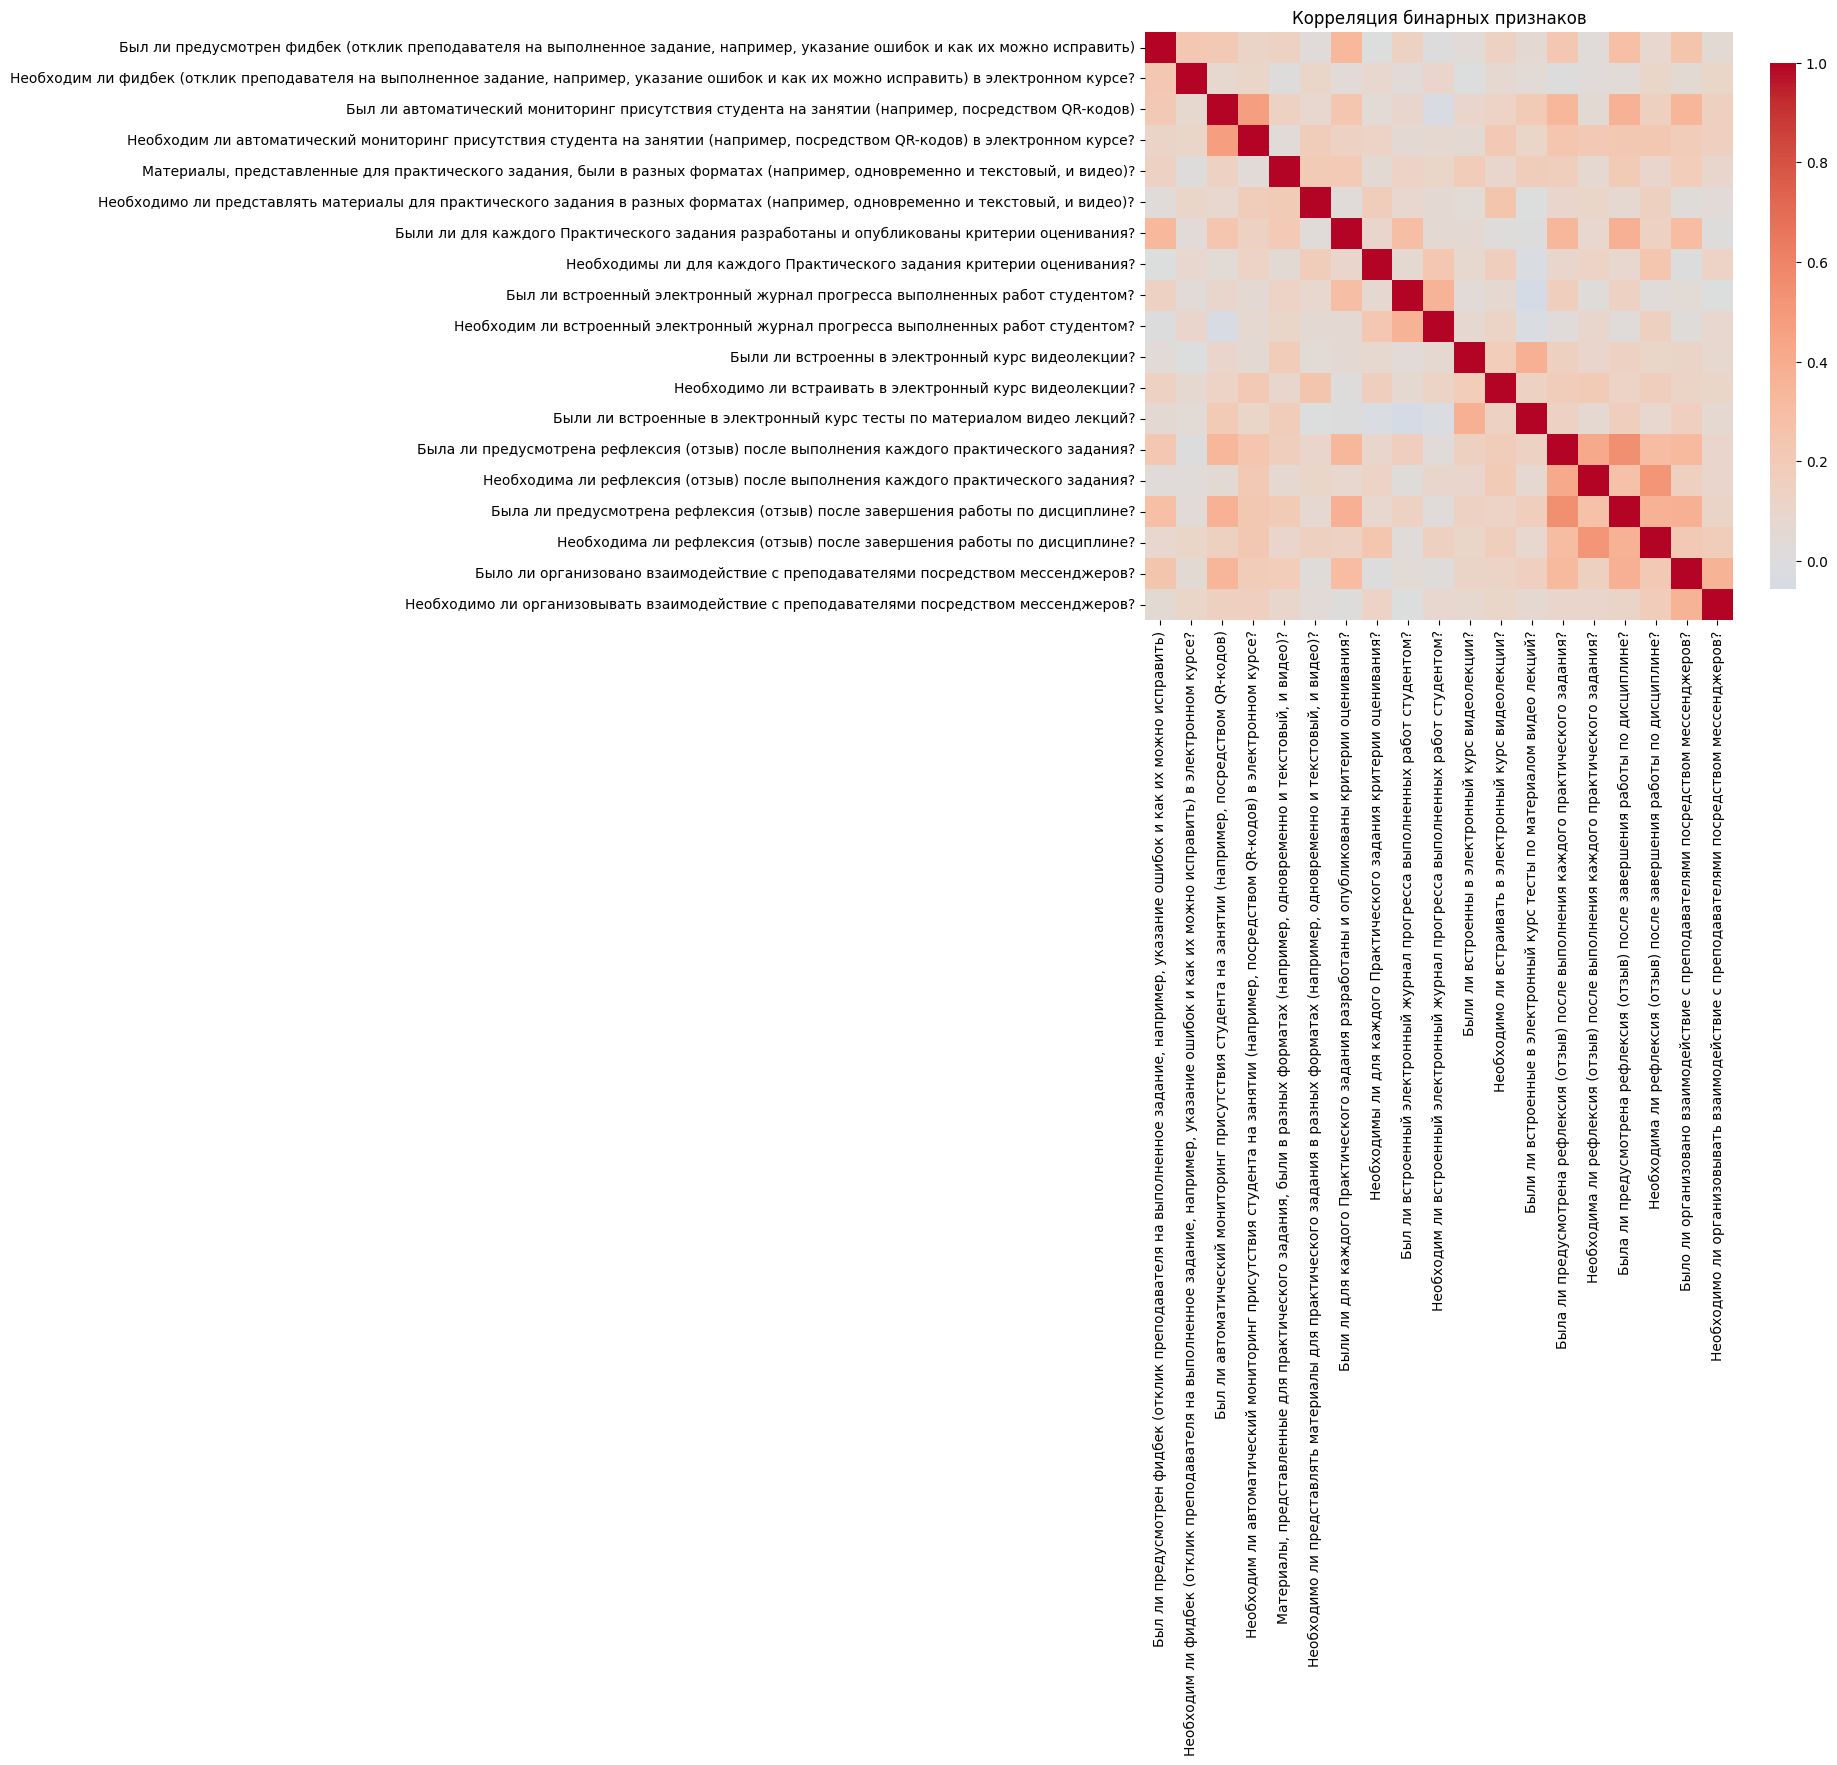

Топ-10 пар бинарных признаков по корреляции:


Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?            Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?                                                  0.546237
Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?                    Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?                                                          0.521571
Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?    0.468896
Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?            Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?                                                 0.414563
Были ли для каждого Практического задания разработаны и 

In [8]:
if binary_cols:
    # Boxplot
    plt.figure(figsize=(15, max(8, len(binary_cols) * 0.5)))
    sns.boxplot(data=df[binary_cols], orient="h")
    plt.title("Boxplot по бинарным признакам")
    plt.tight_layout()
    plt.show()

    # Heatmap корреляции
    corr = df[binary_cols].corr()
    plt.figure(figsize=(max(10, len(binary_cols)), max(8, len(binary_cols))))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.6}, annot=len(binary_cols)<15)
    plt.title("Корреляция бинарных признаков")
    plt.tight_layout()
    plt.show()

    # Топ-10 по модулю корреляции
    corr_stack = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool)).stack()
    top_corr = corr_stack.abs().sort_values(ascending=False).head(10)
    print("Топ-10 пар бинарных признаков по корреляции:")
    display(top_corr)

1.7 Парные распределения топ-5 сбалансированных бинарных признаков

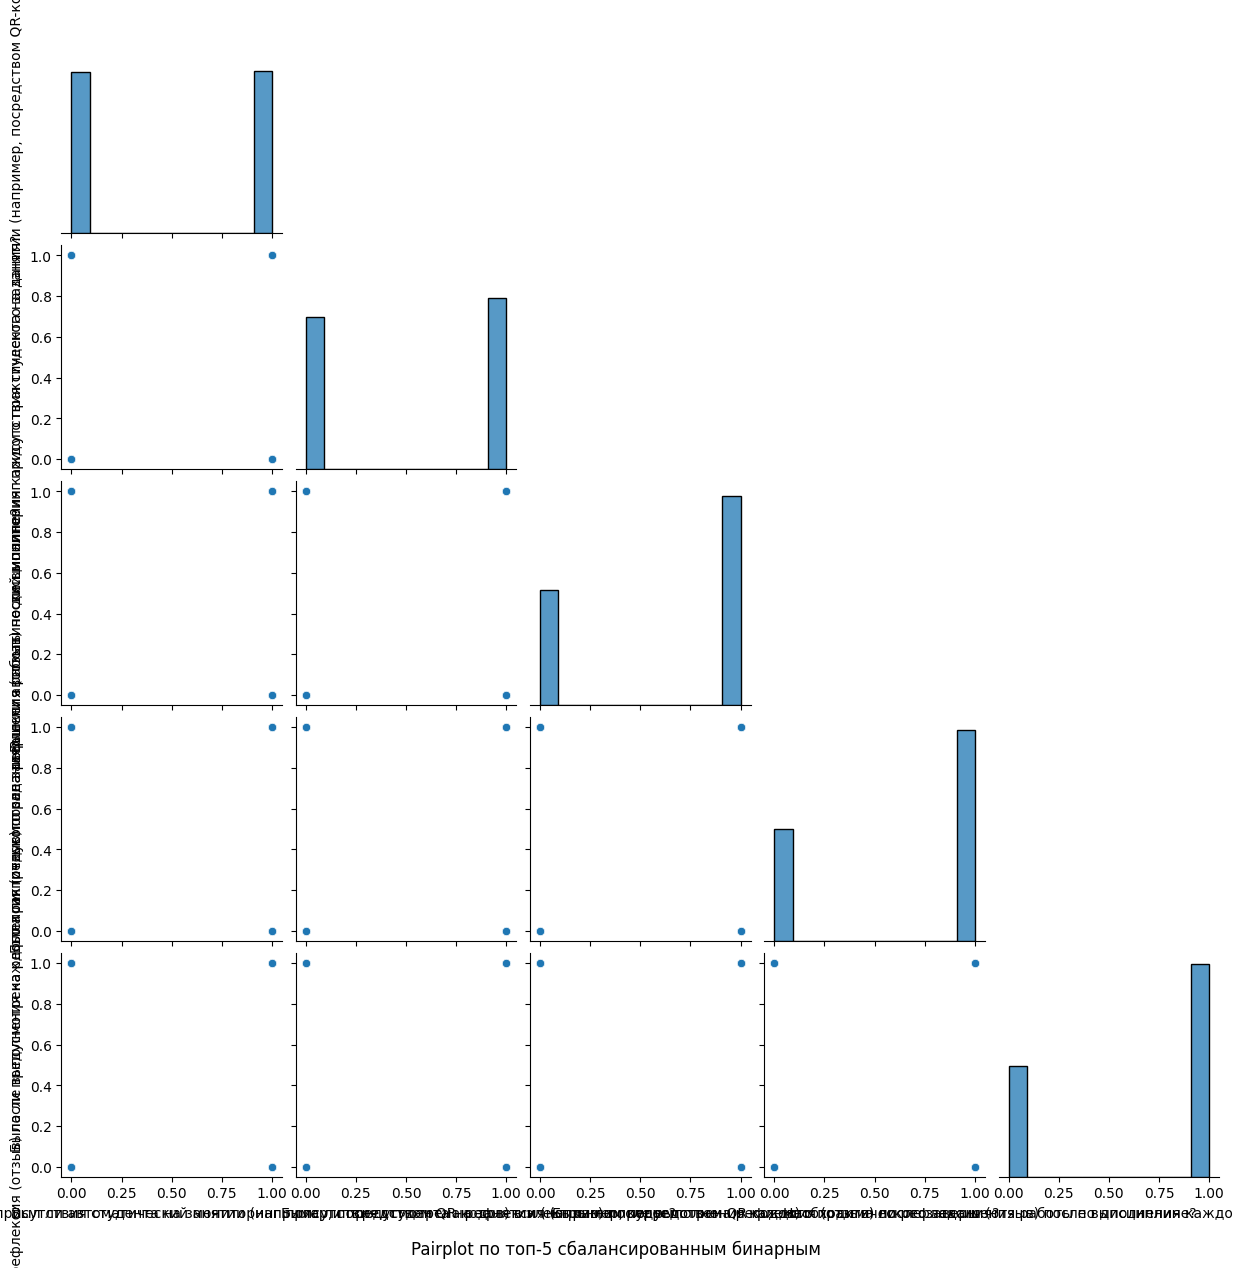

In [9]:
top5 = bin_stats_df.sort_values("min_frac", ascending=False).head(5)["feature"].tolist()
if len(top5) >= 2:
    sns.pairplot(df[top5].dropna(), kind="scatter", corner=True)
    plt.suptitle("Pairplot по топ-5 сбалансированным бинарным", y=0.0001) #y=1.01
    plt.show()

1.8 Связь факультета и бинарных признаков (Cramér's V)

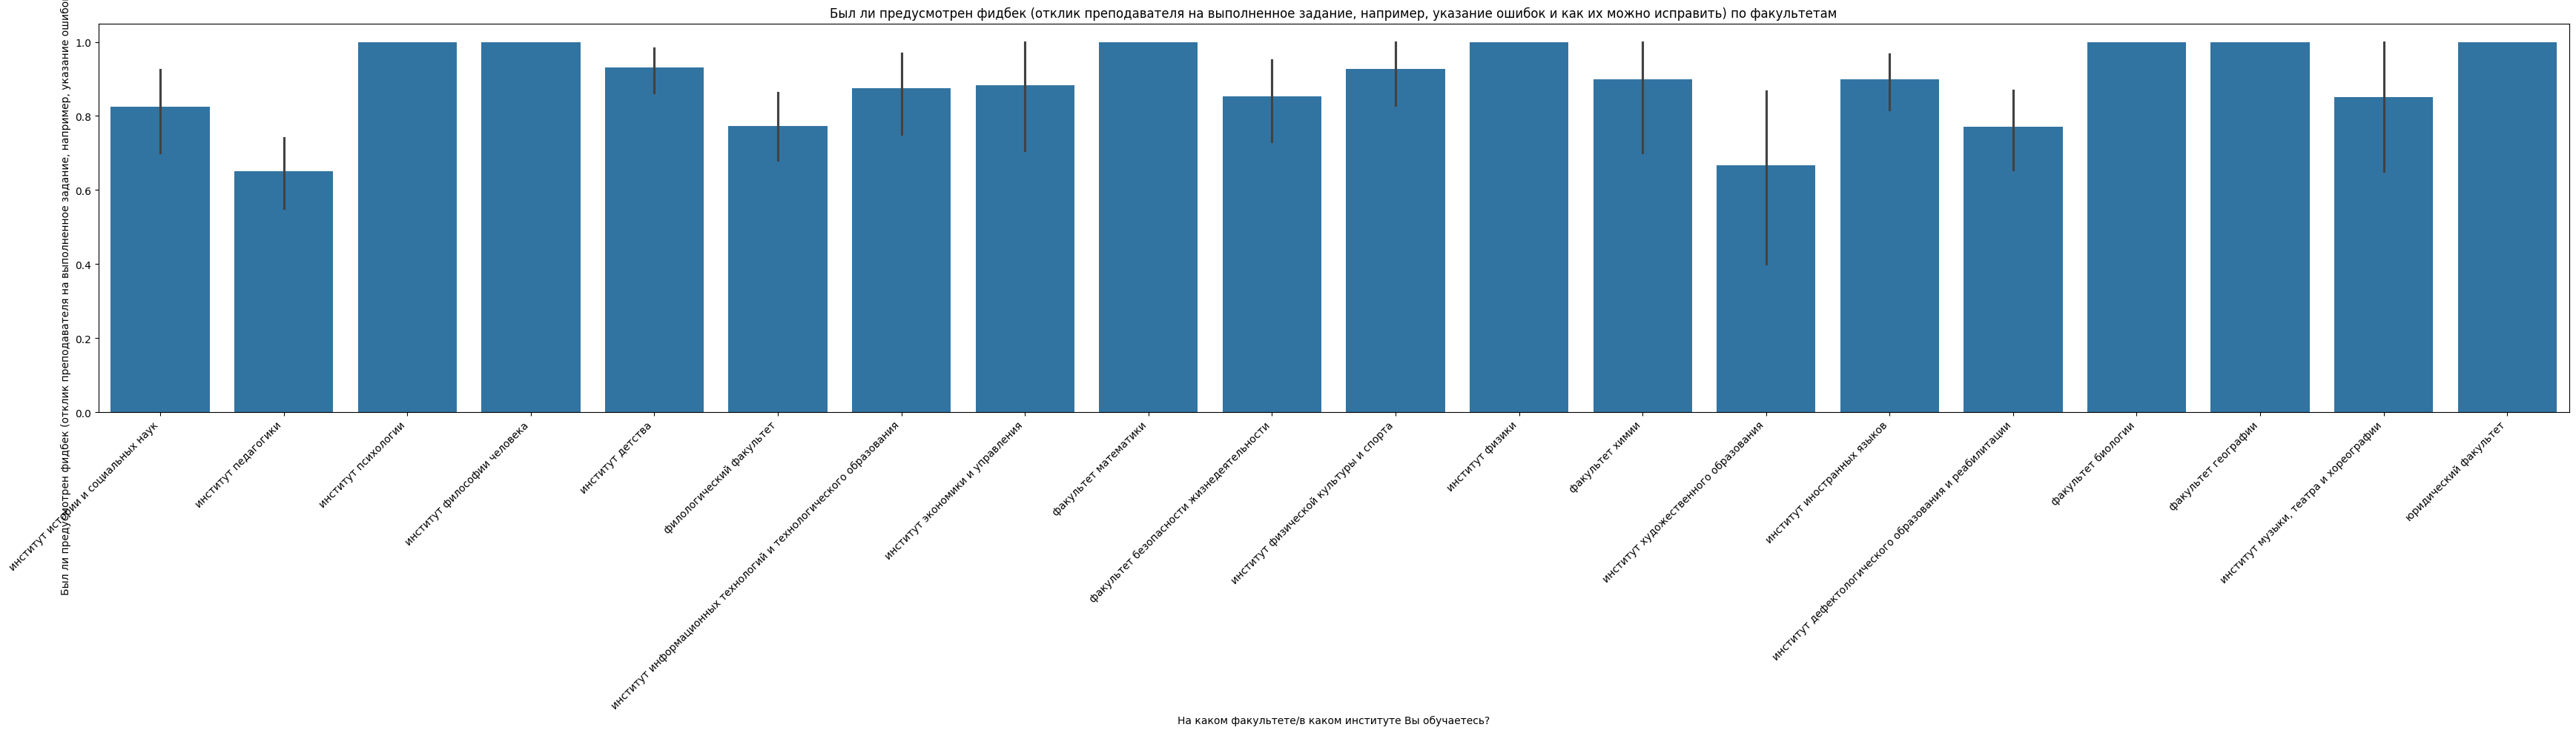

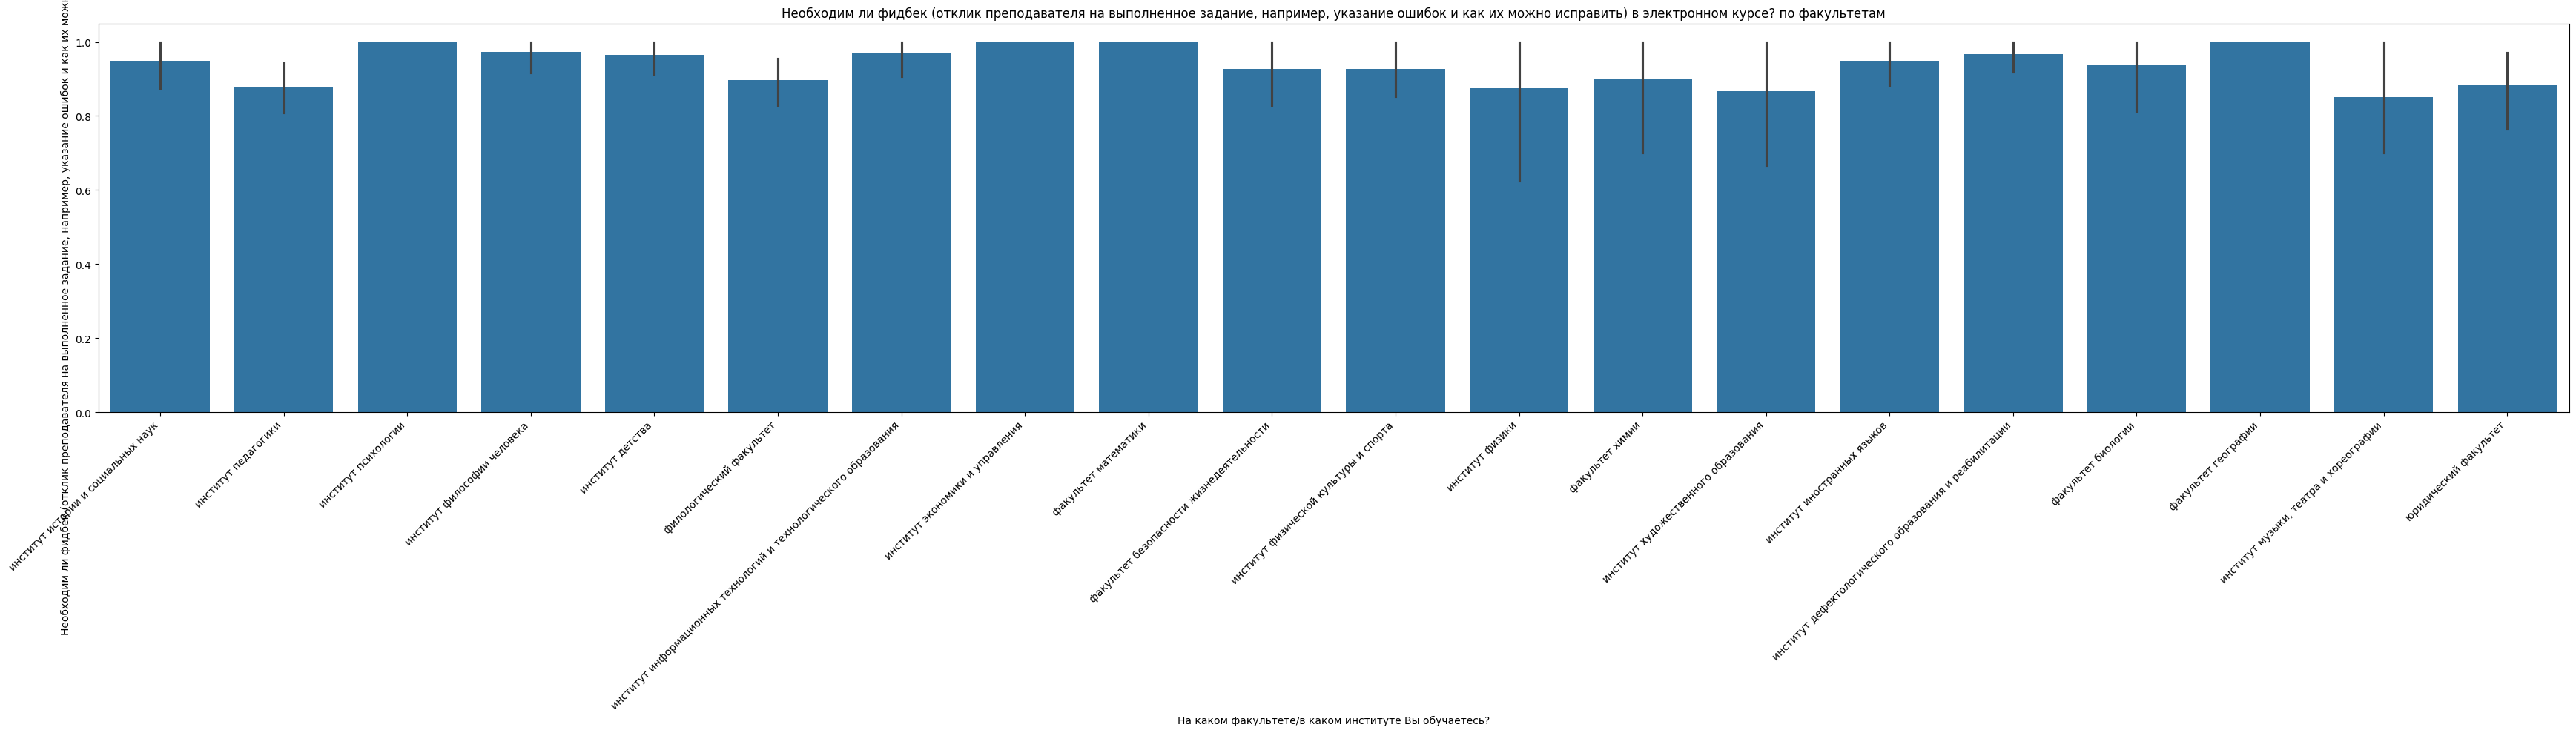

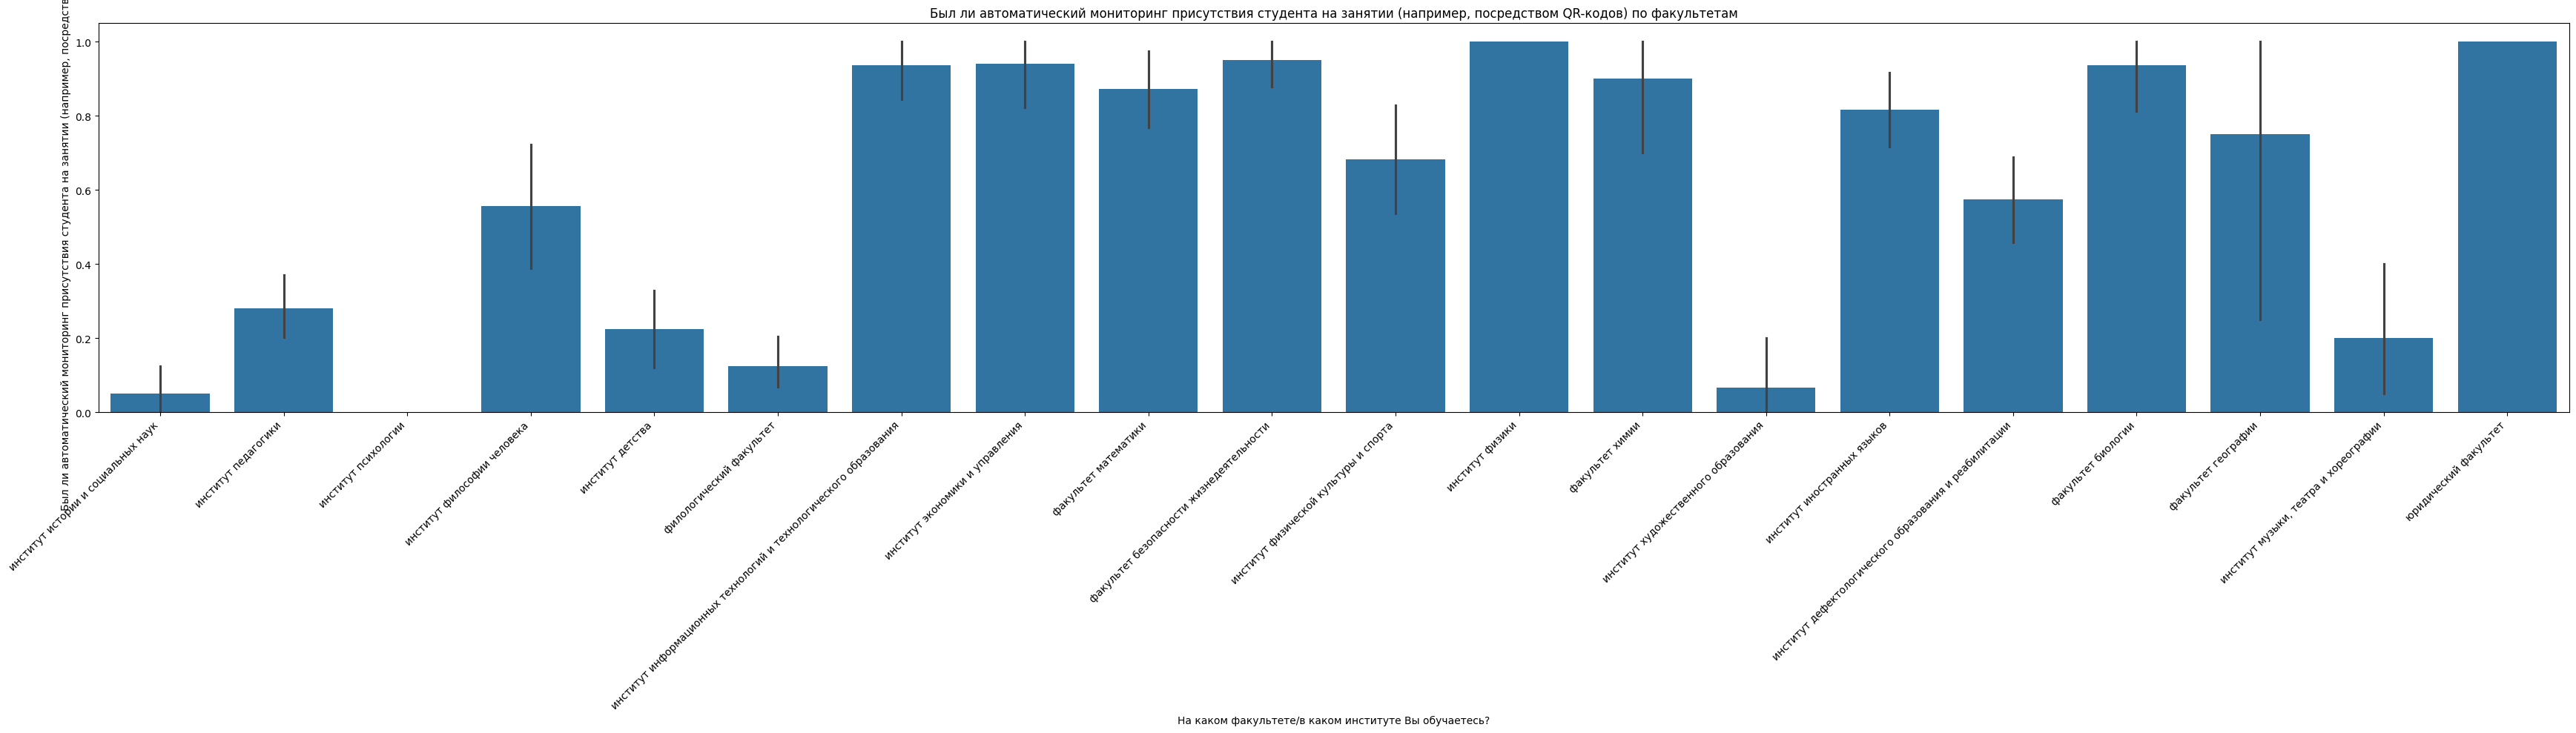

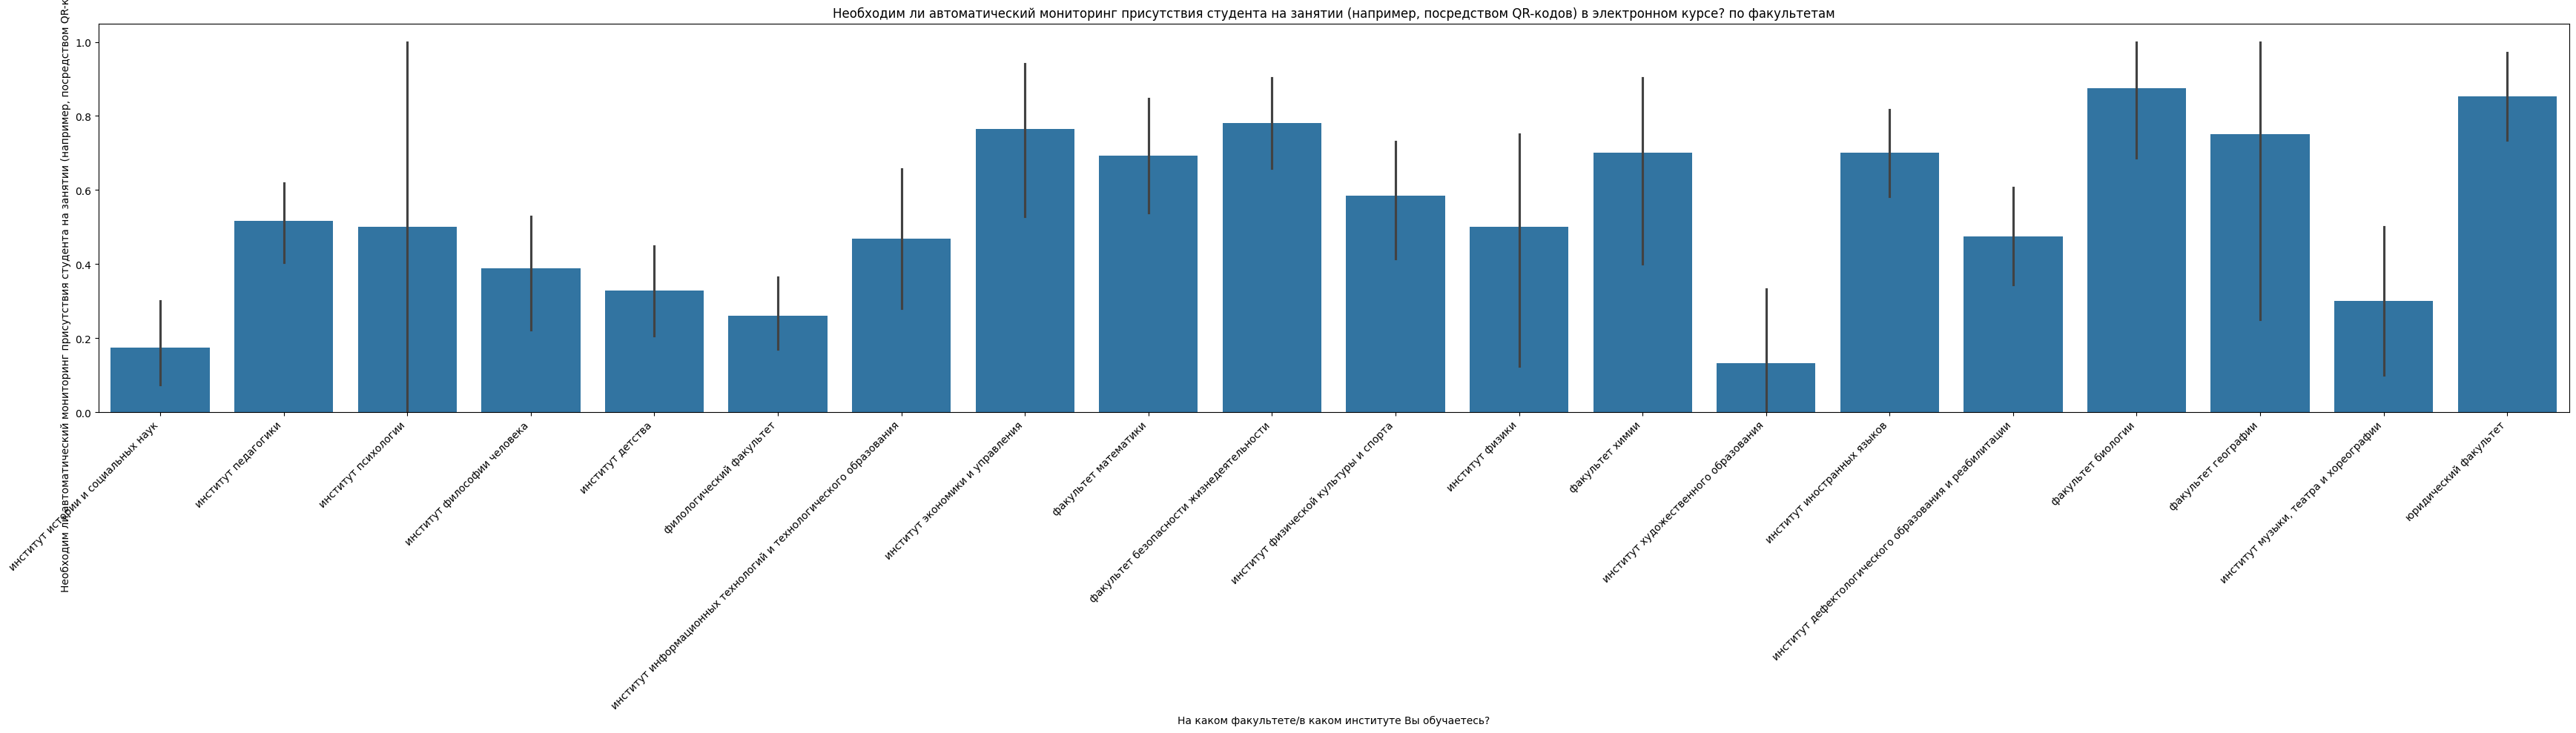

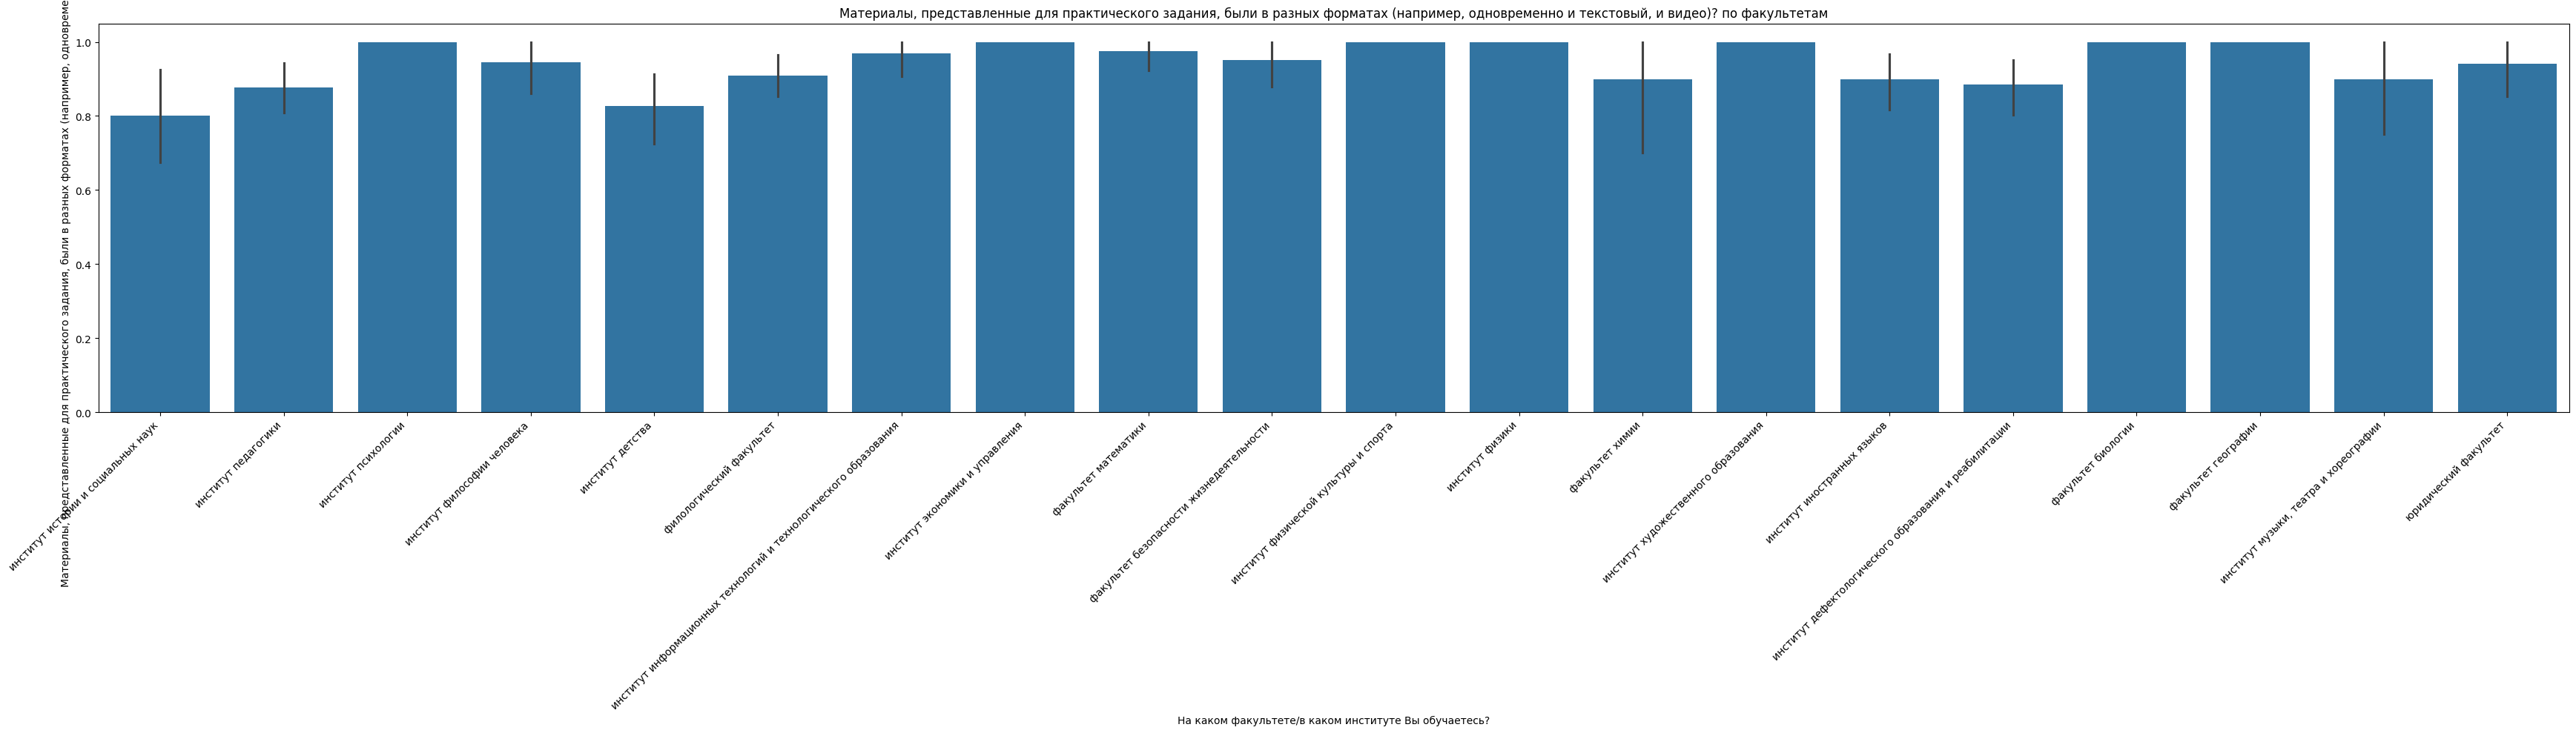

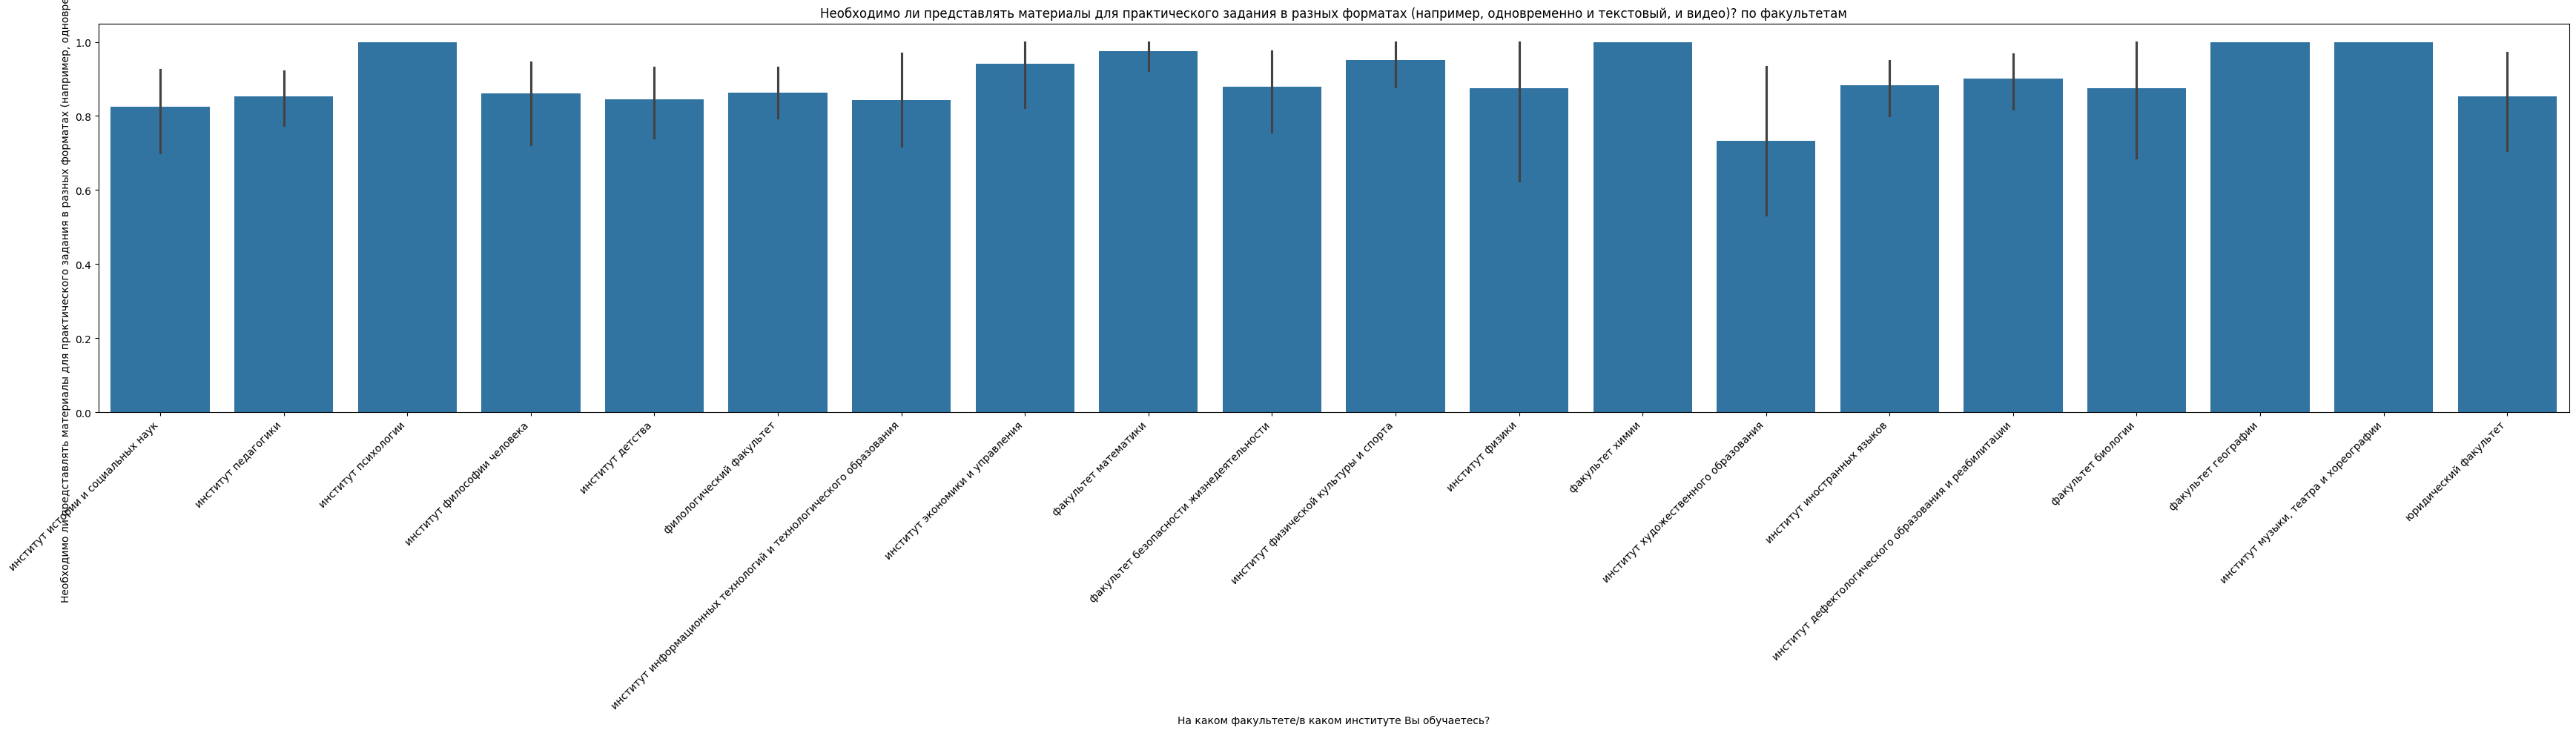

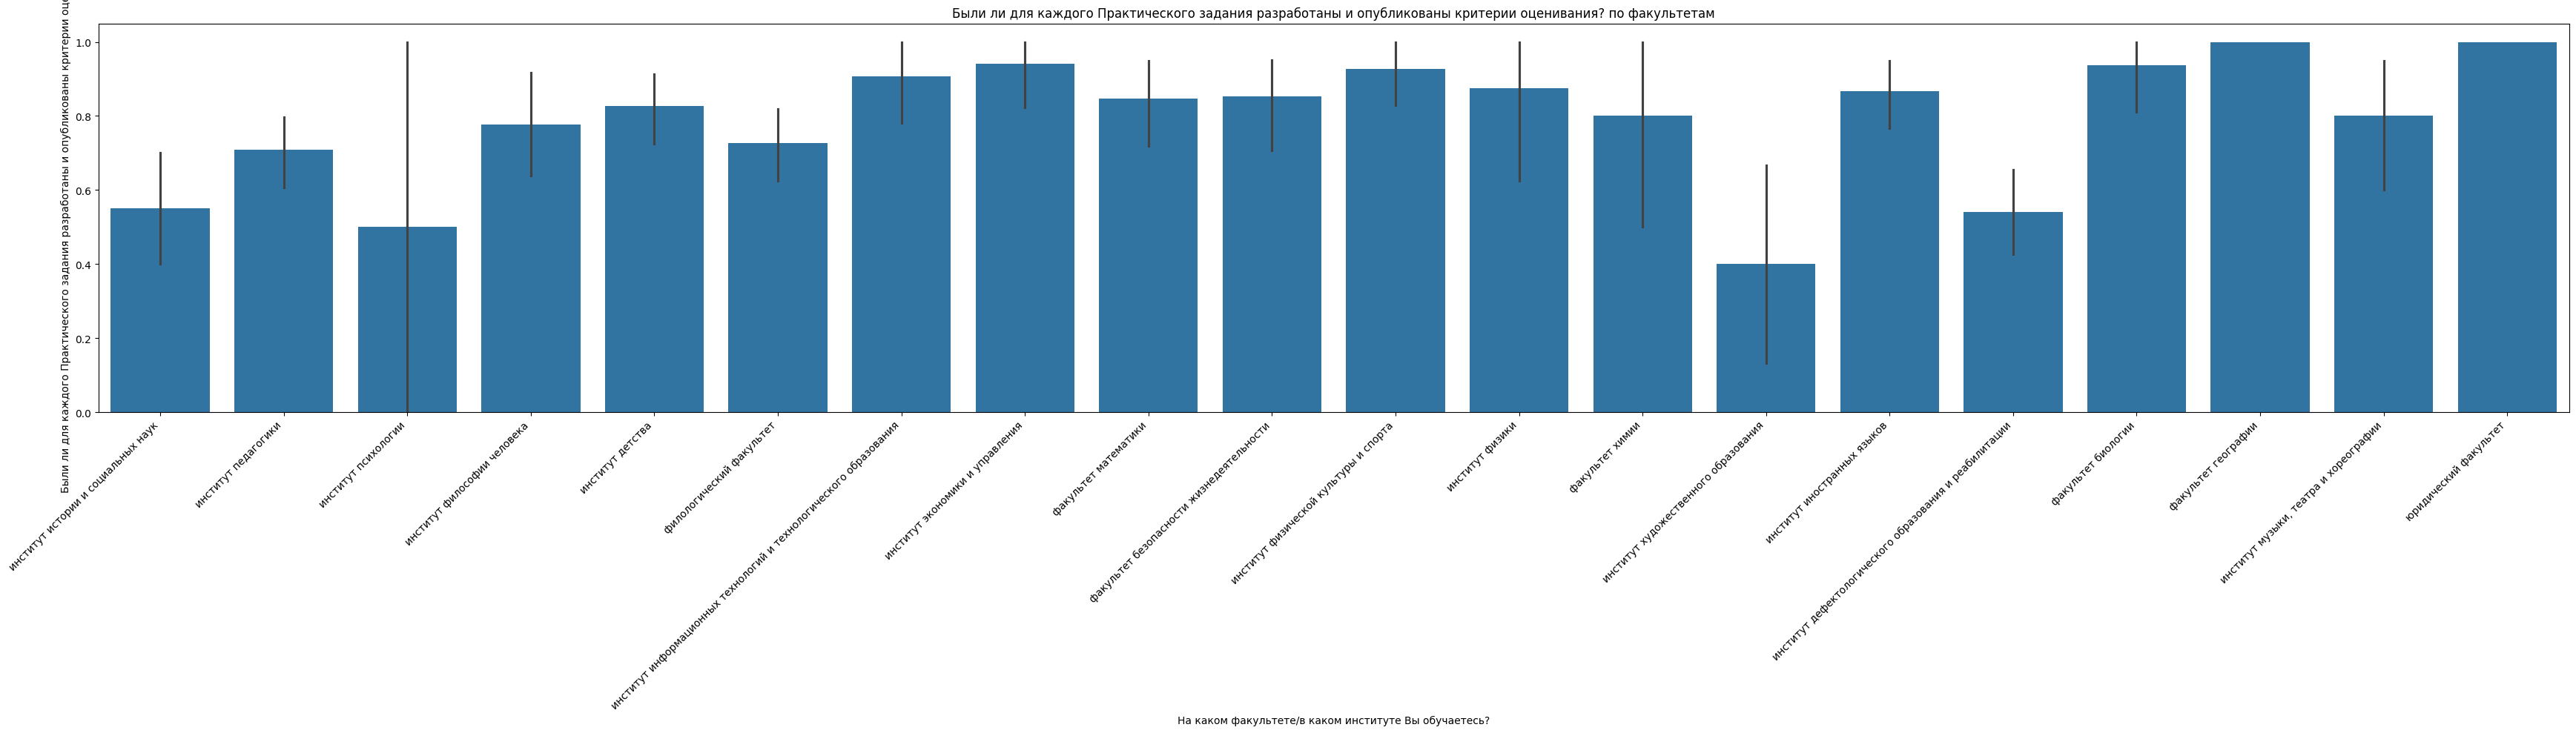

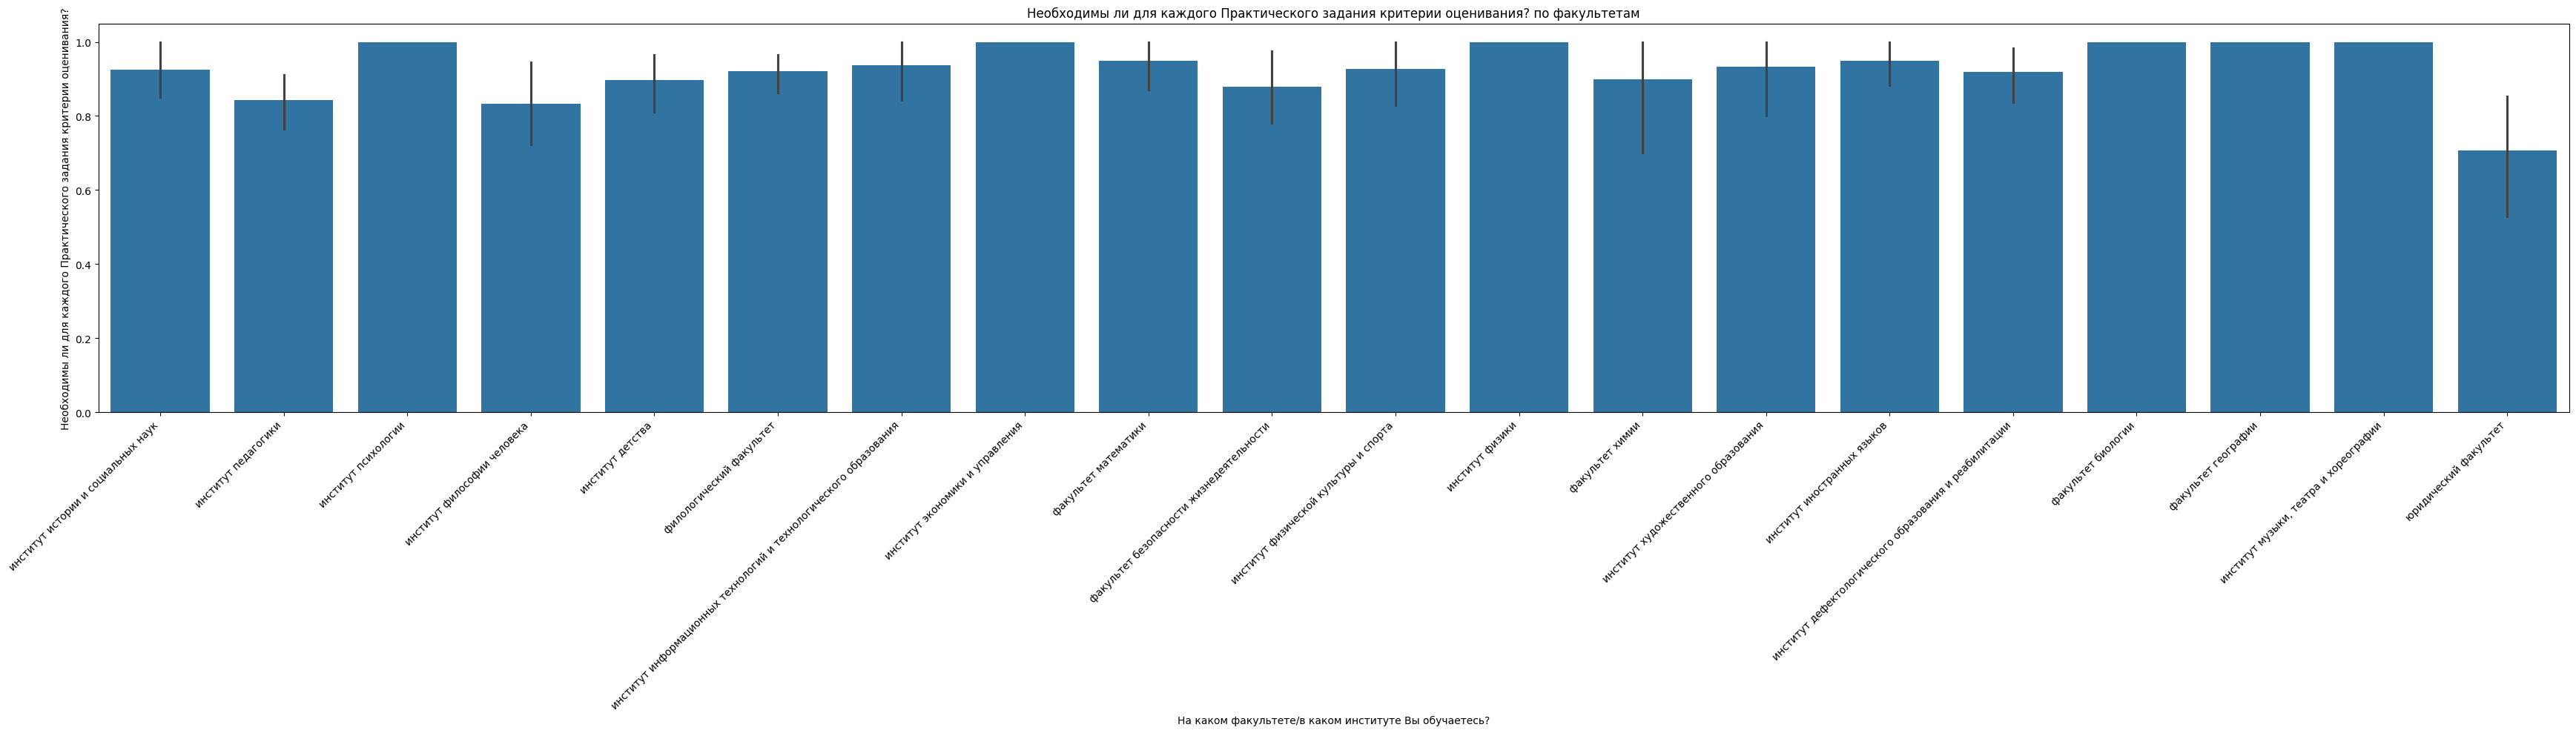

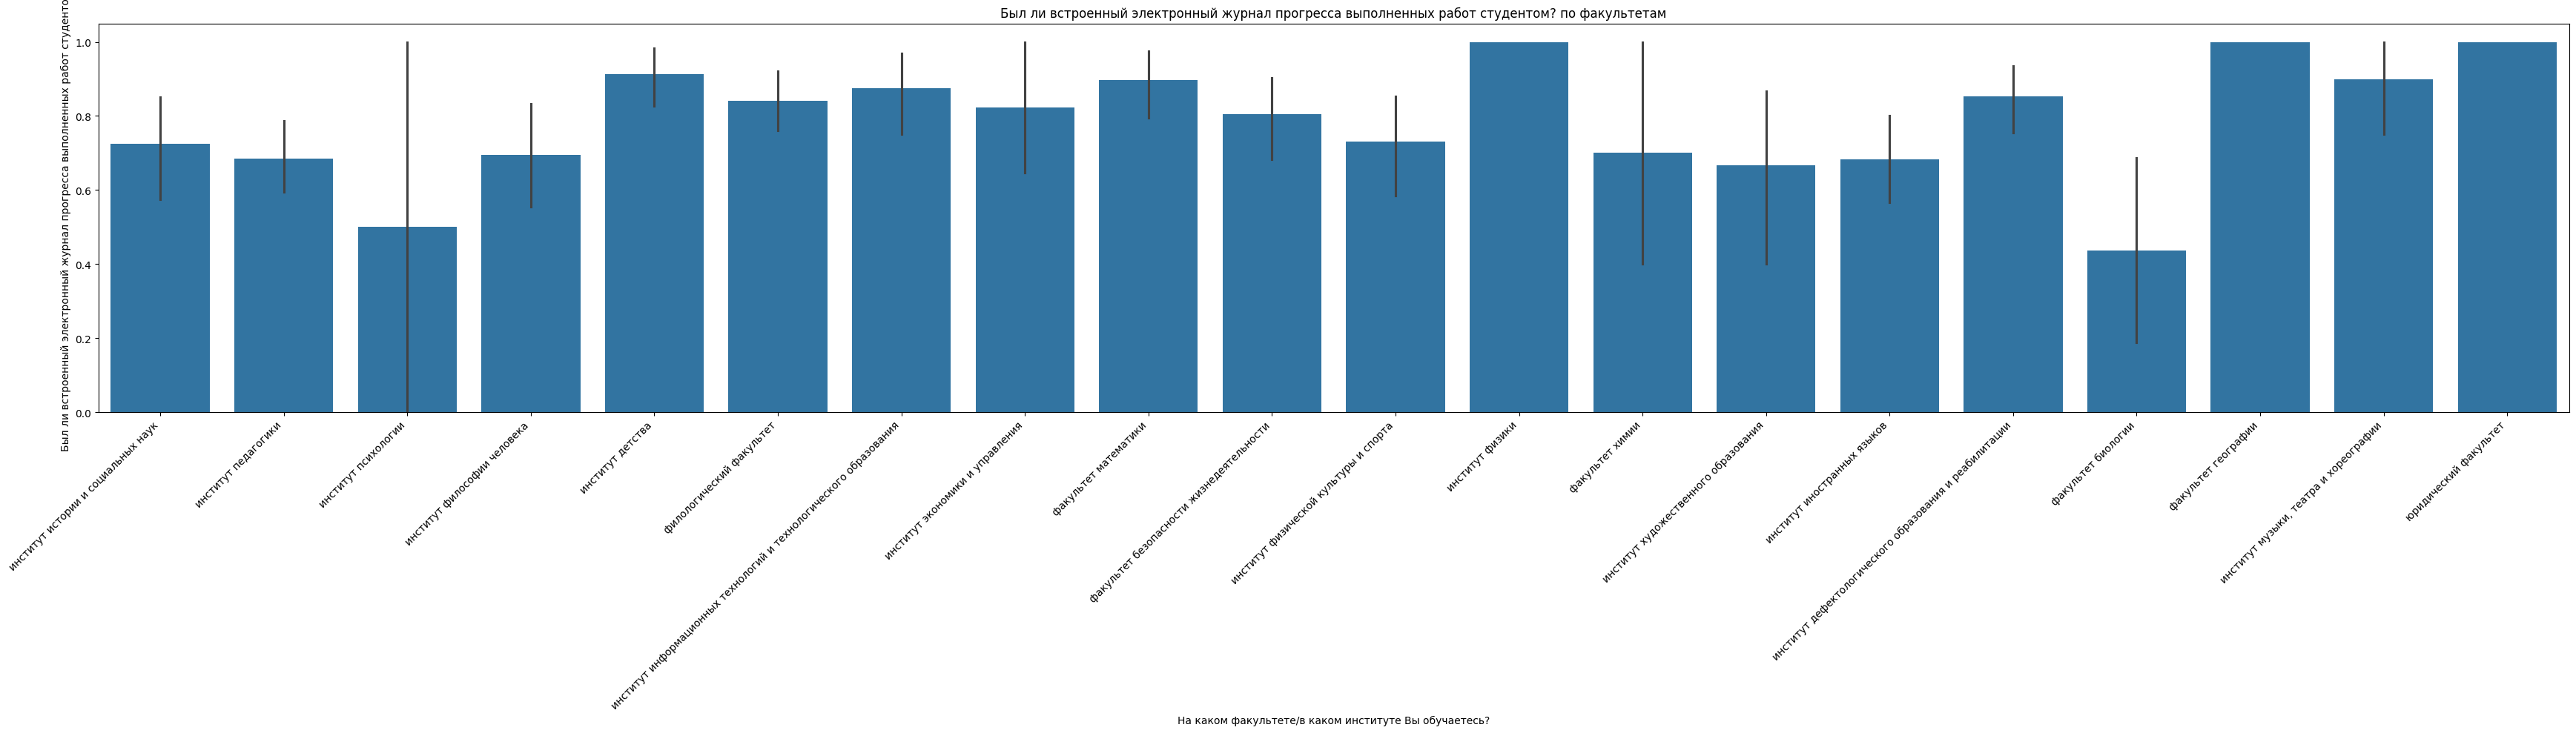

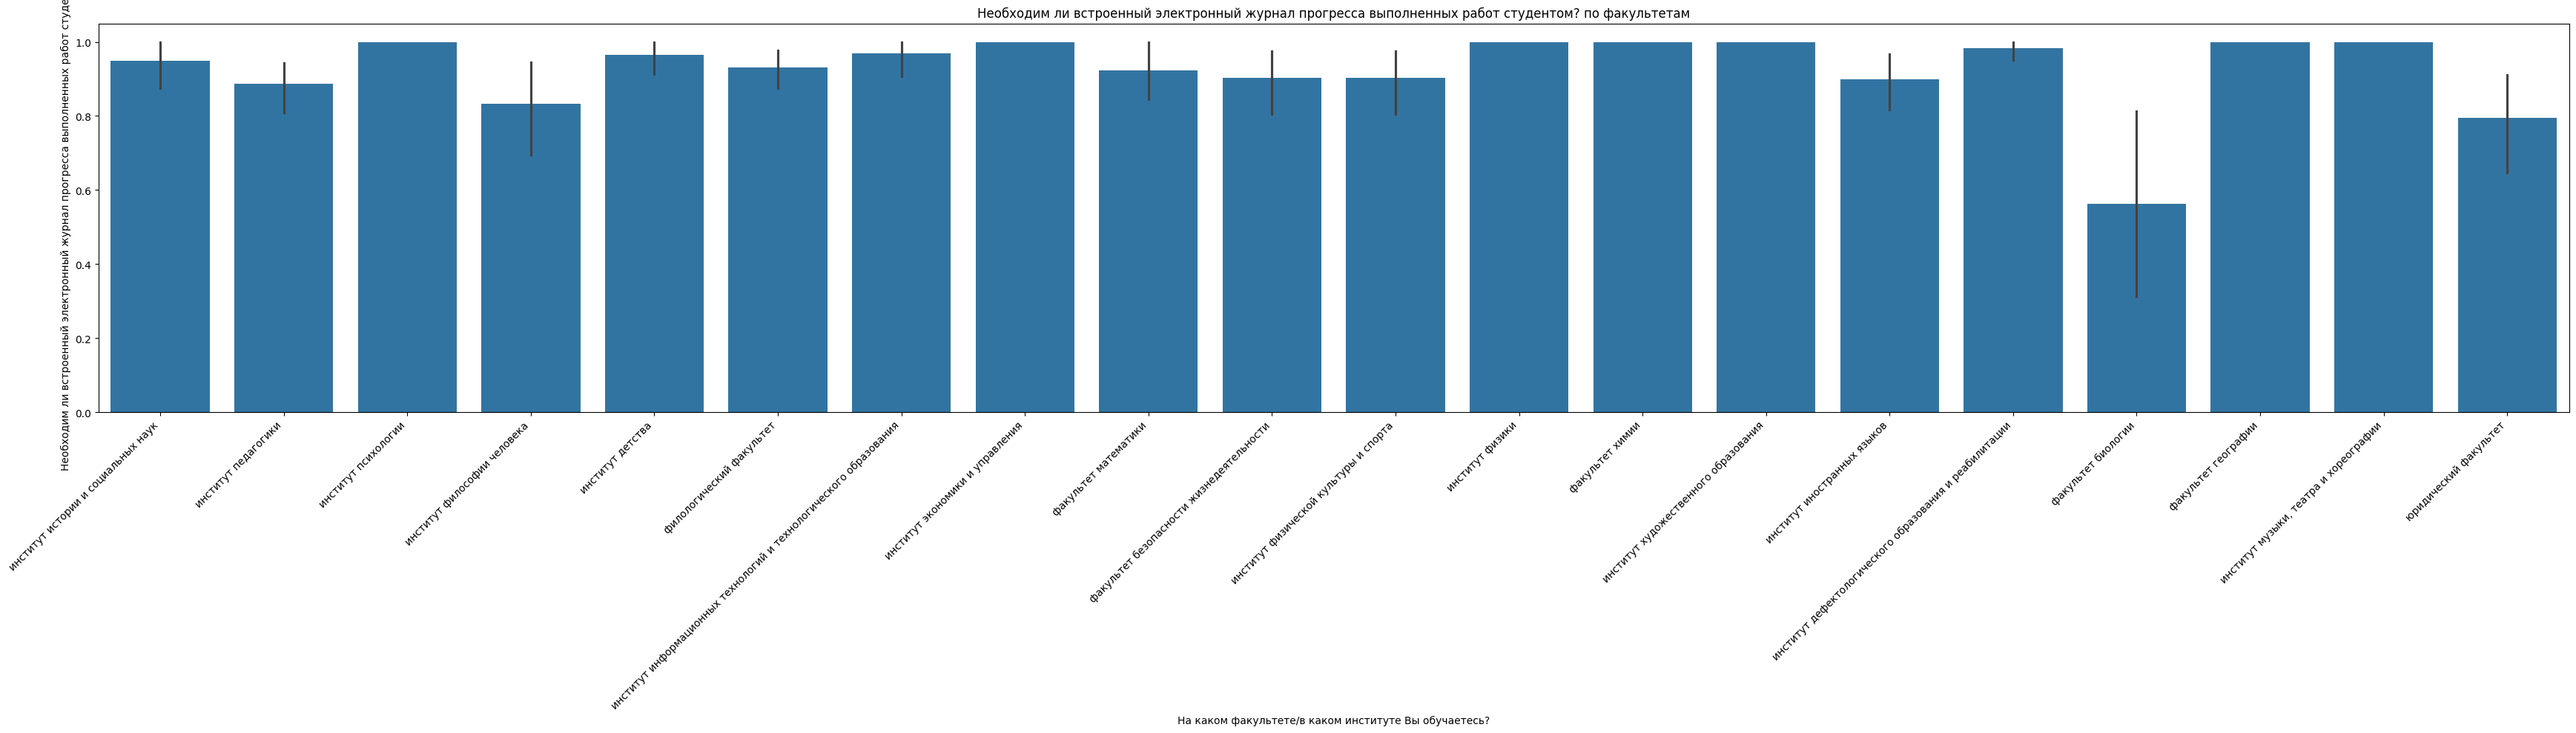

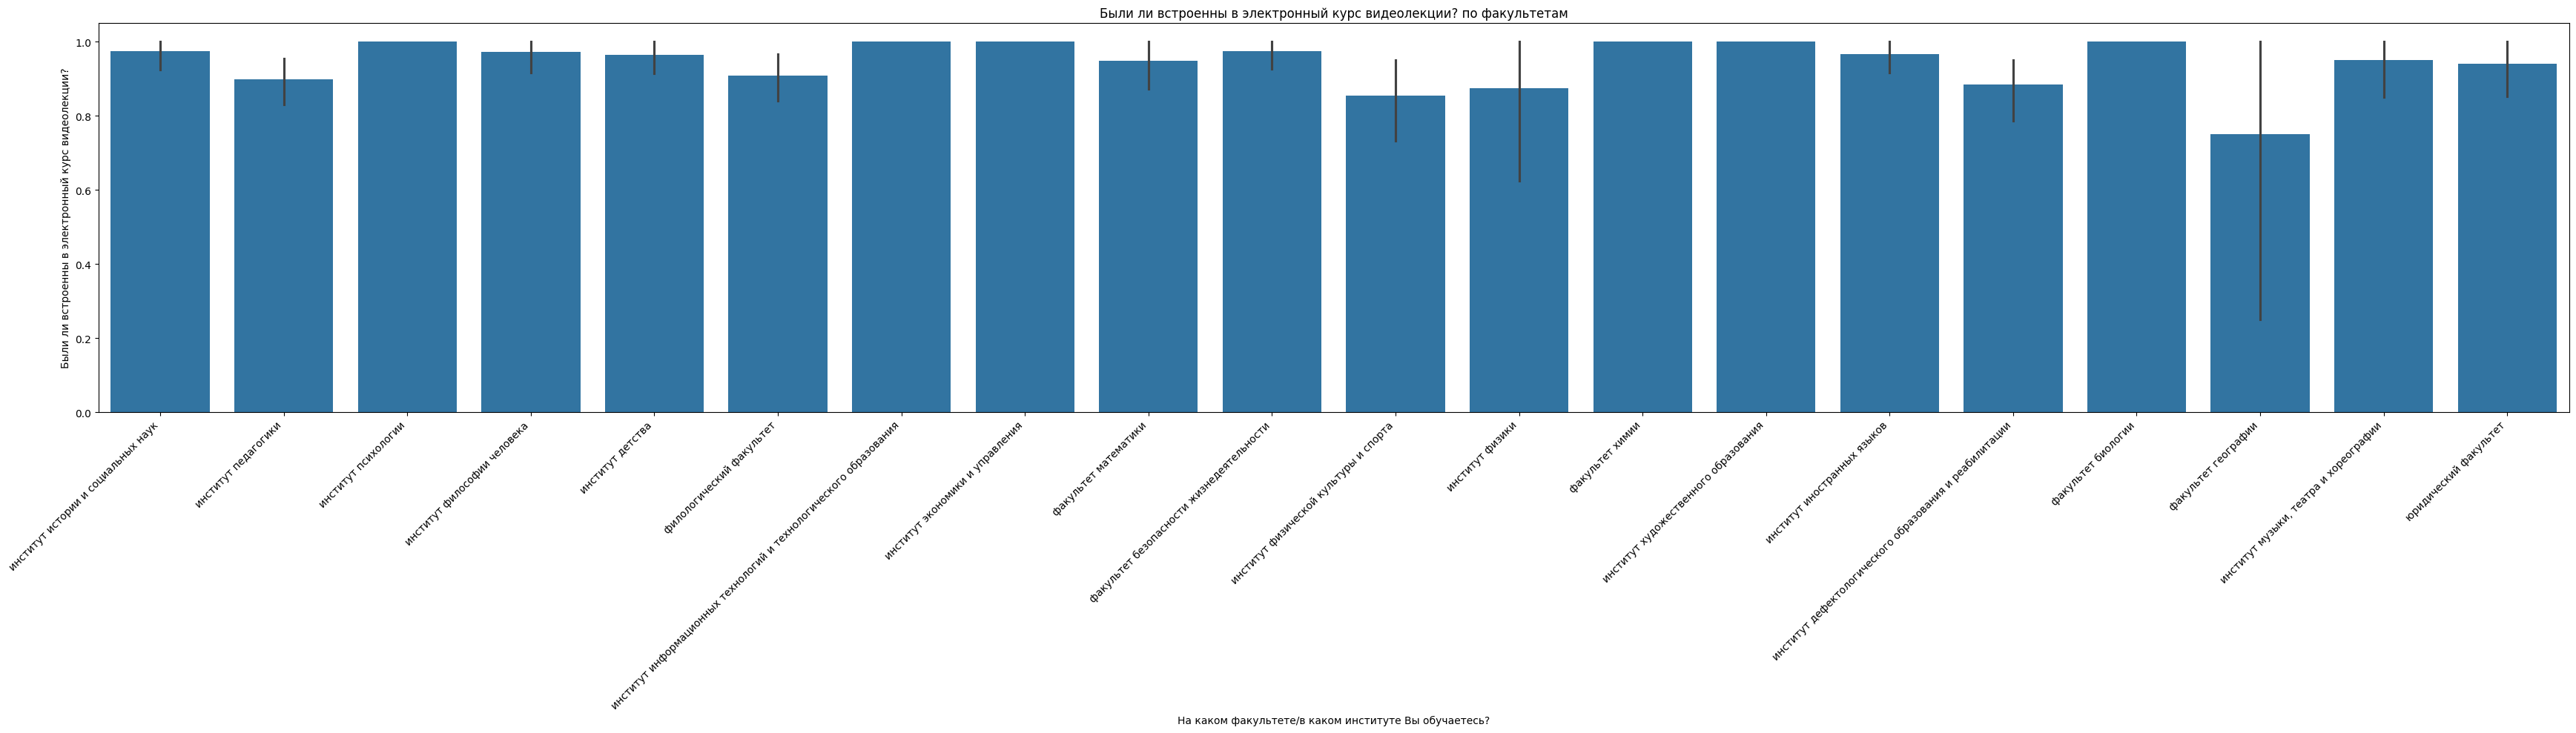

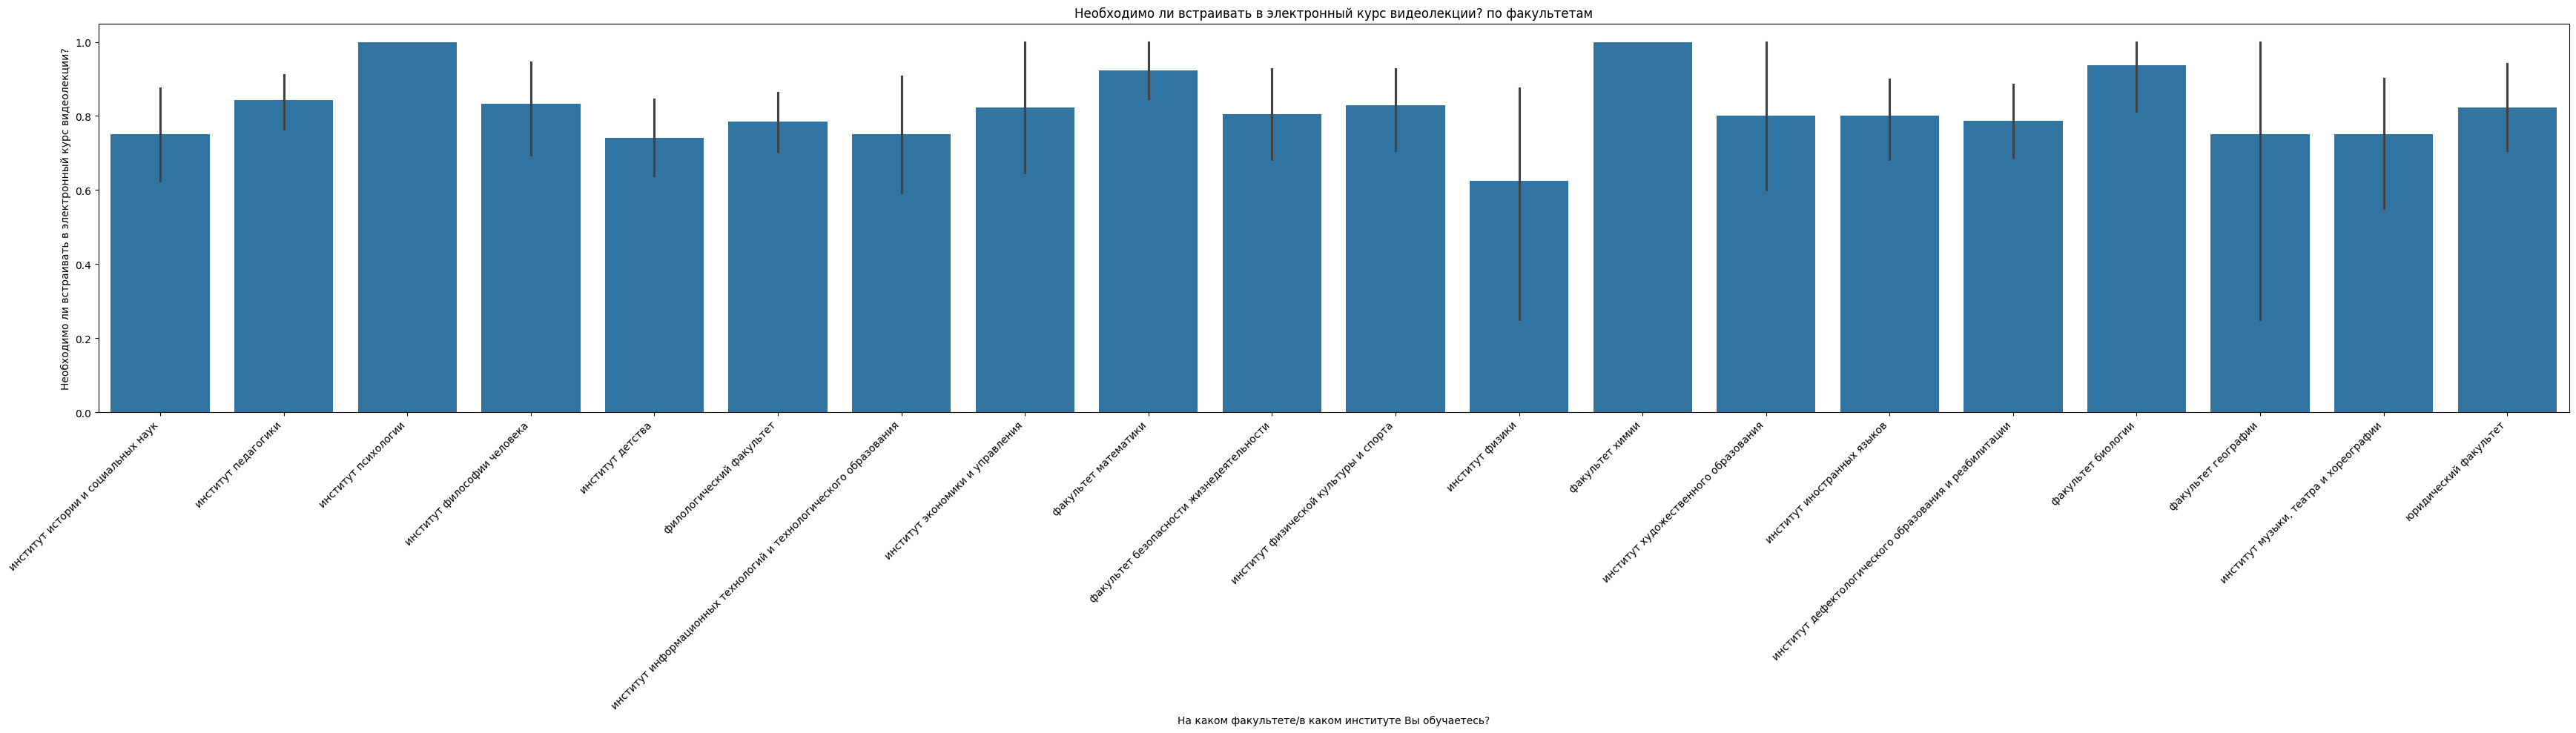

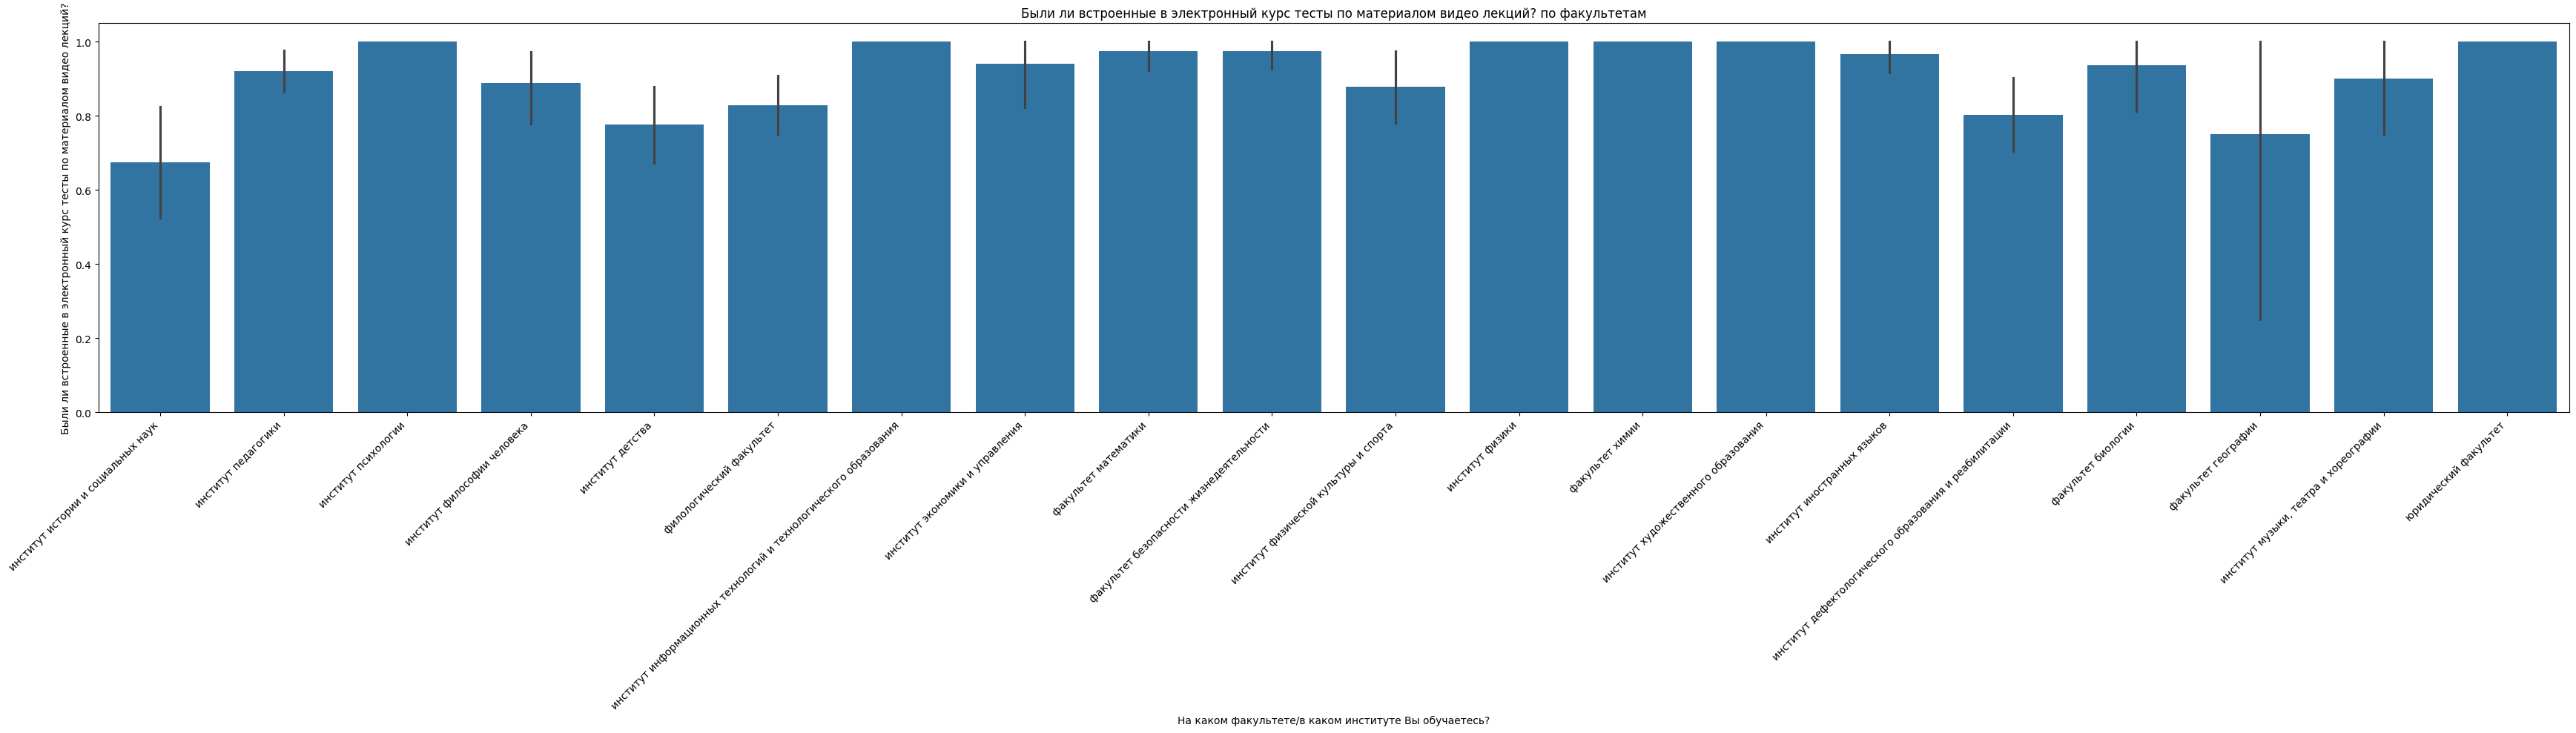

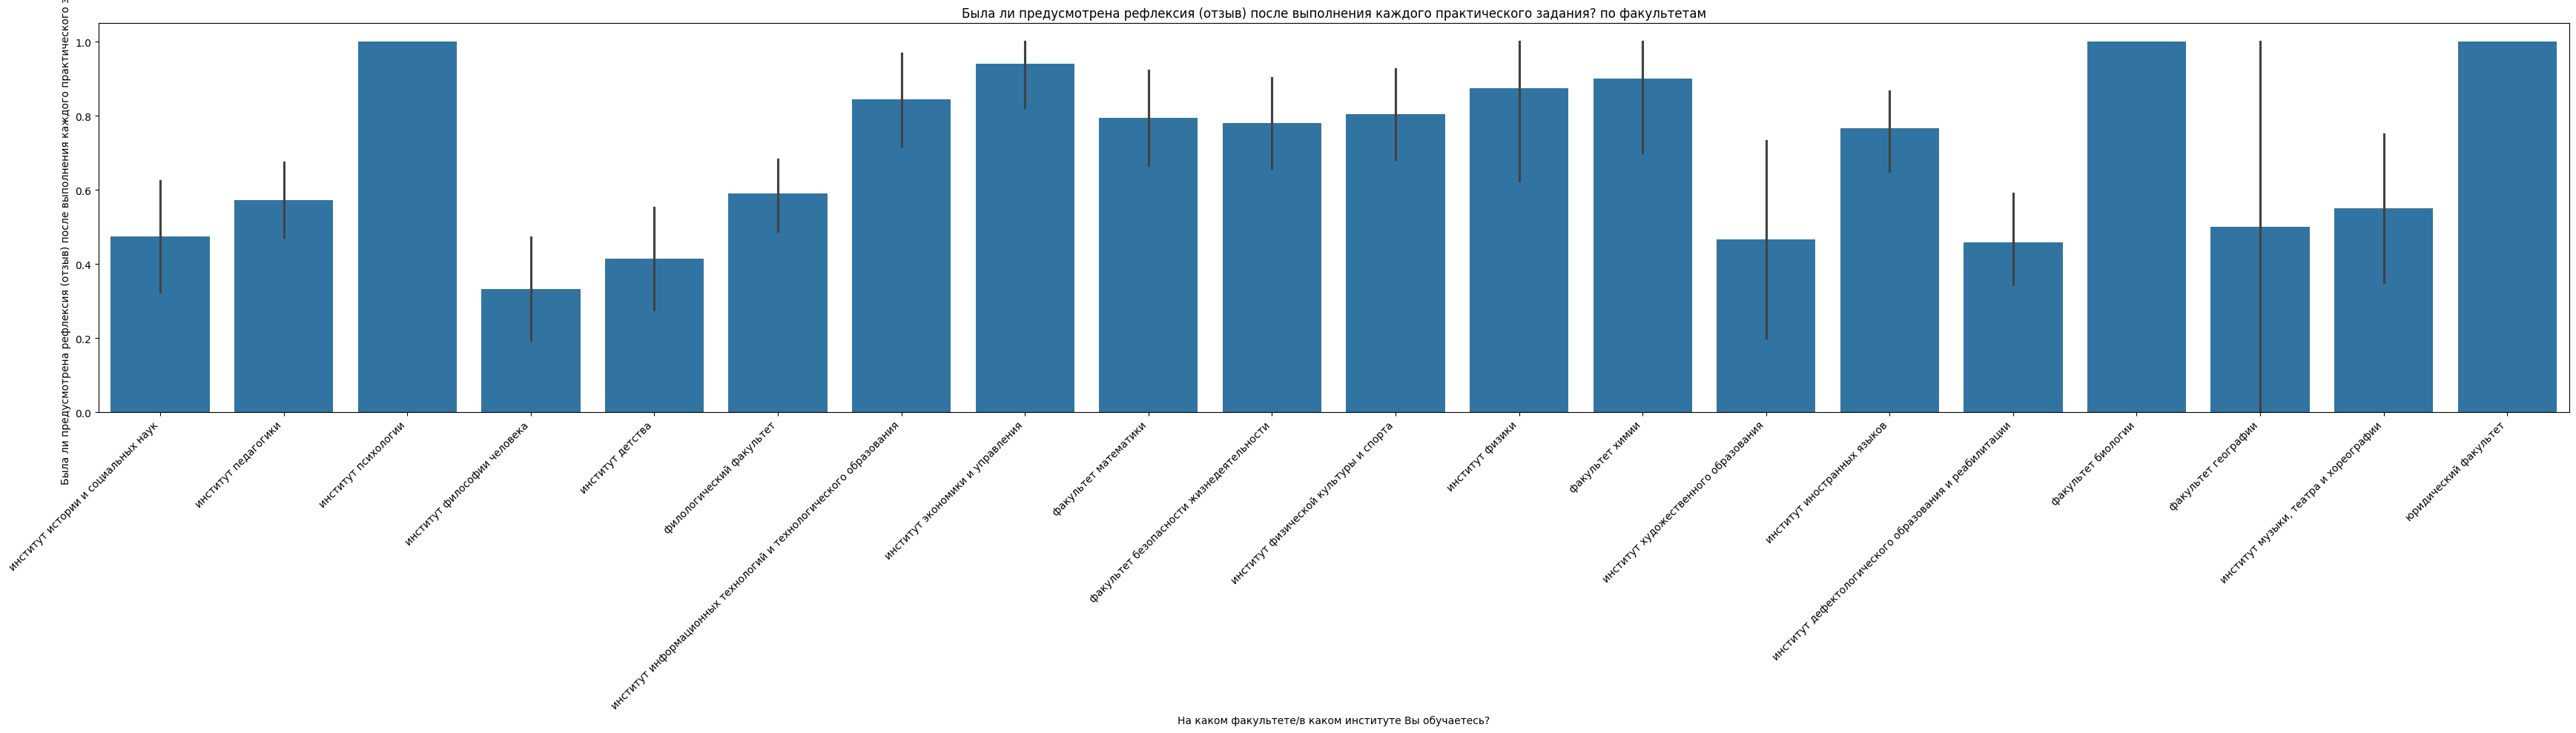

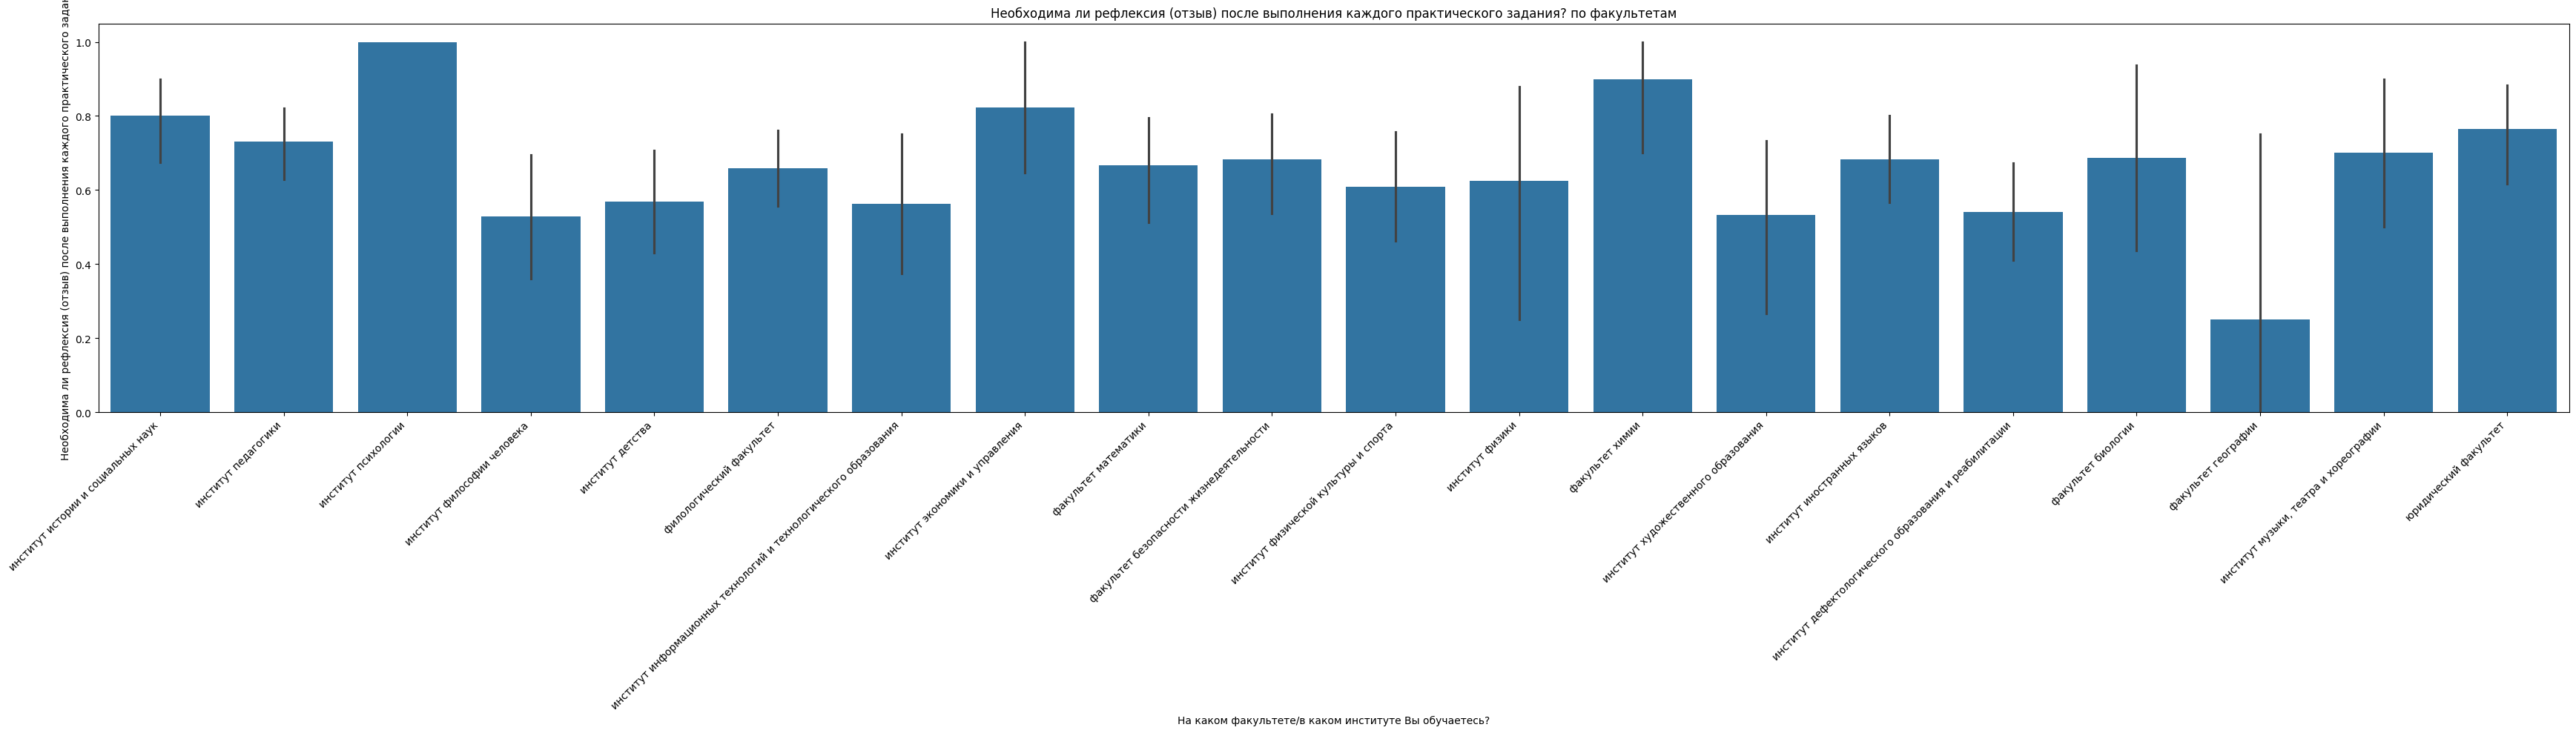

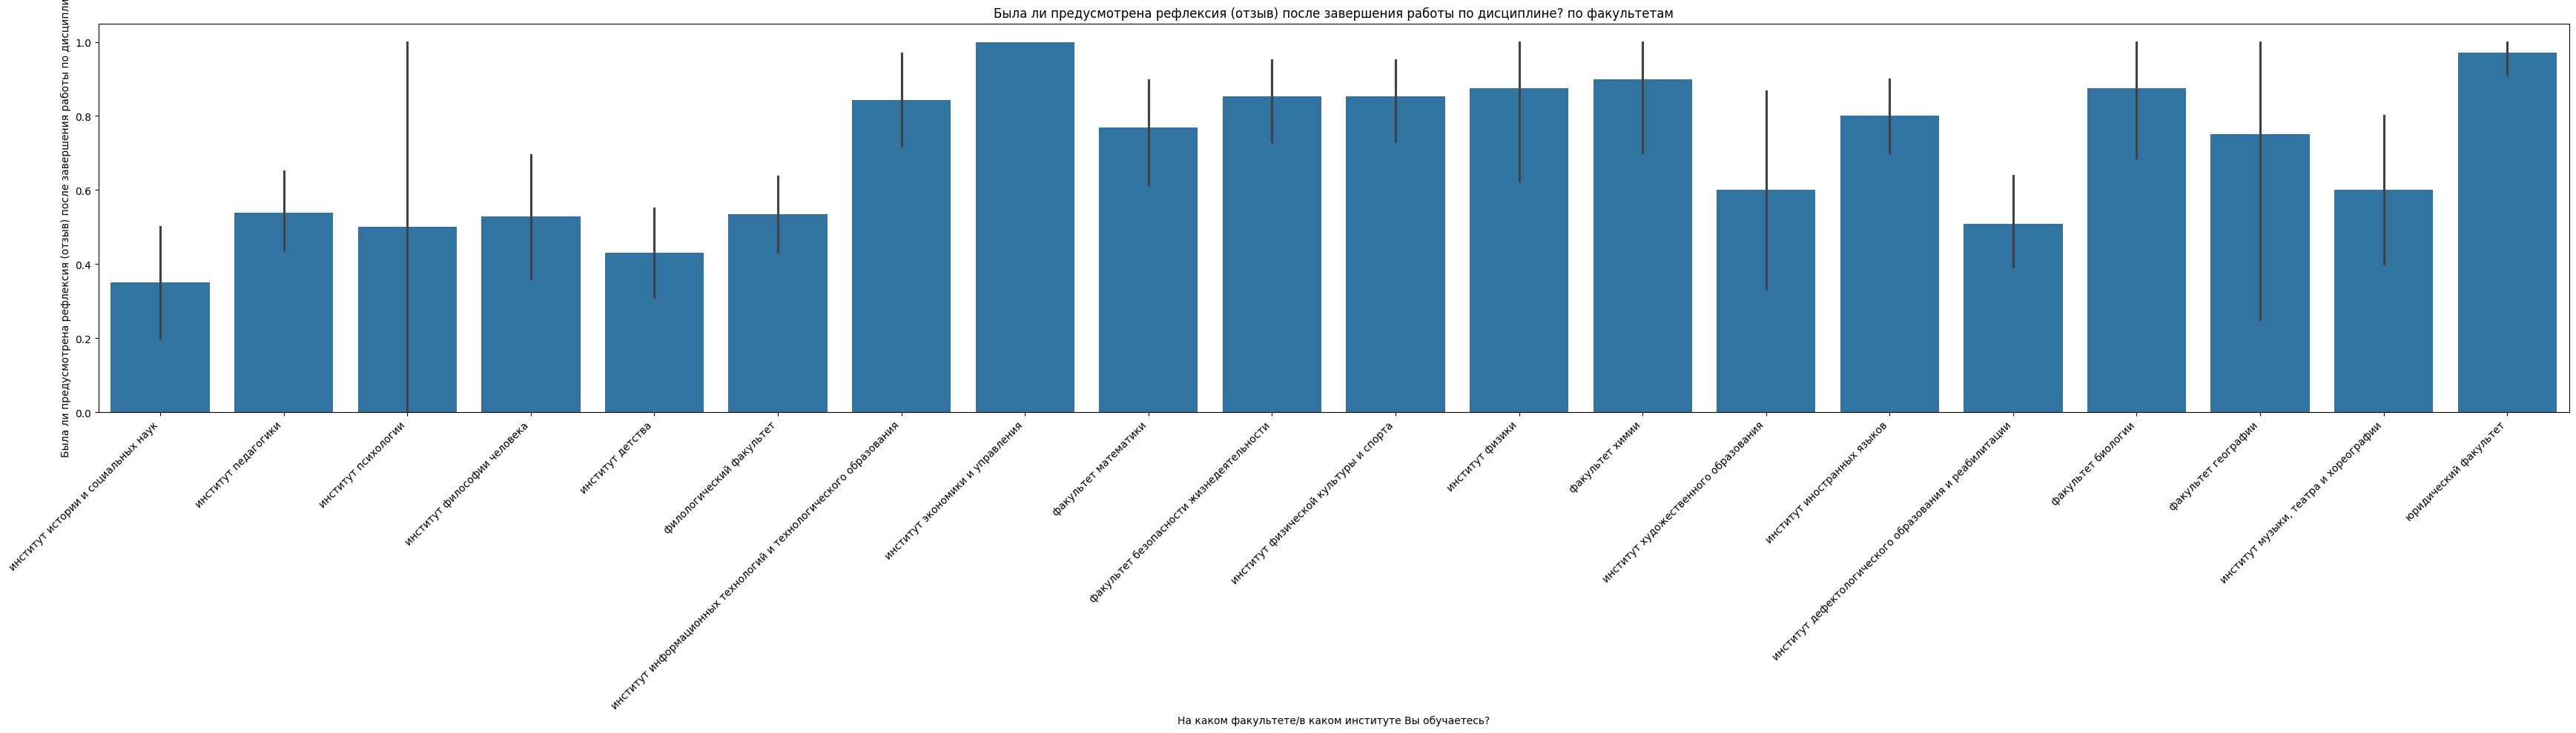

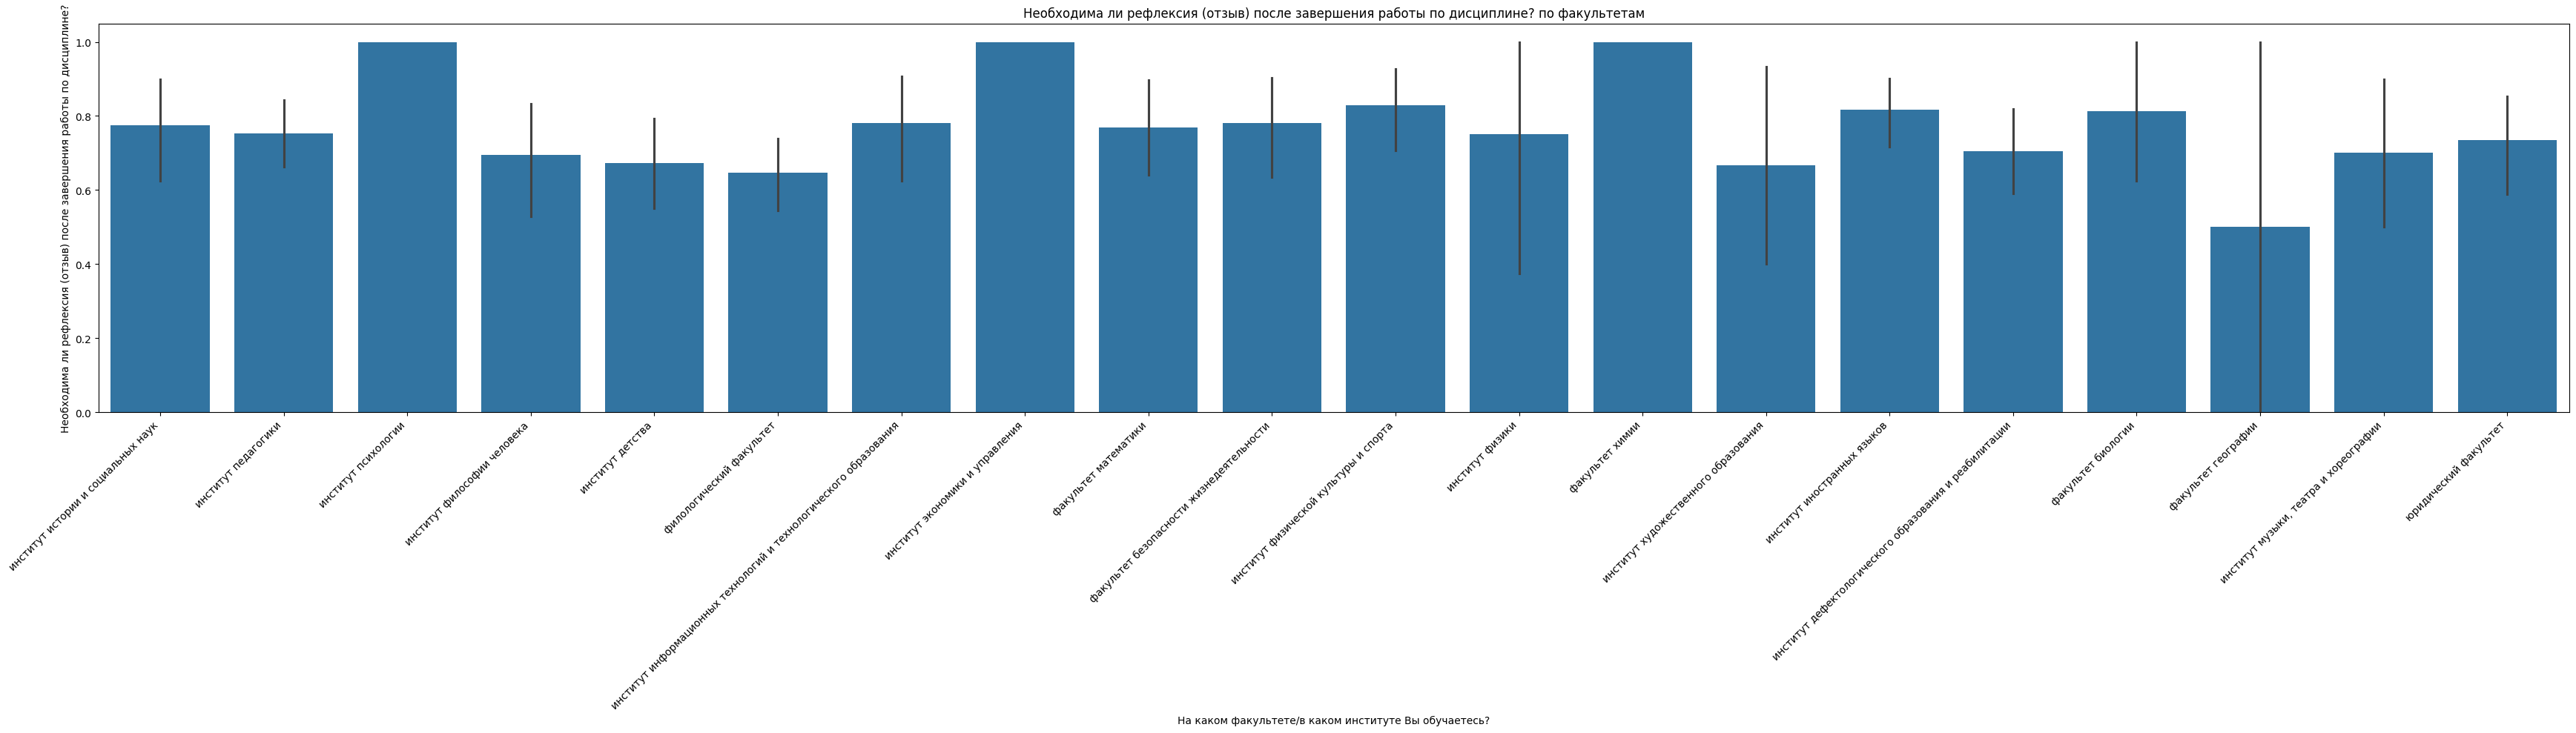

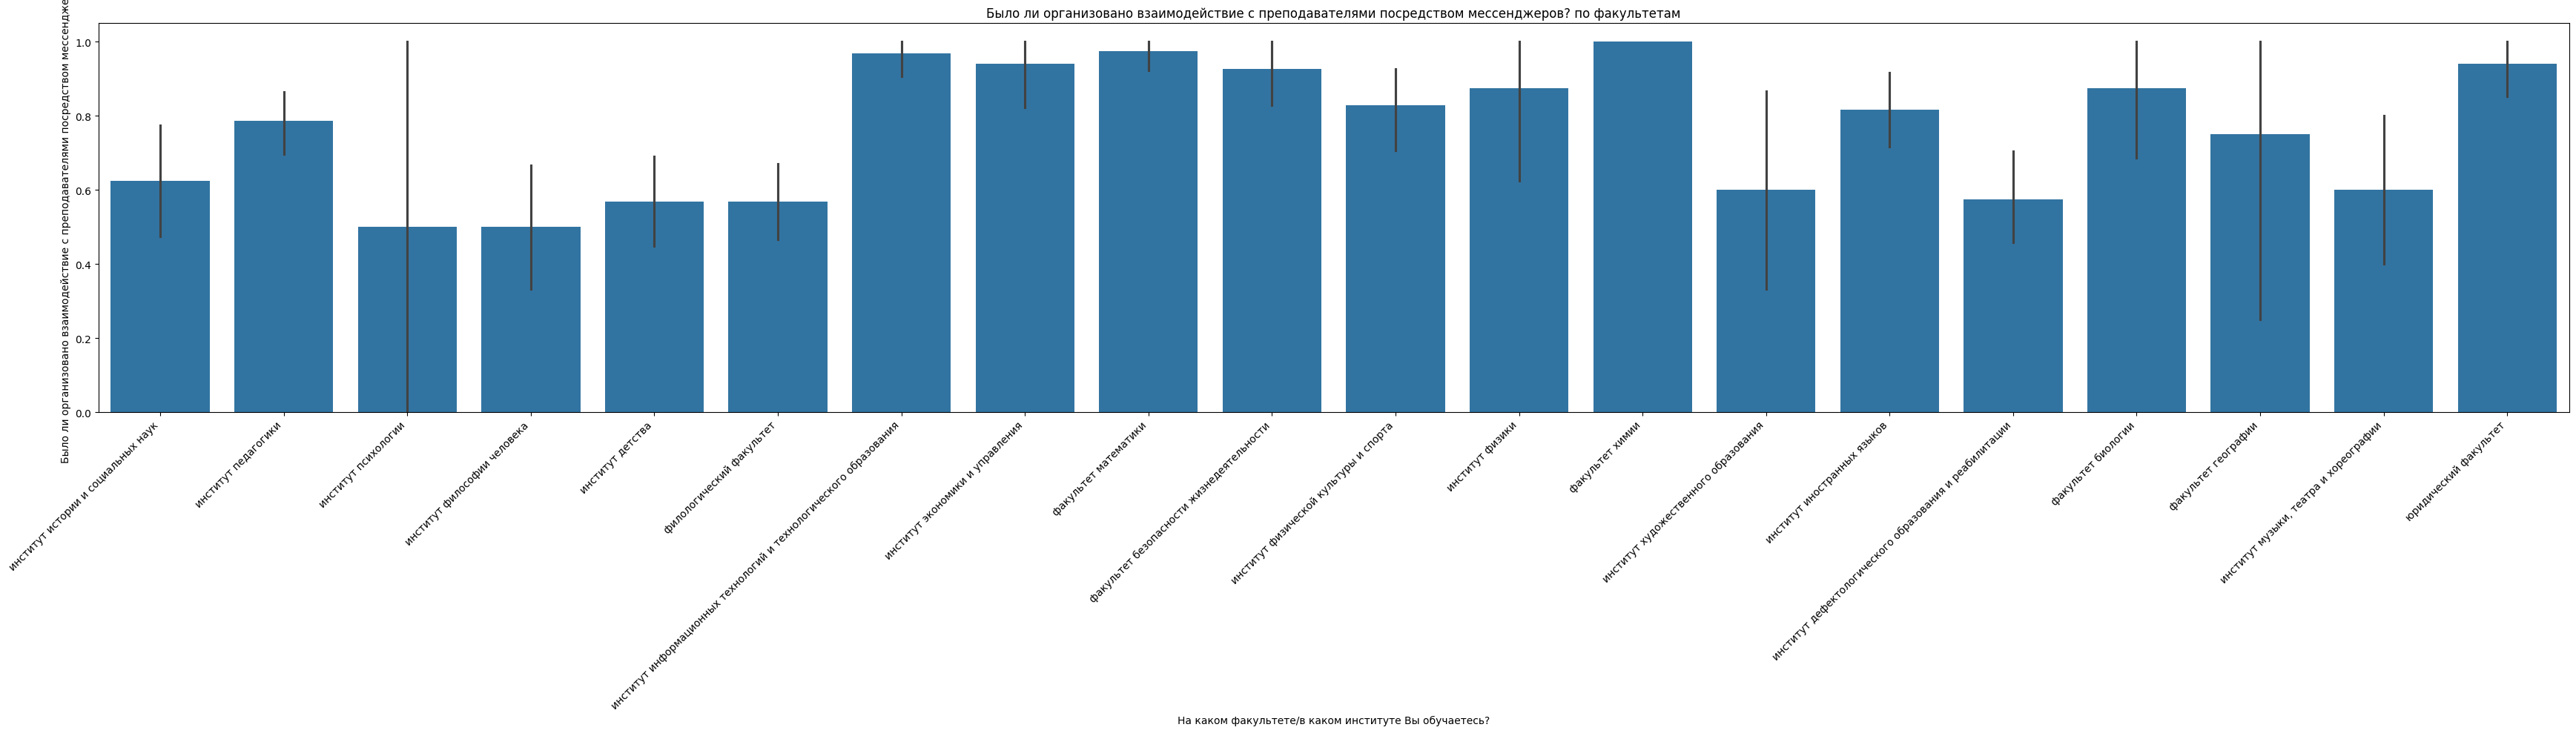

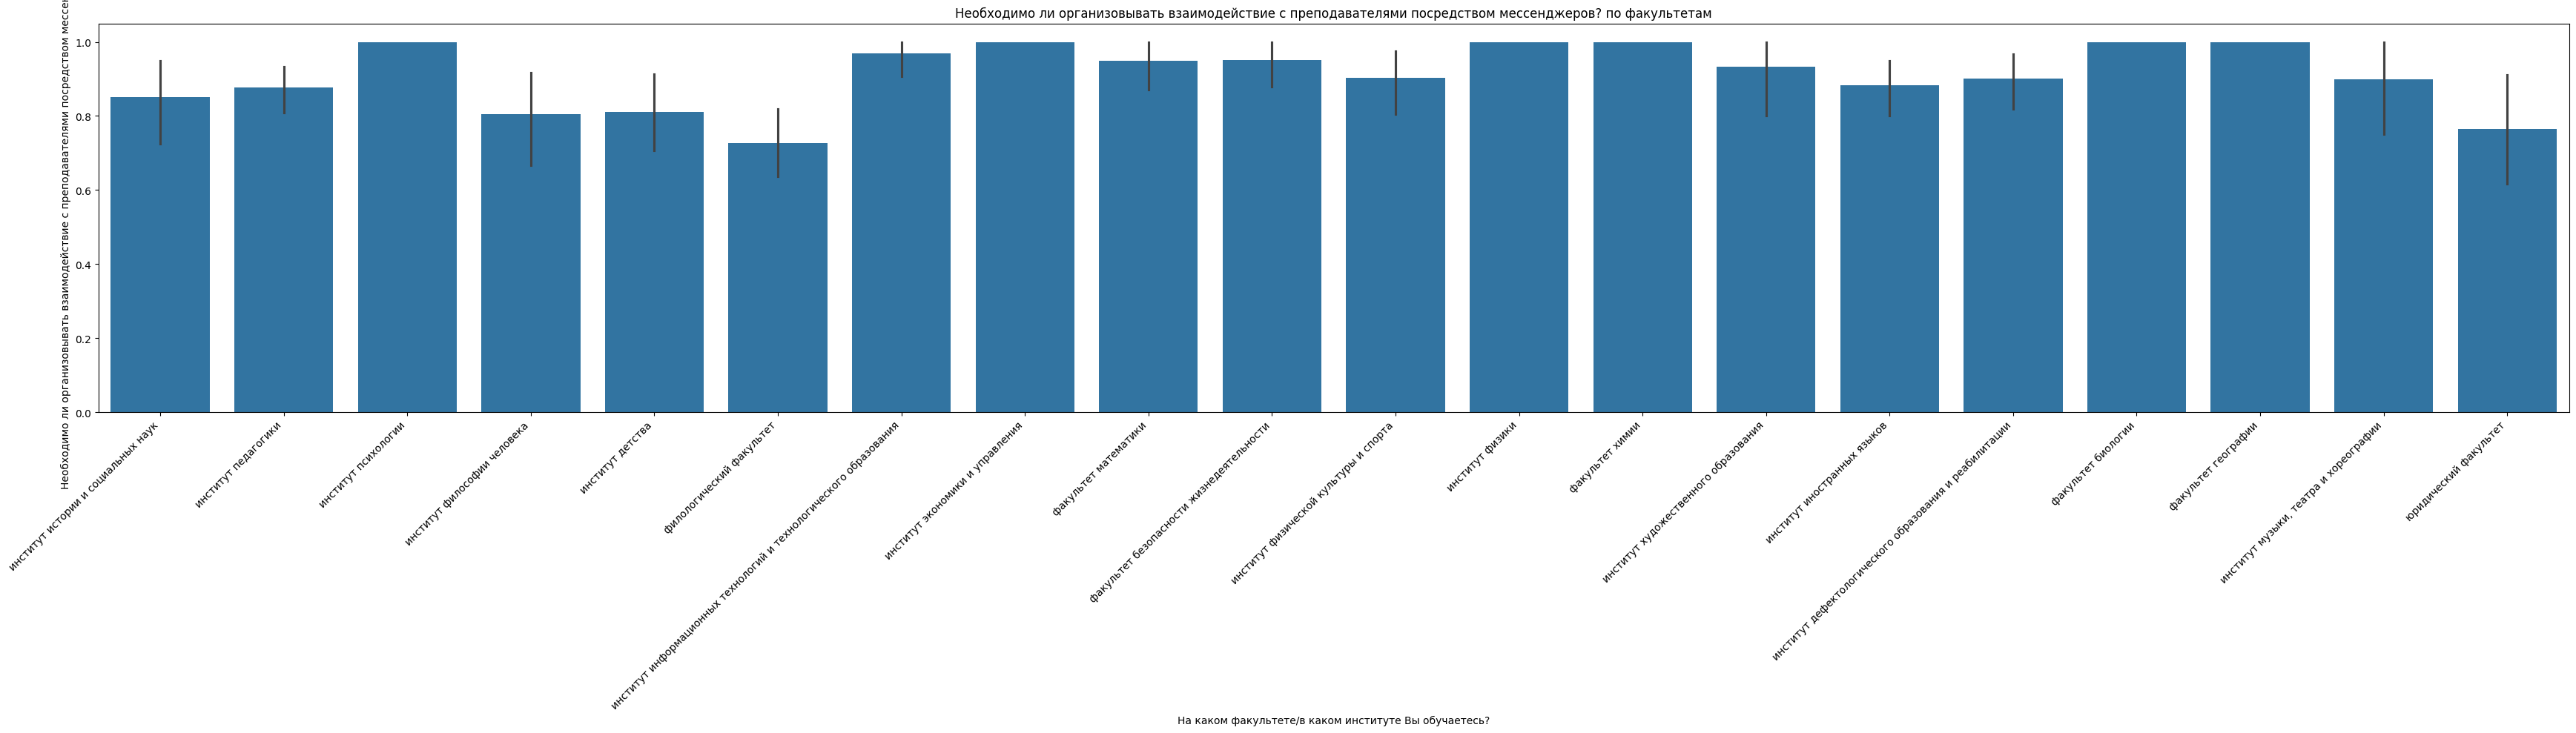

Связь бинарных признаков с факультетом (Cramér's V):


feature  cramers_v
2   Был ли автоматический мониторинг присутствия с...   0.672425
3   Необходим ли автоматический мониторинг присутс...   0.410862
13  Была ли предусмотрена рефлексия (отзыв) после ...   0.394122
15  Была ли предусмотрена рефлексия (отзыв) после ...   0.389933
17  Было ли организовано взаимодействие с преподав...   0.368792
6   Были ли для каждого Практического задания разр...   0.333787
0   Был ли предусмотрен фидбек (отклик преподавате...   0.314186
12  Были ли встроенные в электронный курс тесты по...   0.288804
8   Был ли встроенный электронный журнал прогресса...   0.279149
9   Необходим ли встроенный электронный журнал про...   0.270824
18  Необходимо ли организовывать взаимодействие с ...   0.237698
7   Необходимы ли для каждого Практического задани...   0.214359
4   Материалы, представленные для практического за...   0.201488
14  Необходима ли рефлексия (отзыв) после выполнен...   0.197854
10  Были ли встроенны в электронный курс видеолекции?   0.187671
16  Необходима ли рефлексия (отзыв) после завершен...   0.181283
1   Необходим ли фидбек (отклик преподавателя на в...   0.166213
5   Необходимо ли представлять материалы для практ...   0.157069
11  Необходимо ли встраивать в электронный курс ви...   0.144797

In [10]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1)) if min(k-1, r-1) > 0 else np.nan

if faculty_cols and binary_cols:
    faculty_col = faculty_cols[0]
    cramer_results = []
    for col in binary_cols:
        try:
            v = cramers_v(df[faculty_col], df[col])
            cramer_results.append({"feature": col, "cramers_v": v})
        except:
            cramer_results.append({"feature": col, "cramers_v": np.nan})
        # Barplot факультет vs бинарный
        if df[faculty_col].nunique() <= 20:
            plt.figure(figsize=(35, 10)) #(10, 4))
            sns.barplot(x=df[faculty_col], y=df[col])
            plt.xticks(rotation=45, ha='right')
            plt.title(f"{col} по факультетам")
            plt.tight_layout()
            plt.show()
    cramer_df = pd.DataFrame(cramer_results)
    print("Связь бинарных признаков с факультетом (Cramér's V):")
    display(cramer_df.sort_values("cramers_v", ascending=False))

Промежуточные выводы по этапу EDA:
Проанализированы основные характеристики данных: распределение по факультетам, пропуски, дисбаланс бинарных признаков.
Выделены малоинформативные и максимально различающиеся бинарные признаки.
Построены визуализации для boxplot, pairplot, heatmap.
Оценена связь между бинарными признаками и факультетами (коэффициент Cramér's V).

2. Предобработка данных и формирование признаков
Цель этапа:
Подготовить данные для последующего анализа и моделирования:
Очистить и стандартизировать исходный датасет
Преобразовать бинарные признаки
Масштабировать числовые переменные
Провести отбор признаков
Получить двумерное представление данных (UMAP)
Сохранить необходимые промежуточные таблицы

In [11]:
# 2.1 Импорт библиотек и задание путей

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import umap.umap_ as umap
import os

INPUT_PATH = "../data/dlia_studentov.xlsx"
OUTPUT_PATH = "../data/students_preprocessed.csv"
BINARIES_PATH = "../data/students_binaries.csv"

os.makedirs("../data", exist_ok=True)

c:\Users\влад\Desktop\vkr_project main!!!\vkrenv_win\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.2 Загрузка данных

In [13]:
print("[1] Загрузка данных...")
df = pd.read_excel(INPUT_PATH)
print(f"Загружено строк: {df.shape[0]}, столбцов: {df.shape[1]}")
display(df.head())

[1] Загрузка данных...
Загружено строк: 711, столбцов: 23


ID       Время создания  \
0  1408291245  2023-06-07 20:41:17   
1  1405883214  2023-06-05 09:02:21   
2  1405869646  2023-06-05 08:44:38   
3  1405856131  2023-06-05 08:26:39   
4  1405854542  2023-06-05 08:24:47   

  На каком факультете/в каком институте Вы обучаетесь?  \
0                 институт истории и социальных наук     
1                                институт педагогики     
2                                институт педагогики     
3                                институт педагогики     
4                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

  Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                нет                                                                             
1                                                 да                                                                             
2                                                 да                                                                             
3                                                 да                                                                             
4                                                 да                                                                             

  Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                нет                                                                                           
1                                                 да                                                                                           
2                                                 да                                                                                           
3                                                 да                                                                                           
4                                                 да                                                                                           

  Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                нет                                                  
1                                                нет                                                  
2                                                 да                                                  
3                                                нет                                                  
4                                                нет                                                  

  Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                нет                                                                             
1                                                 да                                                                             
2                                                 да                                                                             
3                                                нет                         

2.3 Очистка данных

In [15]:
print("[2] Очистка данных...")
# Удаляем столбцы, содержащие 'время'
df = df[[col for col in df.columns if "время" not in col.lower()]]

# Заполняем пропуски: строки — "нет", числа — среднее
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].fillna("нет")
    else:
        df[col] = df[col].fillna(df[col].mean())

# Удаляем полностью пустые строки и признаки с >70% пропусков
df = df.dropna(how='all')
df = df.dropna(axis=1, thresh=0.3 * len(df))
print(f"После очистки: строк {df.shape[0]}, столбцов {df.shape[1]}")

[2] Очистка данных...
После очистки: строк 711, столбцов 22


2.4 Бинаризация признаков

In [16]:
print("[3] Бинаризация признаков...")
binary_map = {
    "использую": 1, "не использую": 0,
    "использовать": 1, "не использовать": 0,
    "да": 1, "нет": 0,
    "Да": 1, "Нет": 0,
    "yes": 1, "no": 0,
    "Yes": 1, "No": 0,
    1: 1, 0: 0,
    "1": 1, "0": 0,
}
for col in df.columns:
    if df[col].dtype == object:
        unique = df[col].dropna().unique()
        if all(x in binary_map for x in unique):
            df[col] = df[col].map(binary_map).astype(float)

[3] Бинаризация признаков...


2.5 Сохранение бинарных признаков

In [17]:
faculty_col = [col for col in df.columns if "институт" in col.lower() or "факультет" in col.lower()]
if faculty_col:
    df["Факультет"] = df[faculty_col[0]]
    # Удаляем дубли, если есть
    df = df.drop(columns=faculty_col[1:])

print("[BINARIES] Отбор только бинарных признаков...")
# Бинарные признаки — только те, где уникальные значения ⊆ {0,1}
binaries = []
for col in df.columns:
    vals = set(df[col].dropna().unique())
    if vals <= {0, 1}:
        binaries.append(col)
bin_cols = binaries.copy()
if 'Факультет' in df.columns and 'Факультет' not in binaries:
    bin_cols.append('Факультет')
df_binaries = df[bin_cols]
df_binaries.to_csv(BINARIES_PATH, index=False)
print(f"[BINARIES] Сохранено {len(binaries)} бинарных признаков в {BINARIES_PATH}")
display(df_binaries.head())

[BINARIES] Отбор только бинарных признаков...
[BINARIES] Сохранено 19 бинарных признаков в ../data/students_binaries.csv


Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                1.0                                                                              
4                                                1.0                                                                              

   Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                0.0                                                                                            
1                                                1.0                                                                                            
2                                                1.0                                                                                            
3                                                1.0                                                                                            
4                                                1.0                                                                                            

   Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                1.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                0.0                                                                              
4                                                0.0                                                                              

   Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?  \
0                                                1.0                                                                            
1                                                0.0                                                                            
2                                                1.0                                                                            
3                                                1.0                                                                            
4                                                1.0                                                                            

   Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?  \
0                       

2.6 Масштабирование и отбор числовых признаков

In [18]:
numeric_df = df.select_dtypes(include=[np.number])
print(f"Числовых признаков для анализа: {numeric_df.shape[1]}")

print("[4] Масштабирование и отбор признаков...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X_scaled)
print(f"После отбора осталось признаков: {X_selected.shape[1]}")

Числовых признаков для анализа: 20
[4] Масштабирование и отбор признаков...
После отбора осталось признаков: 20


2.7 Понижение размерности через UMAP

[5] Понижение размерности через UMAP...


c:\Users\влад\Desktop\vkr_project main!!!\vkrenv_win\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\влад\Desktop\vkr_project main!!!\vkrenv_win\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


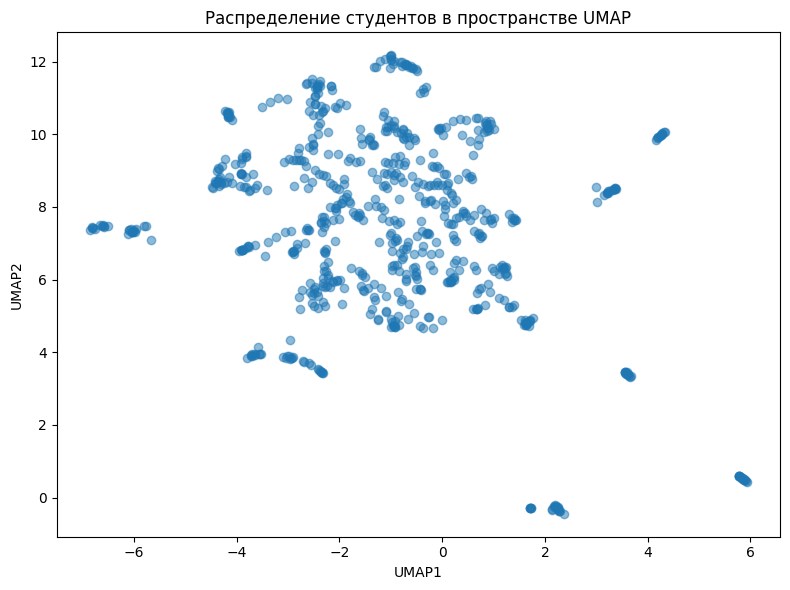

In [19]:
print("[5] Понижение размерности через UMAP...")
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_selected)

df_result = df.copy()
df_result["UMAP1"] = X_umap[:, 0]
df_result["UMAP2"] = X_umap[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df_result["UMAP1"], df_result["UMAP2"], alpha=0.5)
plt.title("Распределение студентов в пространстве UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

2.8 Сохранение подготовленных данных

In [20]:
print("[6] Сохранение результатов...")
df_result.to_csv(OUTPUT_PATH, index=False)
print(f"Сохранено в {OUTPUT_PATH}")
display(df_result.head())

[6] Сохранение результатов...
Сохранено в ../data/students_preprocessed.csv


ID На каком факультете/в каком институте Вы обучаетесь?  \
0  1408291245                 институт истории и социальных наук     
1  1405883214                                институт педагогики     
2  1405869646                                институт педагогики     
3  1405856131                                институт педагогики     
4  1405854542                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

   Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                1.0                                                                              
4                                                1.0                                                                              

   Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                0.0                                                                                            
1                                                1.0                                                                                            
2                                                1.0                                                                                            
3                                                1.0                                                                                            
4                                                1.0                                                                                            

   Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                1.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                0.0                                                                              
4                                                0.0                             

3. Расчёт матрицы расстояний Говера (Gower distance) по бинарным признакам
Цель этапа:
Построить матрицу попарных расстояний между студентами с учётом бинарных признаков. Эта матрица нужна для кластеризации, учитывающей специфику бинарных и категориальных данных.
Gower distance — классическая метрика для смешанных (особенно бинарных и категориальных) данных.

In [21]:
# 3.1 Импорт библиотек и задание путей

import pandas as pd
import numpy as np
import gower
import os
import seaborn as sns
import matplotlib.pyplot as plt

INPUT_PATH = "../data/students_binaries.csv"
OUTPUT_MATRIX = "../data/gower_distance_matrix.npy"
OUTPUT_HEATMAP = "../outputs/distance_matrix_gower/gower_heatmap.png"

os.makedirs("../outputs/distance_matrix_gower", exist_ok=True)

3.2 Загрузка бинарных данных

In [22]:
print("[1] Загрузка только бинарных данных...")
df = pd.read_csv(INPUT_PATH)
print(f"Размер данных: {df.shape}")
display(df.head())

[1] Загрузка только бинарных данных...
Размер данных: (711, 20)


Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                1.0                                                                              
4                                                1.0                                                                              

   Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                0.0                                                                                            
1                                                1.0                                                                                            
2                                                1.0                                                                                            
3                                                1.0                                                                                            
4                                                1.0                                                                                            

   Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                1.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                0.0                                                                              
4                                                0.0                                                                              

   Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?  \
0                                                1.0                                                                            
1                                                0.0                                                                            
2                                                1.0                                                                            
3                                                1.0                                                                            
4                                                1.0                                                                            

   Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?  \
0                       

3.3 Расчёт матрицы расстояний Говера

In [23]:
# Отбираем только бинарные признаки для расчёта (без факультета)
if "Факультет" in df.columns:
    df_features = df.drop(columns=["Факультет"])
else:
    df_features = df

print("[2] Расчёт матрицы расстояний Говера по бинарным признакам...")
distance_matrix = gower.gower_matrix(df_features)
np.save(OUTPUT_MATRIX, distance_matrix)
print(f"Матрица расстояний сохранена в {OUTPUT_MATRIX}")
print(f"Размерность матрицы: {distance_matrix.shape}")

[2] Расчёт матрицы расстояний Говера по бинарным признакам...
Матрица расстояний сохранена в ../data/gower_distance_matrix.npy
Размерность матрицы: (711, 711)


3.4 Визуализация (фрагмент) матрицы расстояний

[3] Построение тепловой карты расстояний (фрагмент)...


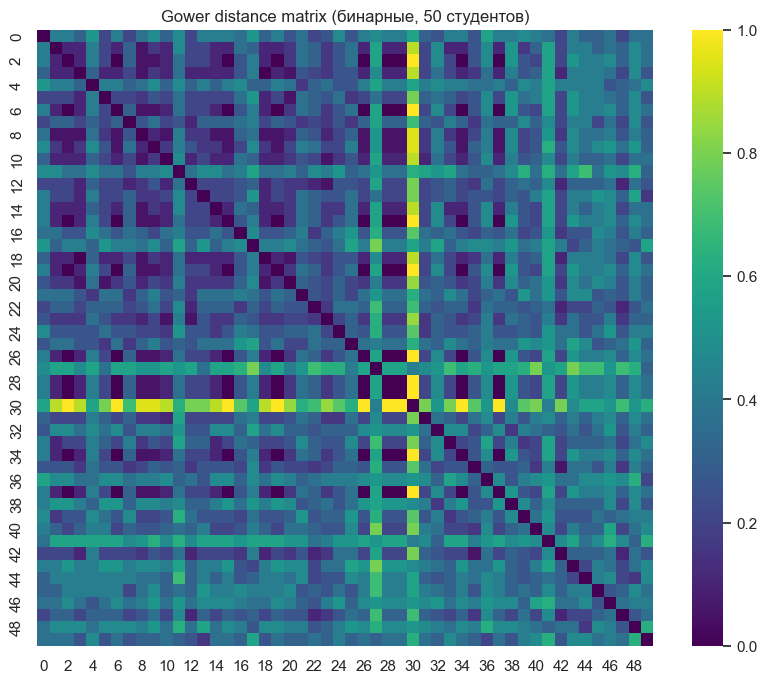

In [24]:
print("[3] Построение тепловой карты расстояний (фрагмент)...")
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix[:50, :50], cmap="viridis", square=True)
plt.title("Gower distance matrix (бинарные, 50 студентов)")
plt.show()

Пояснения:
Gower distance измеряет схожесть между объектами по всем признакам: 0 — полное совпадение, 1 — полное различие.
Тепловая карта отображает 50×50 верхних строк/столбцов, чтобы показать "паттерны" схожести/различий среди первых 50 студентов.
Полная матрица сохранена для следующего этапа кластеризации.

4. Кластеризация студентов: UMAP-признаки и матрица Говера
Цель этапа:
Выполнить кластеризацию студентов по признакам, полученным с помощью UMAP и по матрице расстояний Говера, подобрать оптимальное число кластеров и проанализировать результаты с помощью метрик качества.

In [25]:
# 4.1 Импорт библиотек и настройка путей

import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

INPUT_PATH = "../data/students_preprocessed.csv"
GOWER_MATRIX_PATH = "../data/gower_distance_matrix.npy"
OUTPUT_PATH = "../outputs/cluster_students_umap/students_with_clusters.csv"
OUTPUT_DIR = "../outputs/cluster_students_umap/cluster_students"
os.makedirs(OUTPUT_DIR, exist_ok=True)

4.2 Загрузка данных (UMAP-признаки)

In [26]:
print("[1] Загрузка данных (UMAP-признаки)...")
df = pd.read_csv(INPUT_PATH)
X_umap = df[["UMAP1", "UMAP2"]].values
print(f"Форма X_umap: {X_umap.shape}")

[1] Загрузка данных (UMAP-признаки)...
Форма X_umap: (711, 2)


4.3 Кластеризация по UMAP: Agglomerative и Fuzzy C-Means


In [27]:
CLUSTER_RANGE = range(2, 7)
results_agglom = []
results_fcm = []

print("[2] Кластеризация по UMAP-признакам...")
for n_clusters in CLUSTER_RANGE:
    # Agglomerative Clustering
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    labels_ac = agglom.fit_predict(X_umap)
    sil_ac = silhouette_score(X_umap, labels_ac)
    db_ac = davies_bouldin_score(X_umap, labels_ac)
    results_agglom.append({
        "n_clusters": n_clusters,
        "silhouette": sil_ac,
        "davies_bouldin": db_ac,
        "labels": labels_ac.copy()
    })

    # Fuzzy C-Means
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        X_umap.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000, seed=42
    )
    labels_fcm = np.argmax(u, axis=0)
    sil_fcm = silhouette_score(X_umap, labels_fcm)
    db_fcm = davies_bouldin_score(X_umap, labels_fcm)
    results_fcm.append({
        "n_clusters": n_clusters,
        "silhouette": sil_fcm,
        "davies_bouldin": db_fcm,
        "labels": labels_fcm.copy()
    })

print("\n=== Agglomerative (UMAP) ===")
for r in results_agglom:
    print(f"k={r['n_clusters']}: silhouette={r['silhouette']:.3f}, db={r['davies_bouldin']:.3f}")

print("\n=== Fuzzy C-Means (UMAP) ===")
for r in results_fcm:
    print(f"k={r['n_clusters']}: silhouette={r['silhouette']:.3f}, db={r['davies_bouldin']:.3f}")

[2] Кластеризация по UMAP-признакам...

=== Agglomerative (UMAP) ===
k=2: silhouette=0.576, db=0.562
k=3: silhouette=0.306, db=1.073
k=4: silhouette=0.333, db=0.886
k=5: silhouette=0.359, db=0.848
k=6: silhouette=0.388, db=0.785

=== Fuzzy C-Means (UMAP) ===
k=2: silhouette=0.360, db=1.074
k=3: silhouette=0.368, db=0.973
k=4: silhouette=0.381, db=0.821
k=5: silhouette=0.365, db=0.826
k=6: silhouette=0.340, db=0.859


4.4 Кластеризация по матрице Говера

In [28]:
print("[3] Загрузка матрицы расстояний Говера...")
distance_matrix = np.load(GOWER_MATRIX_PATH)
results_gower = []
for n_clusters in CLUSTER_RANGE:
    agglom_gower = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels_gower = agglom_gower.fit_predict(distance_matrix)
    sil_gower = silhouette_score(distance_matrix, labels_gower, metric='precomputed')
    results_gower.append({
        "n_clusters": n_clusters,
        "silhouette": sil_gower,
        "labels": labels_gower.copy()
    })
    print(f"GOWER: k={n_clusters}: silhouette={sil_gower:.3f}")

[3] Загрузка матрицы расстояний Говера...
GOWER: k=2: silhouette=0.394
GOWER: k=3: silhouette=0.345
GOWER: k=4: silhouette=0.329
GOWER: k=5: silhouette=0.268
GOWER: k=6: silhouette=0.244


4.5 Присвоение лучших кластеров и профилей

In [29]:
best_ac = max(results_agglom, key=lambda x: x["silhouette"])
best_fcm = max(results_fcm, key=lambda x: x["silhouette"])
best_gower = max(results_gower, key=lambda x: x["silhouette"])

df["Кластер_AC"] = best_ac["labels"]
df["Кластер_FCM"] = best_fcm["labels"]
df["Кластер_Gower"] = best_gower["labels"]

# Названия профилей (если k=3 для FCM)
if best_fcm["n_clusters"] == 3:
    cluster_names = {0: "Цифровые скептики", 1: "Умеренно вовлечённые", 2: "Цифровые энтузиасты"}
    df["Профиль"] = df["Кластер_FCM"].map(cluster_names)
else:
    df["Профиль"] = df["Кластер_FCM"].apply(lambda x: f"Профиль {x}")

4.6 Сохранение итогов кластеризации

In [30]:
print("[4] Сохранение результатов кластеризации...")
df.to_csv(OUTPUT_PATH, index=False)
print(f"Сохранено: {OUTPUT_PATH}")
display(df.head())

[4] Сохранение результатов кластеризации...
Сохранено: ../outputs/cluster_students_umap/students_with_clusters.csv


ID На каком факультете/в каком институте Вы обучаетесь?  \
0  1408291245                 институт истории и социальных наук     
1  1405883214                                институт педагогики     
2  1405869646                                институт педагогики     
3  1405856131                                институт педагогики     
4  1405854542                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

   Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                1.0                                                                              
4                                                1.0                                                                              

   Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                0.0                                                                                            
1                                                1.0                                                                                            
2                                                1.0                                                                                            
3                                                1.0                                                                                            
4                                                1.0                                                                                            

   Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                1.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                0.0                                                                              
4                                                0.0                             

4.7 Визуализация кластеров и метрик

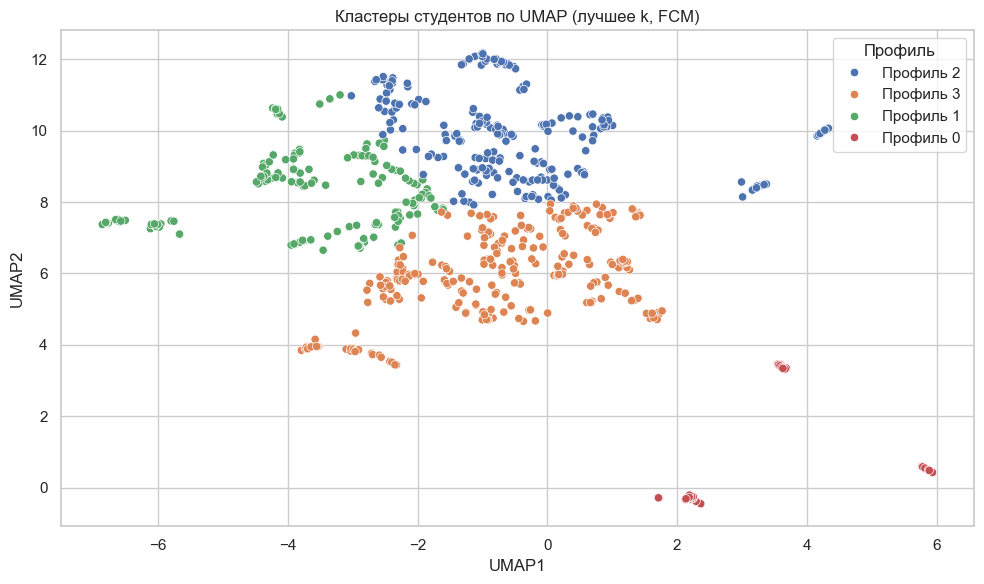

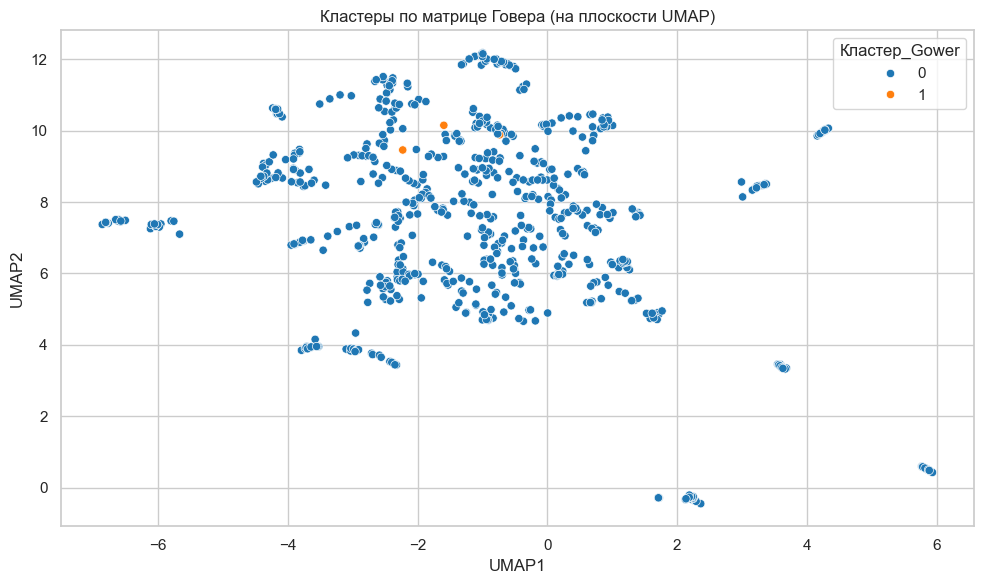

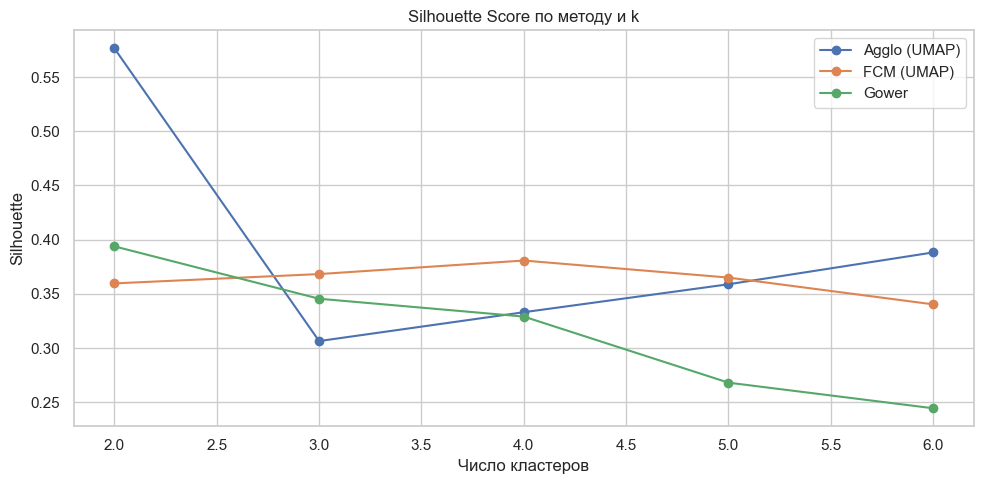

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Профиль", palette="deep")
plt.title("Кластеры студентов по UMAP (лучшее k, FCM)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Кластер_Gower", palette="tab10")
plt.title("Кластеры по матрице Говера (на плоскости UMAP)")
plt.tight_layout()
plt.show()

# Silhouette-график по всем методам
k_values = [r["n_clusters"] for r in results_agglom]
plt.figure(figsize=(10, 5))
plt.plot(k_values, [r["silhouette"] for r in results_agglom], marker='o', label="Agglo (UMAP)")
plt.plot(k_values, [r["silhouette"] for r in results_fcm], marker='o', label="FCM (UMAP)")
plt.plot([r["n_clusters"] for r in results_gower], [r["silhouette"] for r in results_gower], marker='o', label="Gower")
plt.xlabel("Число кластеров")
plt.ylabel("Silhouette")
plt.title("Silhouette Score по методу и k")
plt.legend()
plt.tight_layout()
plt.show()

4.8 Сравнение кластеров: таблица пересечений

In [32]:
# Crosstab для сравнения кластеров FCM и Gower
crosstab = pd.crosstab(df["Кластер_FCM"], df["Кластер_Gower"])
display(crosstab)

Кластер_Gower    0  1
Кластер_FCM          
0               49  0
1              169  0
2              224  3
3              266  0

Пояснения:
Проведена кластеризация с использованием UMAP-признаков и матрицы Говера для бинарных данных.
Оценено качество кластеров с помощью silhouette и Davies-Bouldin.
Лучшие решения сохранены в итоговой таблице, визуализации позволили сравнить интерпретируемость кластеров.
Выведена таблица пересечений кластеров, чтобы сопоставить разбиения разных методов.

5. Оценка качества кластеризации
Цель этапа:
Оценить качество разбиения на кластеры с помощью метрик — Silhouette Score и индекса Davies-Bouldin — для разных методов кластеризации (Agglomerative, Fuzzy C-Means по UMAP, Agglomerative по Говеру), а также визуализировать сравнение.

In [33]:
# 5.1 Импорт библиотек и задание путей

import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import os

INPUT_PATH = "../data/students_with_clusters.csv"
GOWER_MATRIX_PATH = "../data/gower_distance_matrix.npy"
OUTPUT_DIR = "../outputs/evaluate_clustering"
os.makedirs(OUTPUT_DIR, exist_ok=True)

5.2 Загрузка данных и подготовка

In [34]:
print("[1] Загрузка данных с кластерами и признаками...")
df = pd.read_csv(INPUT_PATH)
X = df[["UMAP1", "UMAP2"]].values
display(df.head())

[1] Загрузка данных с кластерами и признаками...


ID На каком факультете/в каком институте Вы обучаетесь?  \
0  1408291245                 институт истории и социальных наук     
1  1405883214                                институт педагогики     
2  1405869646                                институт педагогики     
3  1405856131                                институт педагогики     
4  1405854542                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

   Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                1.0                                                                              
4                                                1.0                                                                              

   Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                0.0                                                                                            
1                                                1.0                                                                                            
2                                                1.0                                                                                            
3                                                1.0                                                                                            
4                                                1.0                                                                                            

   Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                1.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                0.0                                                                              
4                                                0.0                             

5.3 Оценка Silhouette и Davies-Bouldin по UMAP

In [35]:
results = {}

# Оценка кластеров Agglomerative и FCM на UMAP
for label_col in ["Кластер_AC", "Кластер_FCM"]:
    if label_col in df.columns:
        labels = df[label_col].values
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        results[label_col] = {"Silhouette": sil, "Davies-Bouldin": db}
        print(f"{label_col}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}")

Кластер_AC: Silhouette=0.576, Davies-Bouldin=0.562
Кластер_FCM: Silhouette=0.381, Davies-Bouldin=0.821


5.4 Оценка кластеров по Говеру

In [36]:
if "Кластер_Gower" in df.columns:
    labels_gower = df["Кластер_Gower"].values
    gower_distance_matrix = np.load(GOWER_MATRIX_PATH)
    sil_gower = silhouette_score(gower_distance_matrix, labels_gower, metric='precomputed')
    results["Кластер_Gower"] = {"Silhouette": sil_gower, "Davies-Bouldin": np.nan}
    print(f"Кластер_Gower: Silhouette Score (Gower): {sil_gower:.3f}")

Кластер_Gower: Silhouette Score (Gower): 0.394


5.5 Сводка метрик

In [37]:
print("\n[3] Результаты метрик кластеризации:")
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score:     {metrics['Silhouette']:.3f}")
    if not np.isnan(metrics["Davies-Bouldin"]):
        print(f"  Davies-Bouldin Index: {metrics['Davies-Bouldin']:.3f}")


[3] Результаты метрик кластеризации:
Кластер_AC:
  Silhouette Score:     0.576
  Davies-Bouldin Index: 0.562
Кластер_FCM:
  Silhouette Score:     0.381
  Davies-Bouldin Index: 0.821
Кластер_Gower:
  Silhouette Score:     0.394


5.6 Визуализация Silhouette Scores

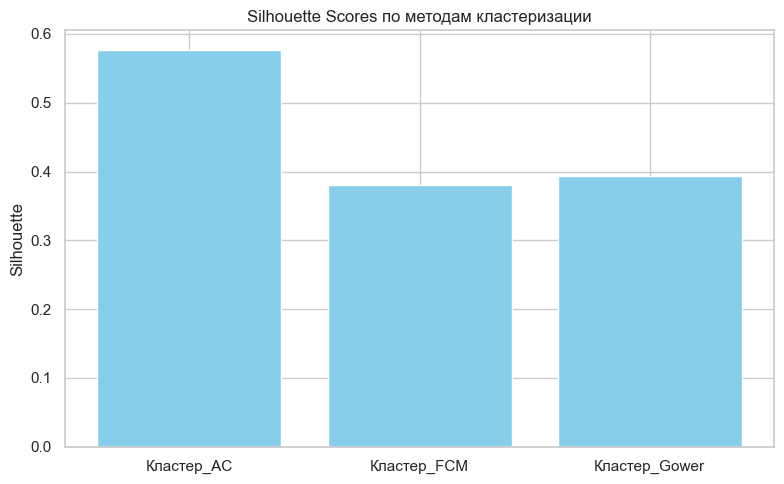

In [38]:
methods = list(results.keys())
sil_scores = [results[m]["Silhouette"] for m in methods]

plt.figure(figsize=(8, 5))
plt.bar(methods, sil_scores, color="skyblue")
plt.title("Silhouette Scores по методам кластеризации")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

5.7 Визуализация Davies-Bouldin Index

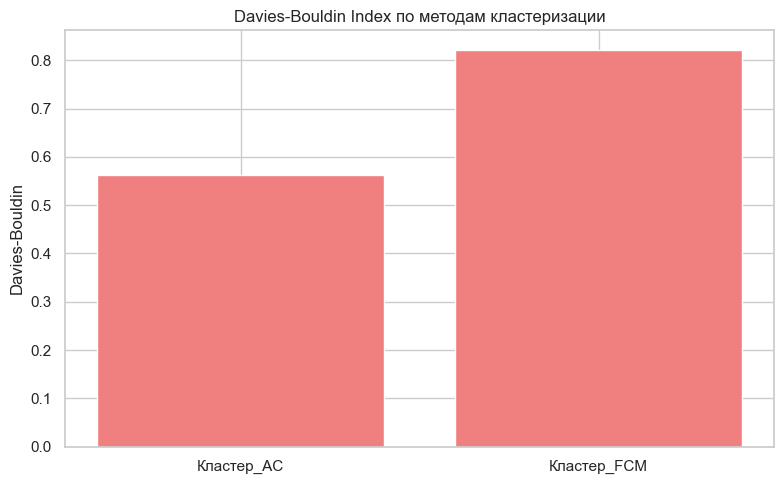

In [39]:
db_methods = [m for m in results if not np.isnan(results[m]["Davies-Bouldin"])]
db_scores = [results[m]["Davies-Bouldin"] for m in db_methods]
if db_scores:
    plt.figure(figsize=(8, 5))
    plt.bar(db_methods, db_scores, color="lightcoral")
    plt.title("Davies-Bouldin Index по методам кластеризации")
    plt.ylabel("Davies-Bouldin")
    plt.tight_layout()
    plt.show()

5.8 Кросстаб: пересечения FCM и Gower

In [40]:
if "Кластер_FCM" in df.columns and "Кластер_Gower" in df.columns:
    crosstab = pd.crosstab(df["Кластер_FCM"], df["Кластер_Gower"])
    display(crosstab)

Кластер_Gower    0  1
Кластер_FCM          
0               49  0
1              169  0
2              224  3
3              266  0

Пояснения:
Silhouette Score: чем выше (максимум 1), тем лучше кластеры отделены друг от друга.
Davies-Bouldin Index: чем ниже, тем лучше; минимальное значение — лучший разрыв между кластерами.
Кросстаб помогает понять, насколько кластеры по разным алгоритмам совпадают.

6. Интерпретация и профилирование кластеров по бинарным признакам
Цель этапа:
Проанализировать и визуализировать, чем отличаются полученные кластеры (профили) студентов на основании бинарных признаков.
Выделить топовые различающие признаки, построить barplot и radar plot, подготовить шаблон интерпретации профилей для отчёта.

In [41]:
# 6.1 Импорт библиотек и настройка путей

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import textwrap

INPUT_PATH = "../outputs/cluster_students_gower_binaries/students_with_clusters_binaries.csv"
CLUSTER_LABEL = "Кластер_Gower"
FACULTY_LABEL = "Факультет"
OUTPUT_DIR = "../outputs/cluster_profiles_gower"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def short_label(label, max_len=30):
    label = str(label)
    return textwrap.shorten(label, width=max_len, placeholder="...")

6.2 Загрузка данных и выделение бинарных признаков

In [42]:
print("[1] Загрузка данных...")
df = pd.read_csv(INPUT_PATH)
binary_cols = [
    col for col in df.columns
    if col not in [CLUSTER_LABEL, FACULTY_LABEL]
    and set(df[col].dropna().unique()).issubset({0,1})
]
print(f"Найдено бинарных признаков: {len(binary_cols)}")

[1] Загрузка данных...
Найдено бинарных признаков: 19


6.3 Групповая статистика по кластерам

In [43]:
profile_table = df.groupby(CLUSTER_LABEL)[binary_cols].mean().T
display(profile_table.head())
profile_table.to_csv(f"{OUTPUT_DIR}/cluster_profile_table.csv")
print(f"Таблица профилей кластеров сохранена ({profile_table.shape[0]} признаков).")

Кластер_Gower                                              0         1
Был ли предусмотрен фидбек (отклик преподавател...  0.850282  1.000000
Необходим ли фидбек (отклик преподавателя на вы...  0.932203  0.666667
Был ли автоматический мониторинг присутствия ст...  0.531073  0.000000
Необходим ли автоматический мониторинг присутст...  0.504237  0.000000
Материалы, представленные для практического зад...  0.915254  0.666667

Таблица профилей кластеров сохранена (19 признаков).


6.4 Выделение TOP N различающих признаков и Barplot

C:\Users\влад\AppData\Local\Temp\ipykernel_8548\3887997025.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


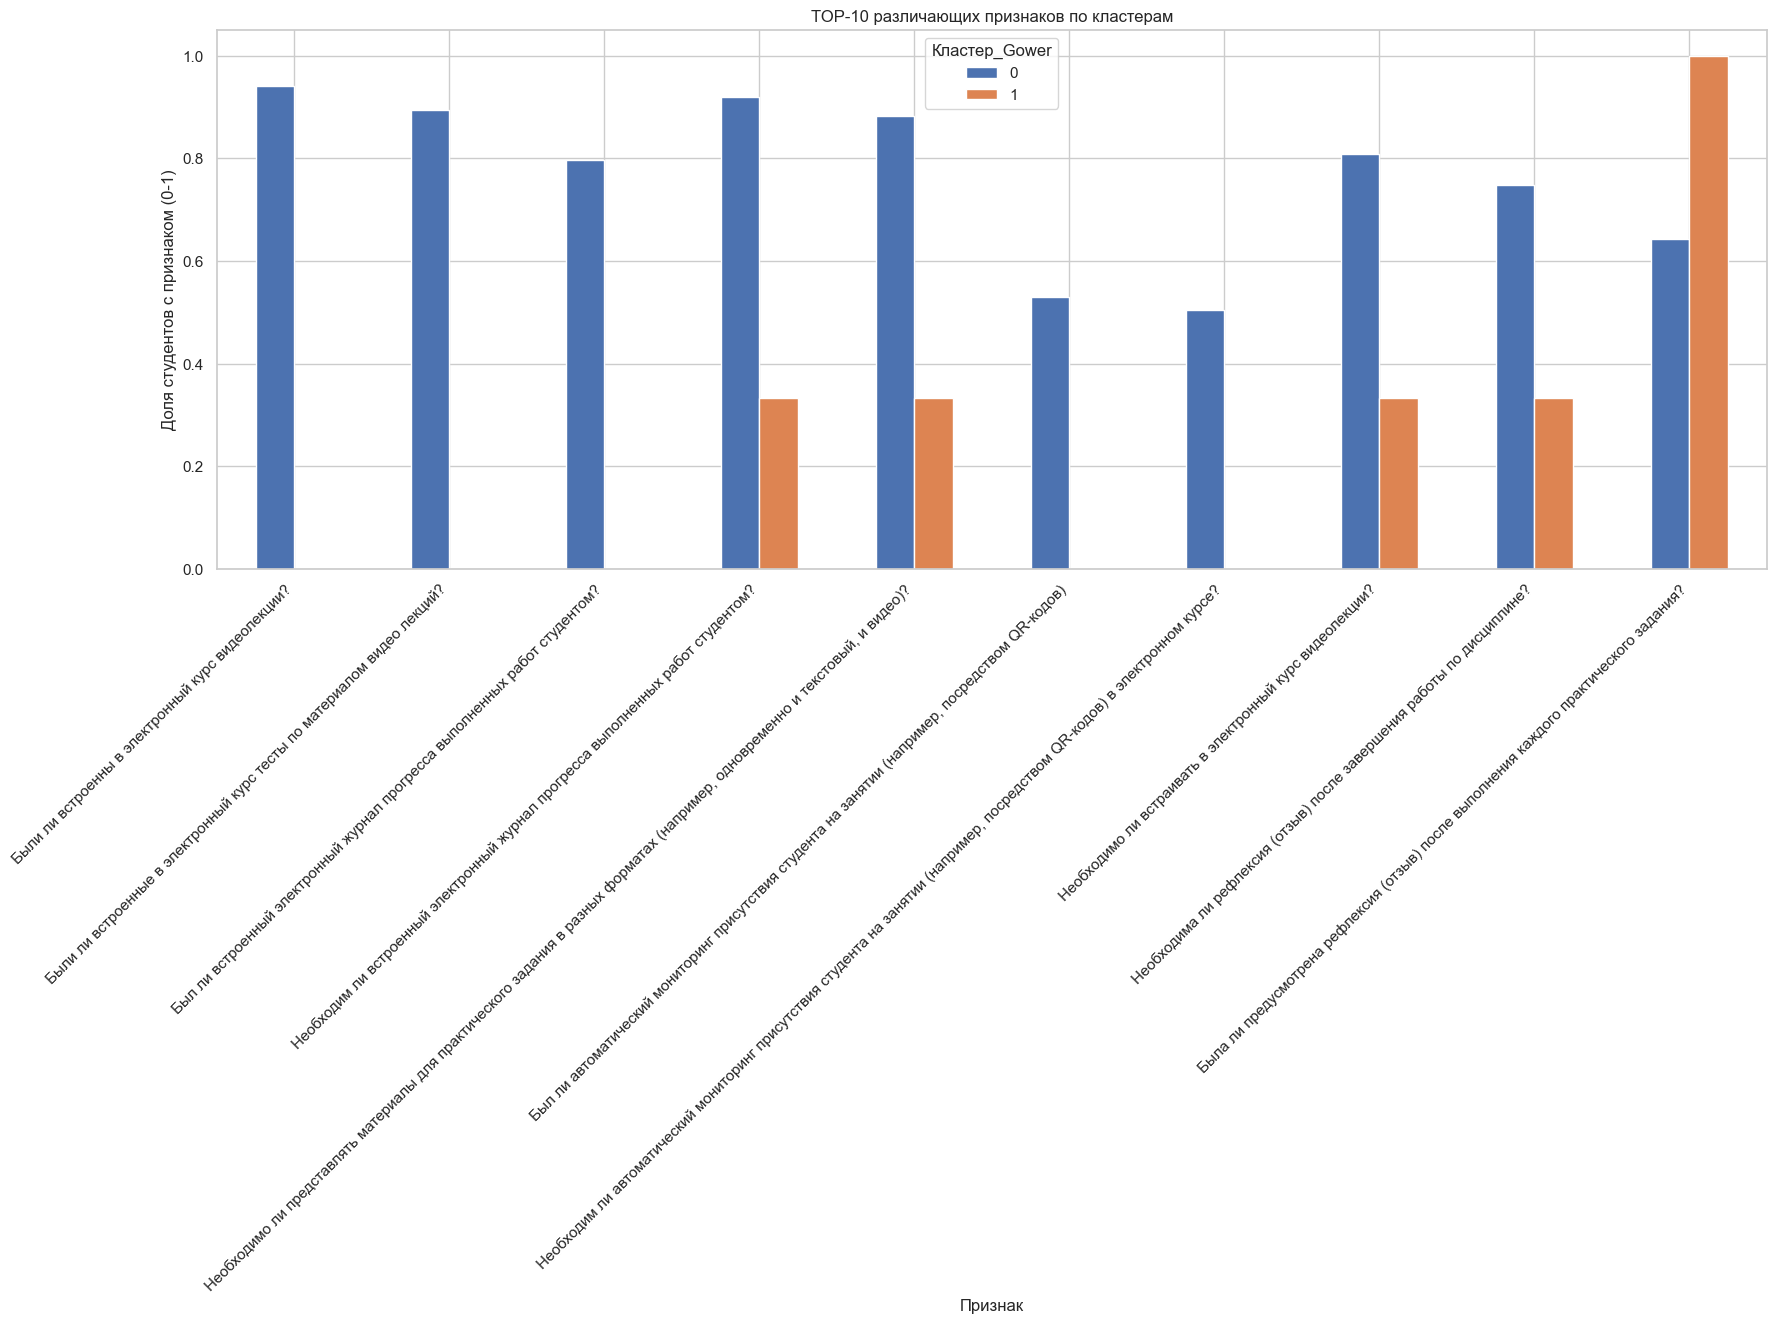

In [44]:
top_n = 10
profile_table["max_diff"] = profile_table.max(axis=1) - profile_table.min(axis=1)
top_features = profile_table.sort_values("max_diff", ascending=False).head(top_n).index.tolist()
profile_table.drop(columns=["max_diff"], inplace=True)

profile_table_top = profile_table.loc[top_features]

profile_table_top.plot(kind="bar", figsize=(20, 7)) #figsize=(12, 7))
plt.title(f"TOP-{top_n} различающих признаков по кластерам")
plt.ylabel("Доля студентов с признаком (0-1)")
plt.xlabel("Признак")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

6.5 Radar plot для всех кластеров (TOP N признаков)

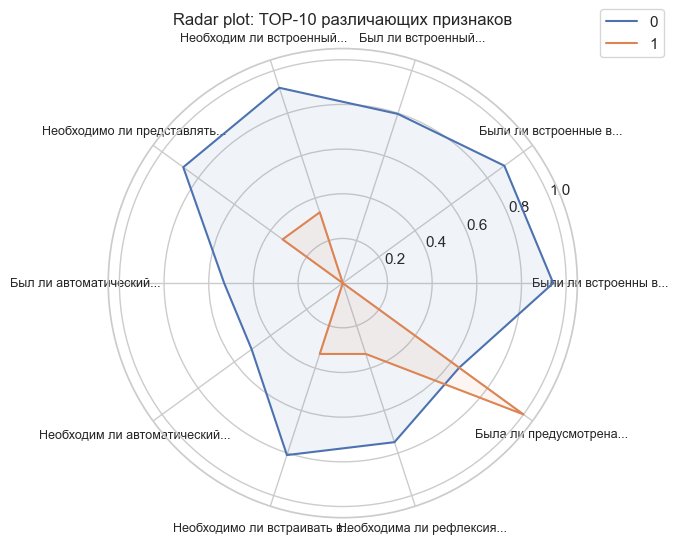

In [45]:
from math import pi

def radar_plot(data, labels, cluster_names=None, title="Radar plot"):
    num_vars = data.shape[0]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
    for idx, col in enumerate(data.columns):
        values = data[col].tolist()
        values += values[:1]
        ax.plot(angles, values, label=f"{cluster_names[idx] if cluster_names else col}")
        ax.fill(angles, values, alpha=0.08)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([short_label(l, 30) for l in labels], fontsize=9)
    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    return fig, ax

radar_data = profile_table_top
fig, ax = radar_plot(radar_data, radar_data.index, title=f"Radar plot: TOP-{top_n} различающих признаков")
plt.show()

6.6 Автоматический шаблон для интерпретации профилей

In [47]:
template_text = []
template_text.append("Шаблон для содержательной интерпретации профилей кластеров\n")
for cl in profile_table.columns:
    template_text.append(f"\nКластер {cl}:")
    top_feat = profile_table_top[cl].sort_values(ascending=False)
    template_text.append("  Наиболее выраженные признаки:")
    for feat, val in top_feat.items():
        if val > 0.6:
            template_text.append(f"    - {short_label(feat)}: {val:.2f}")
    template_text.append("  Наименее выраженные признаки:")
    for feat, val in top_feat.items():
        if val < 0.4:
            template_text.append(f"    - {short_label(feat)}: {val:.2f}")

template_text.append("\nРекомендуется вручную проверить признаки (см. таблицу и графики) и присвоить содержательные названия профилям.")

print("\n".join(template_text))

Шаблон для содержательной интерпретации профилей кластеров


Кластер 0:
  Наиболее выраженные признаки:
    - Были ли встроенны в...: 0.94
    - Необходим ли встроенный...: 0.92
    - Были ли встроенные в...: 0.89
    - Необходимо ли представлять...: 0.88
    - Необходимо ли встраивать в...: 0.81
    - Был ли встроенный...: 0.80
    - Необходима ли рефлексия...: 0.75
    - Была ли предусмотрена...: 0.64
  Наименее выраженные признаки:

Кластер 1:
  Наиболее выраженные признаки:
    - Была ли предусмотрена...: 1.00
  Наименее выраженные признаки:
    - Необходим ли встроенный...: 0.33
    - Необходима ли рефлексия...: 0.33
    - Необходимо ли представлять...: 0.33
    - Необходимо ли встраивать в...: 0.33
    - Были ли встроенны в...: 0.00
    - Были ли встроенные в...: 0.00
    - Был ли встроенный...: 0.00
    - Был ли автоматический...: 0.00
    - Необходим ли автоматический...: 0.00

Рекомендуется вручную проверить признаки (см. таблицу и графики) и присвоить содержательные названия 

Пояснения:
Рассчитаны и визуализированы доли бинарных признаков в каждом кластере.
Топ-10 наиболее различающих признаков помогают быстро увидеть, чем кластеры реально отличаются.
Radar plot наглядно сравнивает профили.
Генерируется текстовый шаблон для содержательной интерпретации и описания результатов.

7. Полярные диаграммы профилей по бинарным признакам
Цель этапа:
Визуализировать различия профилей (кластеров студентов) с помощью полярных (radar) диаграмм, которые показывают средние значения бинарных признаков в каждом профиле.

In [48]:
# 7.1 Импорт библиотек и настройка путей

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

INPUT_PATH = "../data/students_with_clusters.csv"
SOURCE_PATH = "../data/dlia_studentov.xlsx"
OUTPUT_DIR = "../outputs/radar_profiles_from_binary"
os.makedirs(OUTPUT_DIR, exist_ok=True)

7.2 Загрузка кластеров и исходных данных

In [49]:
print("[1] Загрузка кластеров и исходных данных...")
df_clusters = pd.read_csv(INPUT_PATH)
df_raw = pd.read_excel(SOURCE_PATH)

[1] Загрузка кластеров и исходных данных...


7.3 Подготовка бинарных признаков

In [50]:
print("[2] Подготовка бинарных признаков...")
binary_map = {
    "использую": 1, "не использую": 0,
    "использовать": 1, "не использовать": 0,
    "да": 1, "нет": 0,
    "+": 1, "-": 0,
    "yes": 1, "no": 0
}
binary_cols = []

for col in df_raw.columns:
    unique_vals = df_raw[col].dropna().unique()
    if len(unique_vals) <= 3 and all(str(x).strip().lower() in binary_map for x in unique_vals):
        df_raw[col] = df_raw[col].map(lambda x: binary_map.get(str(x).strip().lower(), np.nan))
        binary_cols.append(col)

print(f"Найдено бинарных признаков: {len(binary_cols)}")
if not binary_cols:
    raise ValueError("Не найдено бинарных признаков для анализа профилей.")

[2] Подготовка бинарных признаков...
Найдено бинарных признаков: 19


7.4 Совмещение кластеров с бинарными признаками

In [51]:
print("[3] Совмещение кластеров с бинарными признаками...")
df = df_raw.copy()
df["Профиль"] = df_clusters["Профиль"]


[3] Совмещение кластеров с бинарными признаками...


7.5 Построение полярных диаграмм по профилям


[4] Построение полярных диаграмм профилей по бинарным признакам...


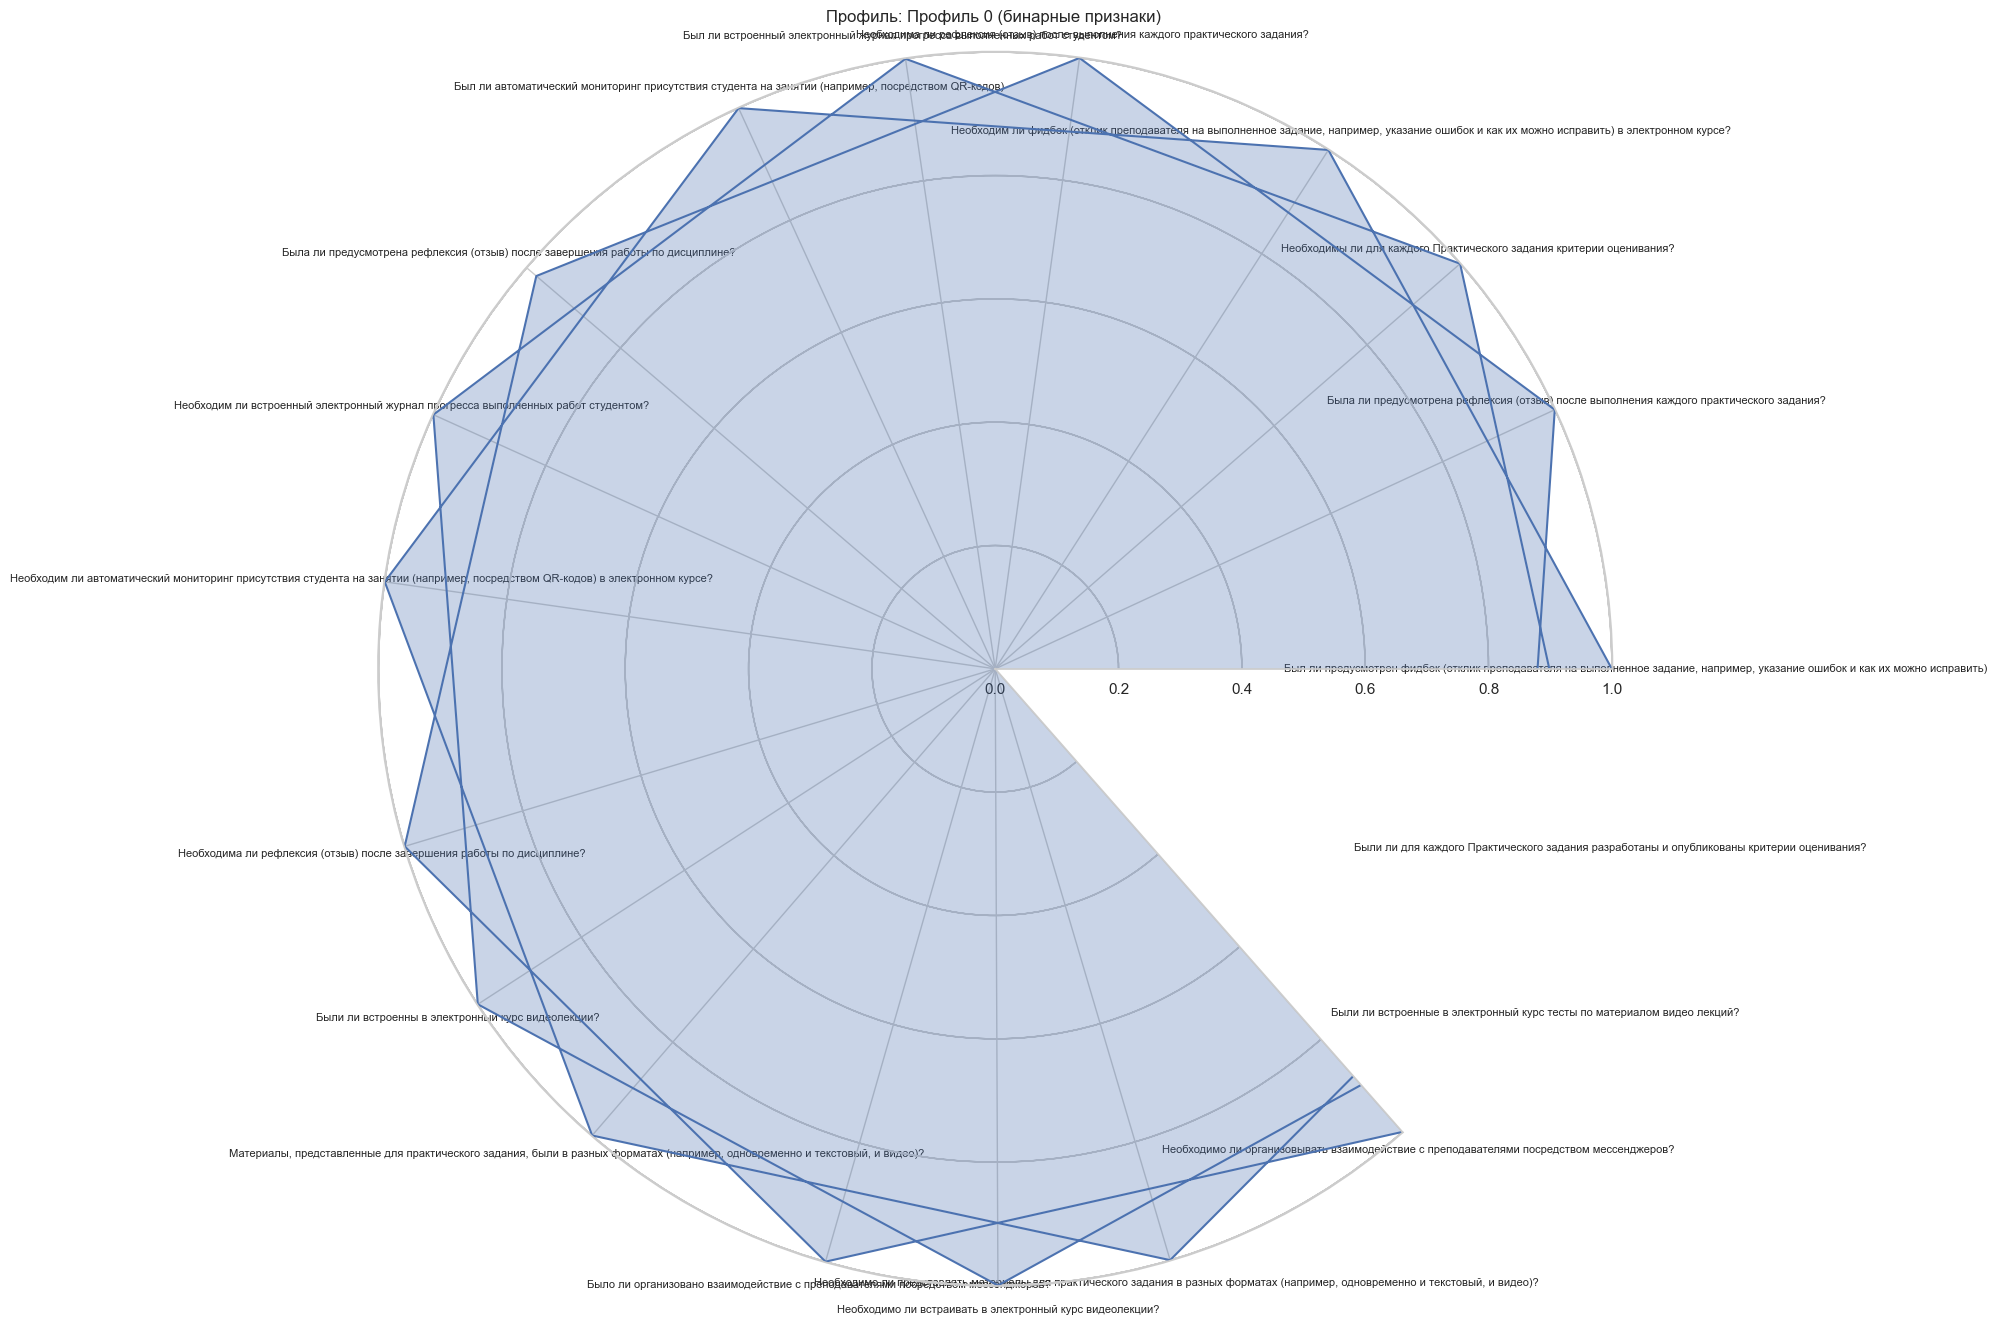

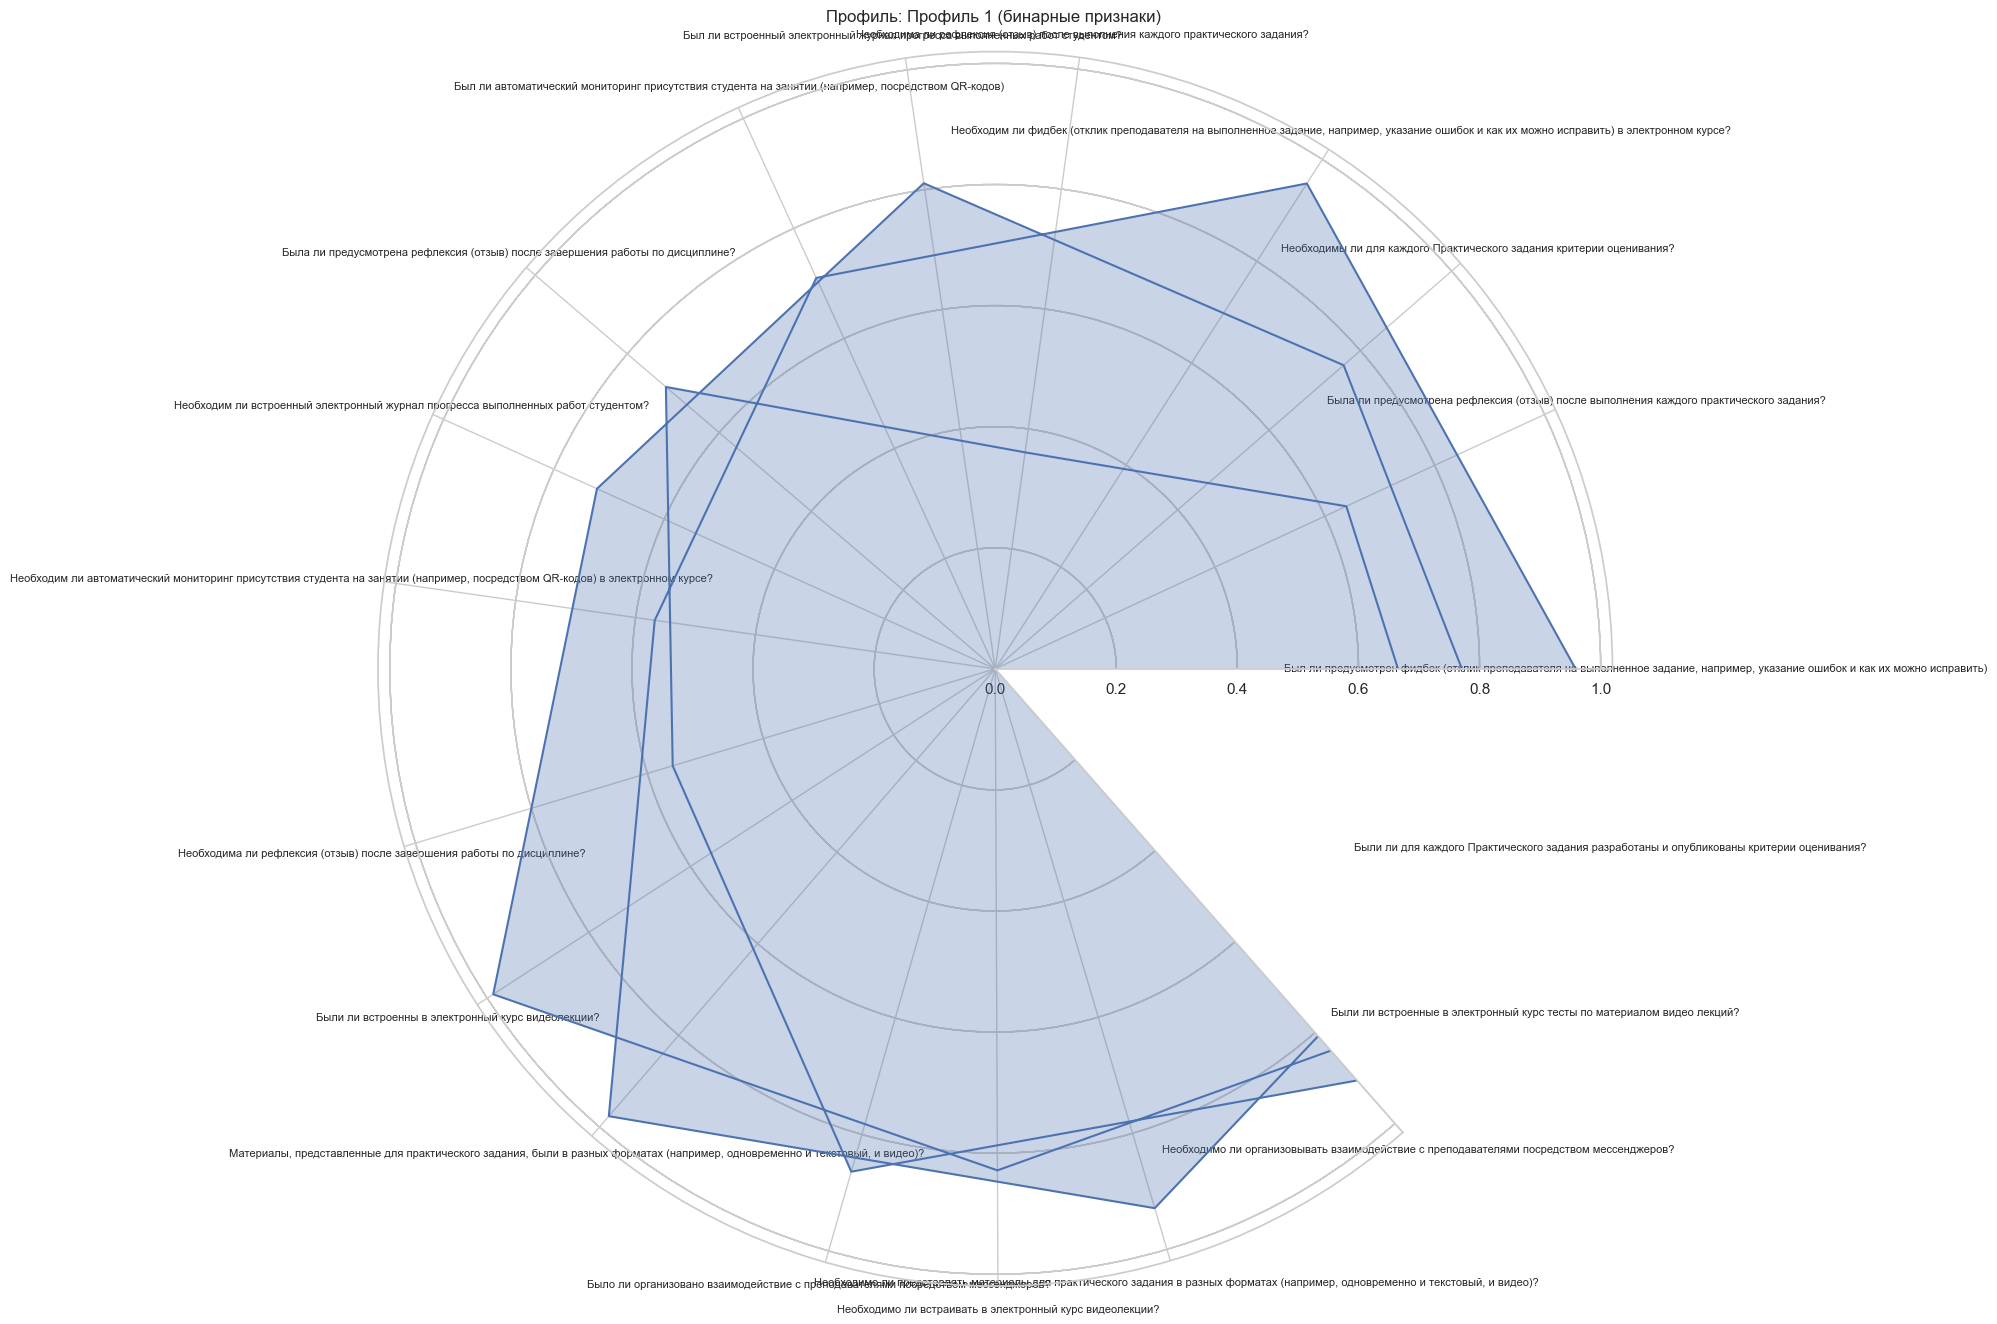

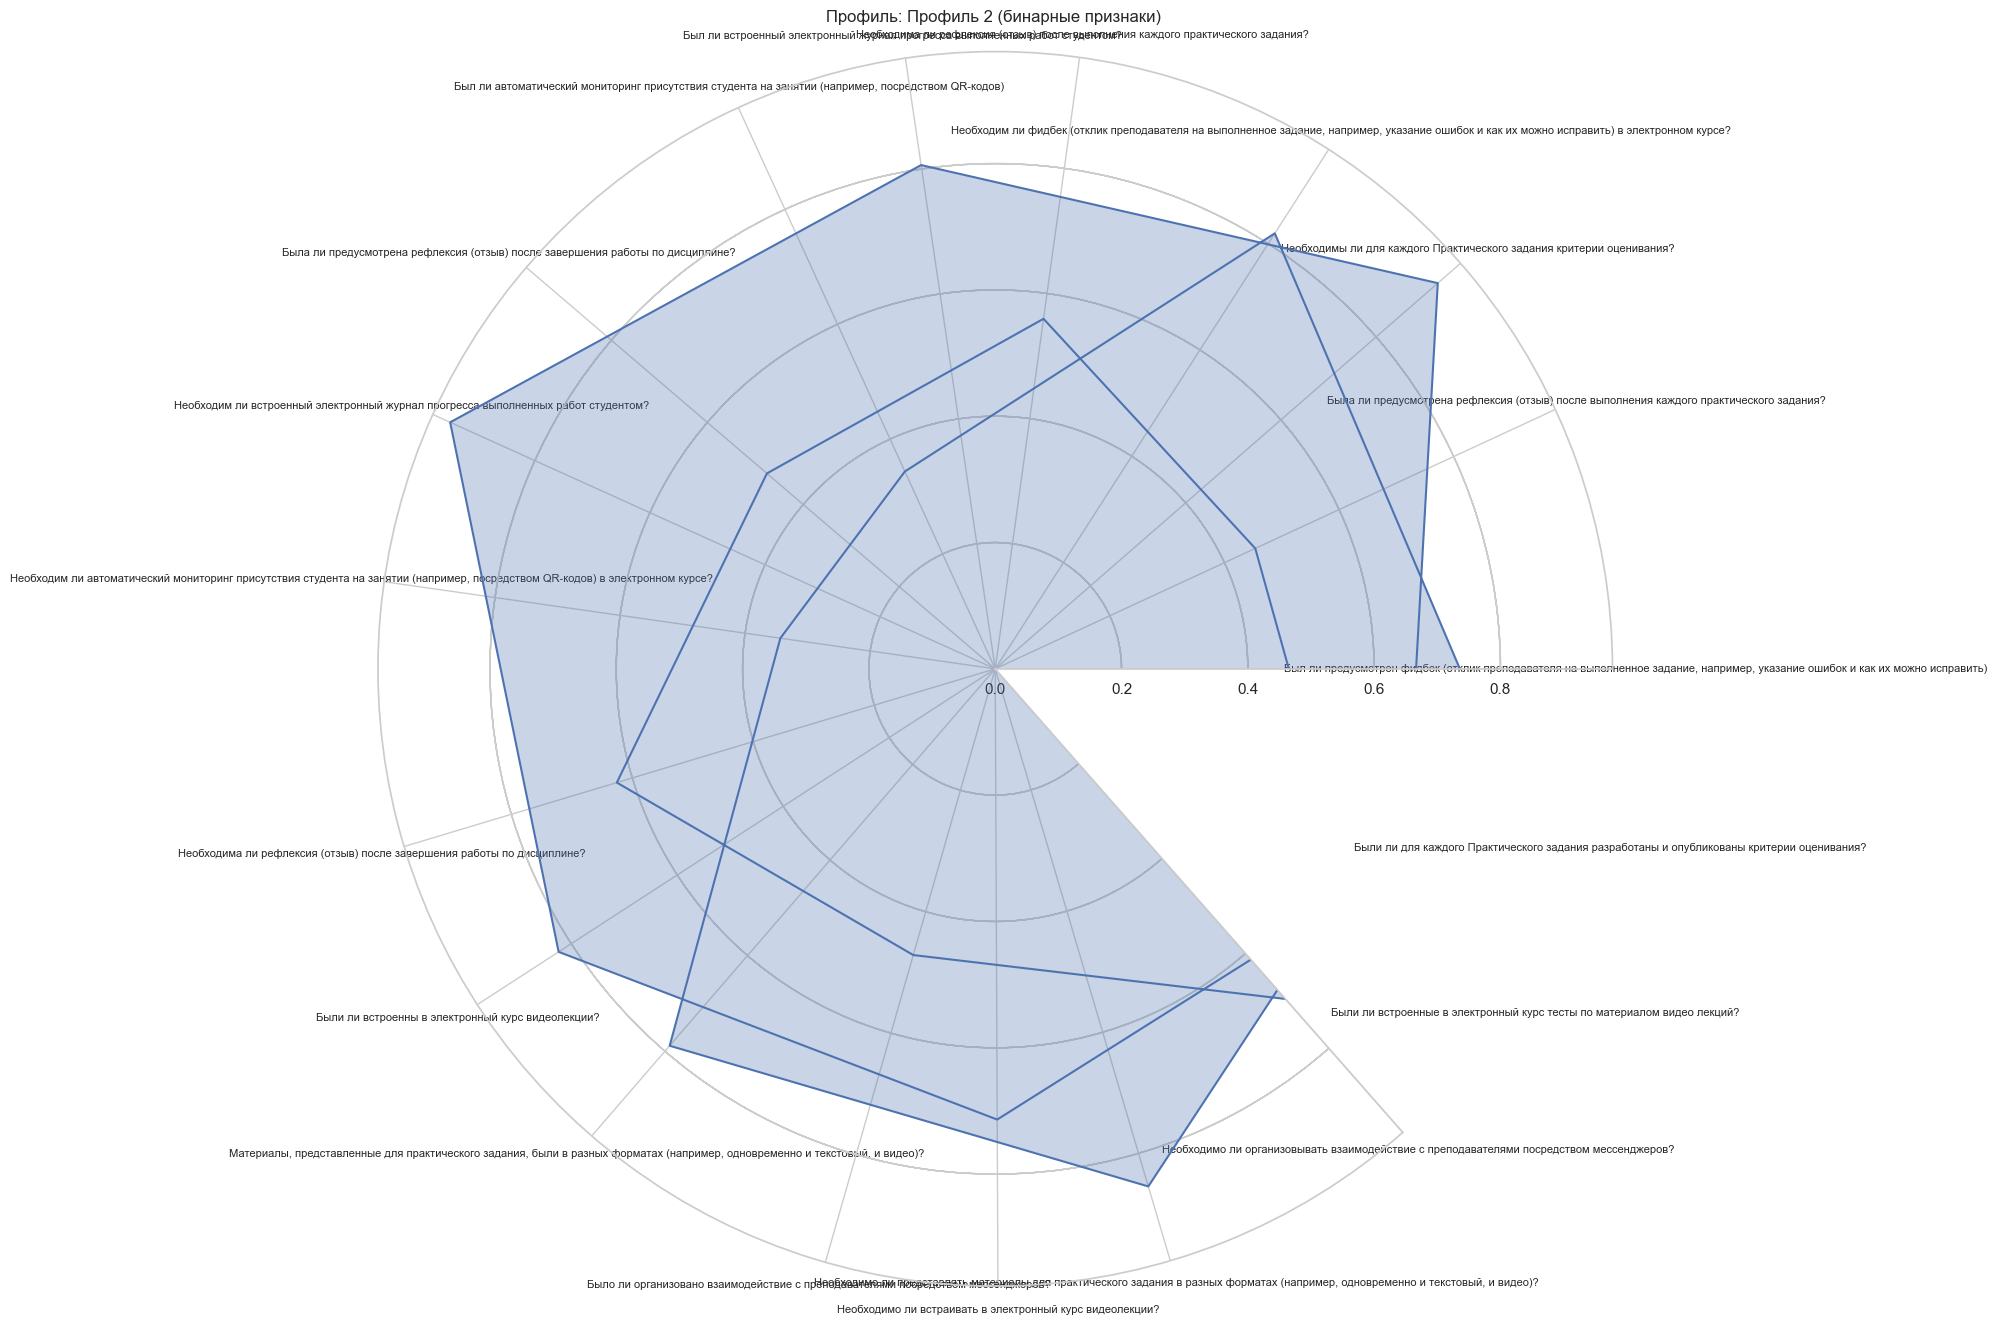

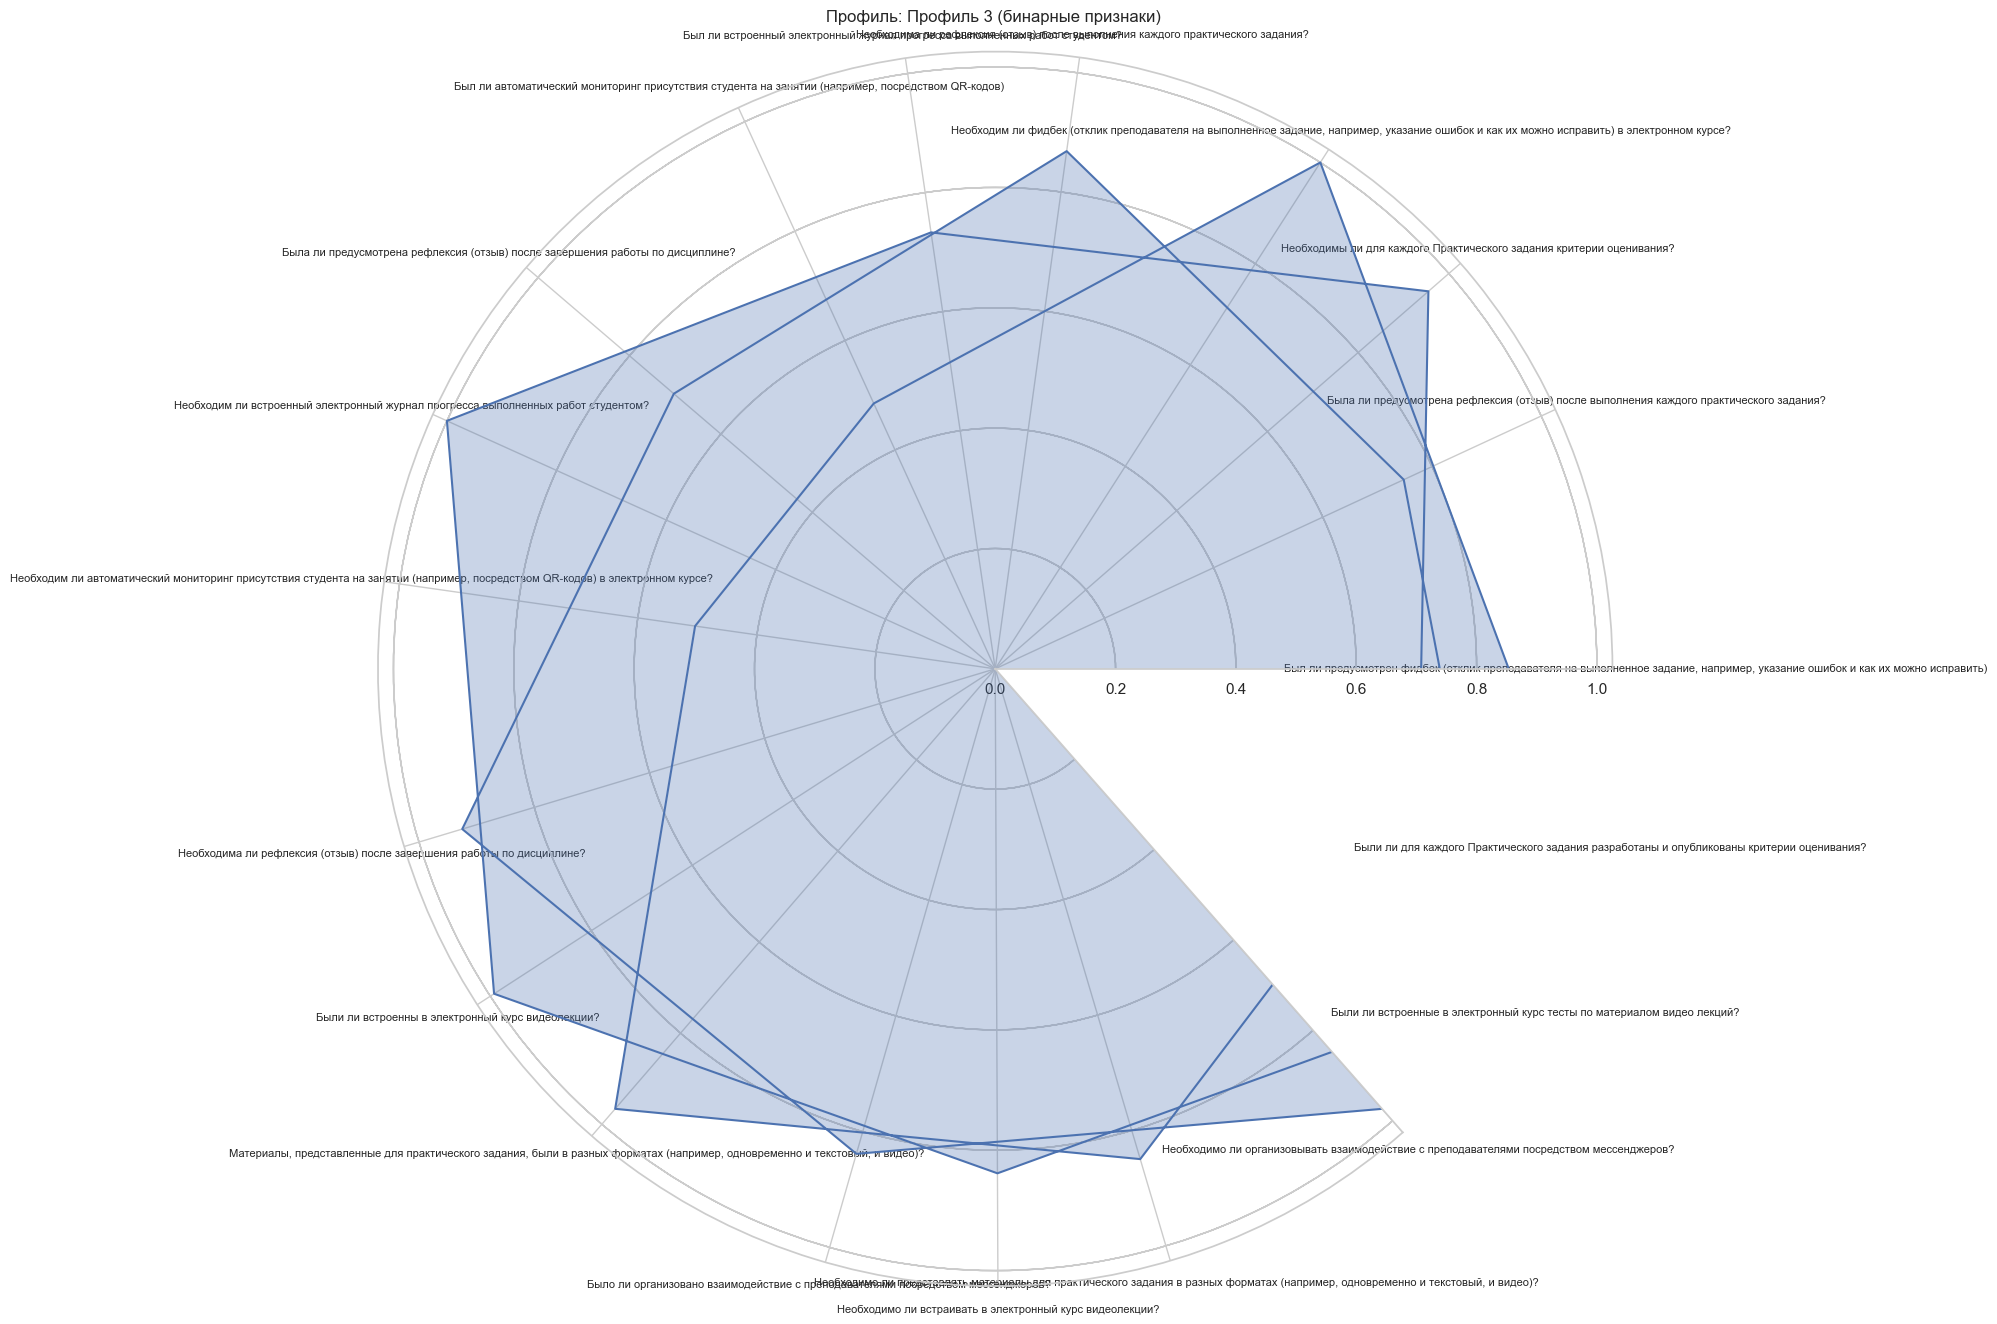

In [52]:
print("[4] Построение полярных диаграмм профилей по бинарным признакам...")

avg_by_profile = df.groupby("Профиль")[binary_cols].mean().T
labels = avg_by_profile.index.tolist()
angles = list(range(len(labels))) + [0]  # замыкаем круг

for profile in avg_by_profile.columns:
    values = avg_by_profile[profile].tolist() + [avg_by_profile[profile].iloc[0]]
    plt.figure(figsize=(20, 20)) #(12, 12))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, label=profile)
    ax.fill(angles, values, alpha=0.3)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8, rotation=45) # fontsize=10, rotation=45)
    plt.title(f"Профиль: {profile} (бинарные признаки)")
    plt.tight_layout()
    plt.show()

Пояснения:
Каждый график показывает «средний» бинарный профиль студентов одного кластера.
Позволяет визуально сравнить профили и выявить ключевые отличия между группами.
Чем дальше от центра — тем выше доля студентов, отмечающих признак (например, использование ИИ, LMS и т.д.).

8. Построение и оценка классификатора профиля кластера
Цель этапа:
Обучить и оценить модели для автоматического предсказания профиля (кластера) студента на основе исходных признаков анкеты.
Провести сравнение трёх моделей (DecisionTree, RandomForest, MLP), проанализировать важность признаков, подготовить модели для дальнейшей генерации рекомендаций.

In [53]:
# 8.1 Импорт библиотек и настройка путей

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

INPUT_PATH = "../data/students_with_clusters.csv"
MODEL_DIR = "../models"
OUTPUT_DIR = "../outputs/train_classifier"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

8.2 Загрузка данных с кластерами

In [54]:
print("[1] Загрузка данных с кластерами...")
df = pd.read_csv(INPUT_PATH)
display(df.head())

[1] Загрузка данных с кластерами...


ID На каком факультете/в каком институте Вы обучаетесь?  \
0  1408291245                 институт истории и социальных наук     
1  1405883214                                институт педагогики     
2  1405869646                                институт педагогики     
3  1405856131                                институт педагогики     
4  1405854542                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

   Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                1.0                                                                              
4                                                1.0                                                                              

   Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                0.0                                                                                            
1                                                1.0                                                                                            
2                                                1.0                                                                                            
3                                                1.0                                                                                            
4                                                1.0                                                                                            

   Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                0.0                                                   
1                                                0.0                                                   
2                                                1.0                                                   
3                                                0.0                                                   
4                                                0.0                                                   

   Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                0.0                                                                              
1                                                1.0                                                                              
2                                                1.0                                                                              
3                                                0.0                                                                              
4                                                0.0                             

8.3 Подготовка признаков

In [55]:
# Целевая переменная — Кластер_FCM
y = df["Кластер_FCM"]

print("[2] Подготовка признаков...")
exclude_cols = ["Кластер_AC", "Кластер_FCM", "Кластер_Gower", "UMAP1", "UMAP2", "Профиль"]
feature_candidates = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[[col for col in feature_candidates if col not in exclude_cols]]

feature_names = X.columns.tolist()
print(f"Число признаков до отбора: {len(feature_names)}")

[2] Подготовка признаков...
Число признаков до отбора: 20


8.4 Масштабирование и отбор признаков


In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X_scaled)

mask = selector.get_support()
selected_feature_names = [name for name, flag in zip(feature_names, mask) if flag]
print(f"Число признаков после отбора: {len(selected_feature_names)}")

Число признаков после отбора: 20


8.5 Деление на train/test

In [57]:
print("[3] Деление на train/test...")
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

[3] Деление на train/test...


8.6 Обучение моделей и вывод метрик

[4] Обучение моделей...

>>> Обучение модели DecisionTree...
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.82      0.82      0.82        34
           2       0.84      0.83      0.84        46
           3       0.78      0.75      0.77        53

    accuracy                           0.80       143
   macro avg       0.79      0.83      0.80       143
weighted avg       0.81      0.80      0.80       143

F1_macro (5-fold CV): 0.812 ± 0.094
Модель DecisionTree сохранена в model_DecisionTree.pkl

>>> Обучение модели RandomForest...
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.91      0.94      0.93        34
           2       0.96      0.96      0.96        46
           3       0.96      0.92      0.94        53

    accuracy                           0.94       143
   macro avg       0.94      0.96      0.94       

C:\Users\влад\AppData\Local\Temp\ipykernel_8548\1446064788.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


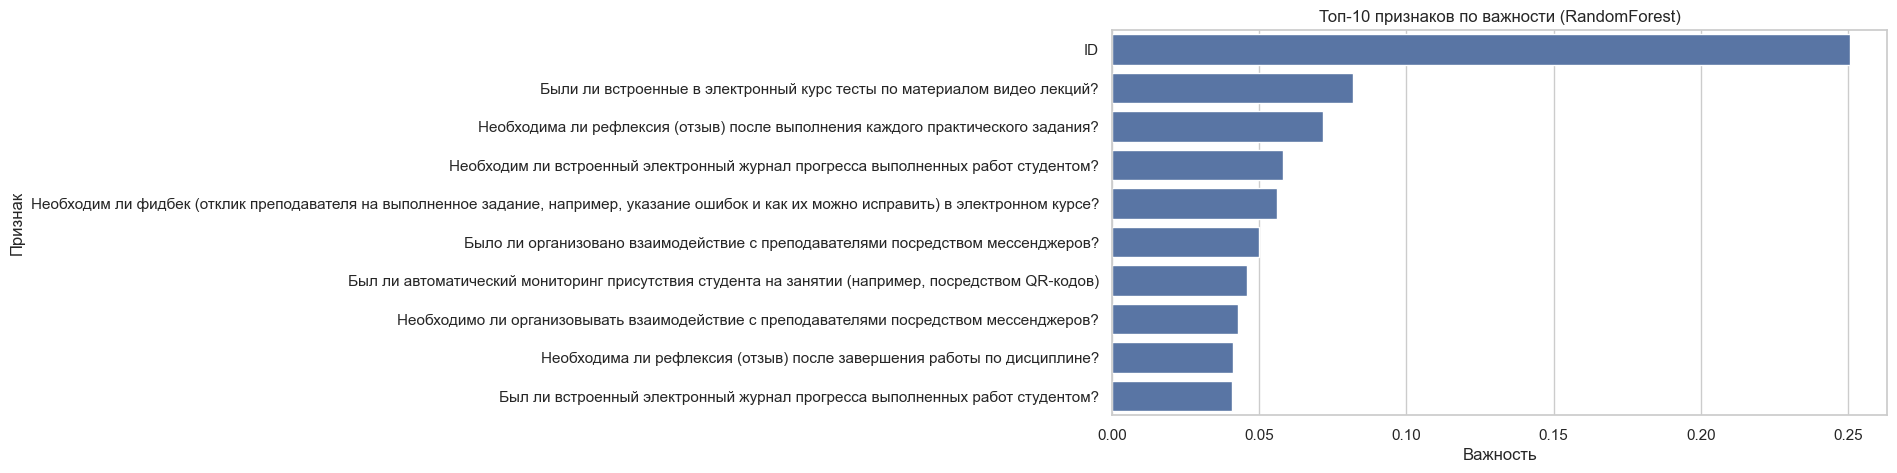

C:\Users\влад\AppData\Local\Temp\ipykernel_8548\1446064788.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


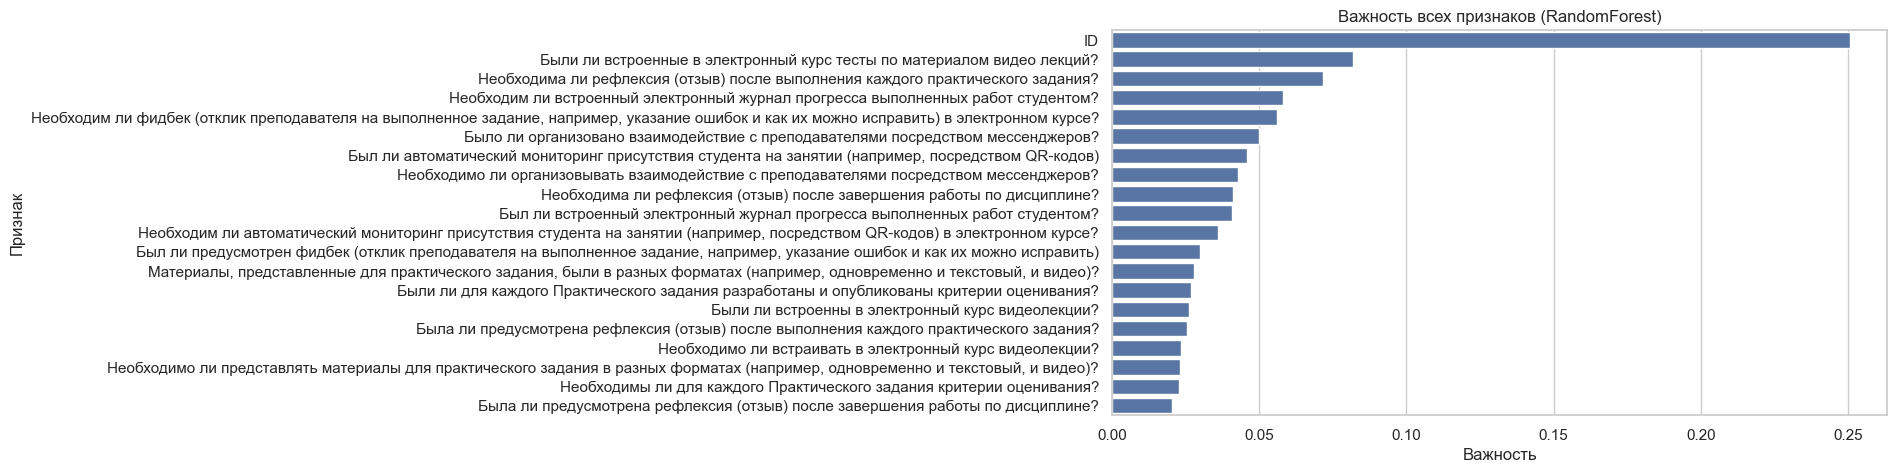

c:\Users\влад\Desktop\vkr_project main!!!\vkrenv_win\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[!] Важность признаков визуализирована.

>>> Обучение модели MLP...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.80      0.59      0.68        34
           2       0.93      0.83      0.87        46
           3       0.65      0.94      0.77        53

    accuracy                           0.76       143
   macro avg       0.59      0.59      0.58       143
weighted avg       0.73      0.76      0.73       143



c:\Users\влад\Desktop\vkr_project main!!!\vkrenv_win\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\влад\Desktop\vkr_project main!!!\vkrenv_win\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_macro (5-fold CV): 0.553 ± 0.130
Модель MLP сохранена в model_MLP.pkl


In [58]:
print("[4] Обучение моделей...")
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, early_stopping=True, random_state=42)
}

for name, model in models.items():
    print(f"\n>>> Обучение модели {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Кросс-валидация
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='f1_macro')
    print(f"F1_macro (5-fold CV): {scores.mean():.3f} ± {scores.std():.3f}")

    # Сохраняем модель и признаки для генерации рекомендаций
    joblib.dump((scaler, selector, model, selected_feature_names), os.path.join(MODEL_DIR, f"model_{name}.pkl"))
    print(f"Модель {name} сохранена в model_{name}.pkl")

    # Анализ важности признаков для RandomForest
    if name == "RandomForest":
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=selected_feature_names)
        feat_imp_sorted = feat_imp.sort_values(ascending=False)
        feat_imp_sorted.to_csv(os.path.join(OUTPUT_DIR, "feature_importance_randomforest.csv"))

        plt.figure(figsize=(10, 5))
        sns.barplot(x=feat_imp_sorted.values[:10], y=feat_imp_sorted.index[:10], orient="h")
        plt.title("Топ-10 признаков по важности (RandomForest)")
        plt.xlabel("Важность")
        plt.ylabel("Признак")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, max(4, len(feat_imp_sorted)//4)))
        sns.barplot(x=feat_imp_sorted.values, y=feat_imp_sorted.index, orient="h")
        plt.title("Важность всех признаков (RandomForest)")
        plt.xlabel("Важность")
        plt.ylabel("Признак")
        plt.tight_layout()
        plt.show()
        print("[!] Важность признаков визуализирована.")

Пояснения:
Для каждой модели показан отчёт по качеству (precision, recall, f1-score) и средний F1_macro по кросс-валидации.
Сохраняется модель и список отобранных признаков (для следующего этапа — генерации рекомендаций).
Для RandomForest выводится топ-10 самых важных признаков (можно использовать для интерпретации моделей).

9. Генерация персонализированных рекомендаций на основе профиля (GigaChat API)
Цель этапа:
На основании анкеты нового студента и обученной модели определить его профиль и автоматически сформировать индивидуальные рекомендации по цифровому развитию с помощью GigaChat API.

In [59]:
# 9.1 Импорт библиотек и настройка путей

import pandas as pd
import numpy as np
import joblib
import requests
from fpdf import FPDF
import os
import uuid
import base64

MODEL_PATH = "models/model_RandomForest.pkl"
FEATURES_PATH = "data/students_with_clusters.csv"
NEW_FORM_PATH = "data/example_student.xlsx"
OUTPUT_TXT = "outputs/reports/gigachat_recommendations.txt"
OUTPUT_PDF = "outputs/reports/gigachat_recommendations.pdf"

9.2 Получение токена и подготовка API

In [60]:
import requests
import uuid
from urllib.parse import urlencode
import urllib3

GIGACHAT_AUTH_KEY = "Basic M2Y2OTAwNGEtZTI5ZS00ODExLTk5MGYtZGQwMDBiYmJmYWE2OmIxZjllMGQxLTgzNWQtNGYzMS05YjJiLTEzZDMzNDBlZGJiMQ=="  # ВСТАВЬ СЮДА!
GIGACHAT_SCOPE = "GIGACHAT_API_PERS"

print("[0] Получение Access Token от GigaChat...")
oauth_url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"
oauth_headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "application/json",
    "RqUID": str(uuid.uuid4()),
    "Authorization": GIGACHAT_AUTH_KEY  # НЕ МЕНЯТЬ!
}
oauth_data = {
    "scope": GIGACHAT_SCOPE
}

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

data_encoded = urlencode(oauth_data)
oauth_response = requests.post(
    oauth_url,
    headers=oauth_headers,
    data=data_encoded.encode('utf-8'),
    verify=False
)

if oauth_response.status_code != 200:
    print("Ошибка:", oauth_response.status_code)
    print(oauth_response.text)
    raise Exception(f"Не удалось получить токен: {oauth_response.status_code} — {oauth_response.text}")

GIGACHAT_ACCESS_TOKEN = oauth_response.json()["access_token"]
print("[✔] Access Token получен")


[0] Получение Access Token от GigaChat...
[✔] Access Token получен


9.3 Загрузка модели и данных, предсказание профиля

In [61]:
import os
import joblib

MODEL_PATH = "../models/model_RandomForest.pkl"

print("Текущая рабочая директория:", os.getcwd())

# Проверяем наличие модели по относительному пути
if not os.path.exists(MODEL_PATH):
    print(f"Файл модели не найден: {MODEL_PATH}")
    print("Возможные причины:")
    print("- Модель не обучалась или не была сохранена")
    print("- Неправильный путь относительно рабочей директории")
    print("Содержимое ../models/:", os.listdir("../models") if os.path.exists("../models") else "нет папки")
else:
    print("[1] Загрузка модели и признаков...")
    scaler, selector, model, selected_feature_names = joblib.load(MODEL_PATH)
    print(f"[INFO] Признаки, используемые для классификации: {selected_feature_names}")

    import pandas as pd
    NEW_FORM_PATH = "../data/example_student.xlsx"
    df_new = pd.read_excel(NEW_FORM_PATH)
    for col in selected_feature_names:
        if col not in df_new.columns:
            df_new[col] = 0
    df_new = df_new[selected_feature_names]

    X_scaled = scaler.transform(df_new)
    X_selected = selector.transform(X_scaled)
    pred_cluster = model.predict(X_selected)[0]

    profile_names = {
        0: "Цифровые скептики",
        1: "Умеренно вовлечённые",
        2: "Цифровые энтузиасты"
    }
    profile = profile_names.get(pred_cluster, "Неизвестно")
    print("Профиль студента:", profile)


Текущая рабочая директория: c:\Users\влад\Desktop\vkr_project main!!!\scripts
[1] Загрузка модели и признаков...
[INFO] Признаки, используемые для классификации: ['ID', 'Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)', 'Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?', 'Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)', 'Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?', 'Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?', 'Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?', 'Были ли для каждого Практического задания разработаны и опубликованы крите

9.4 Генерация prompt и вызов GigaChat

In [62]:
prompt = f"""
Ты — цифровой наставник для студента. Твоя задача — на основе его профиля и анкеты
сформировать **3 индивидуальные рекомендации по цифровому саморазвитию** в образовательной среде.

Профиль студента: {profile}
Анкета студента (признаки использования цифровых инструментов):
{df_new.iloc[0].to_dict()}

Учитывай:
- слабые стороны профиля (например, низкое использование ИИ или LMS),
- особенности ответов анкеты (например, что студент не использует видеоплатформы или цифровые опросы),
- рекомендации должны быть реалистичны и применимы студенту,
- избегай общих фраз — используй конкретные предложения: какие инструменты, как использовать, зачем это поможет.

Выведи только 3 чёткие рекомендации.
"""

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {GIGACHAT_ACCESS_TOKEN}"
}
json_data = {
    "model": "GigaChat:latest",
    "messages": [
        {"role": "system", "content": "Ты эксперт в цифровом обучении."},
        {"role": "user", "content": prompt}
    ]
}

response = requests.post(
    "https://gigachat.devices.sberbank.ru/api/v1/chat/completions",
    headers=headers,
    json=json_data,
    timeout=60,
    verify=False
)

if response.status_code == 200:
    recommendations_text = response.json()["choices"][0]["message"]["content"]
    print("\n[✔] Получены рекомендации:\n")
    print(recommendations_text)
else:
    print("[✖] Ошибка при запросе к GigaChat API:", response.status_code)
    print(response.text)
    recommendations_text = ""


[✔] Получены рекомендации:

### Рекомендации по цифровому саморазвитию для студента с профилем "Цифровые энтузиасты"

#### 1. Внедрите искусственный интеллект для анализа текста
Студент уже проявляет интерес к цифровым технологиям, но может не знать о возможностях ИИ для обработки текста. Предложите ему использовать инструменты ИИ, такие как ChatGPT или другие генеративные языковые модели, чтобы улучшить свои навыки письма и анализа информации. Это также позволит автоматизировать рутинные задачи и повысить эффективность обучения.

#### 2. Используйте видеолекции и вебинары для углубленного изучения тем
Хотя студент уже знаком с видеолекциями, предложите ему расширить этот опыт, включая просмотр вебинаров от экспертов в своей области. Вебинары могут предложить более интерактивный формат обучения и возможность общения с профессионалами отрасли.

#### 3. Включите виртуальную реальность для визуализации сложных концепций
Предложите студенту попробовать VR-технологии для лучшего понимания 

9.5 Сохранение результата

In [63]:
OUTPUT_TXT = "../outputs/reports/gigachat_recommendations.txt"
os.makedirs(os.path.dirname(OUTPUT_TXT), exist_ok=True)
with open(OUTPUT_TXT, "w", encoding="utf-8") as f:
    f.write(recommendations_text)
print(f"Сохранено в {OUTPUT_TXT}")

Сохранено в ../outputs/reports/gigachat_recommendations.txt


Сохранение в PDF


In [64]:
import os

OUTPUT_PDF = "../outputs/reports/gigachat_recommendations.pdf"
os.makedirs(os.path.dirname(OUTPUT_PDF), exist_ok=True)

font_path = "DejaVuSans.ttf"
if not os.path.exists(font_path):
    print("Файл DejaVuSans.ttf не найден. PDF не будет создан.")
else:
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    pdf.add_font("DejaVu", fname=font_path, uni=True)
    pdf.set_font("DejaVu", size=12)
    pdf.cell(200, 10, txt=f"Профиль: {profile}", ln=True)
    pdf.ln(5)
    for line in recommendations_text.split('\n'):
        pdf.multi_cell(0, 10, txt=line)
    pdf.output(OUTPUT_PDF)
    print(f"Сохранено в {OUTPUT_PDF}")


Сохранено в ../outputs/reports/gigachat_recommendations.pdf


Пояснения:
Этот блок — финал всей автоматизации: профиль определяется автоматически, рекомендации формируются с помощью ИИ (GigaChat).
Текст рекомендаций можно использовать в отчёте, письме студенту, презентации.

10. Анализ распределения цифровых профилей по факультетам и автоматическая интерпретация
Цель этапа:
Проанализировать, как распределяются цифровые профили студентов между факультетами, визуализировать результаты и автоматически сформировать текстовые описания для отчёта.

In [ ]:
# === Импорт библиотек и настройка путей ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Пути
INPUT_PATH = "../data/students_with_clusters.csv"
OUTPUT_DIR = "../outputs/analyze_faculties"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("[1] Загрузка данных...")
df = pd.read_csv(INPUT_PATH)
print("Данные загружены:", df.shape)


10.2 Распределение профилей по факультетам

[2] Подготовка данных по факультетам...
[3] Визуализация распределения профилей по факультетам...


C:\Users\влад\AppData\Local\Temp\ipykernel_8548\3110104100.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1600x800 with 0 Axes>

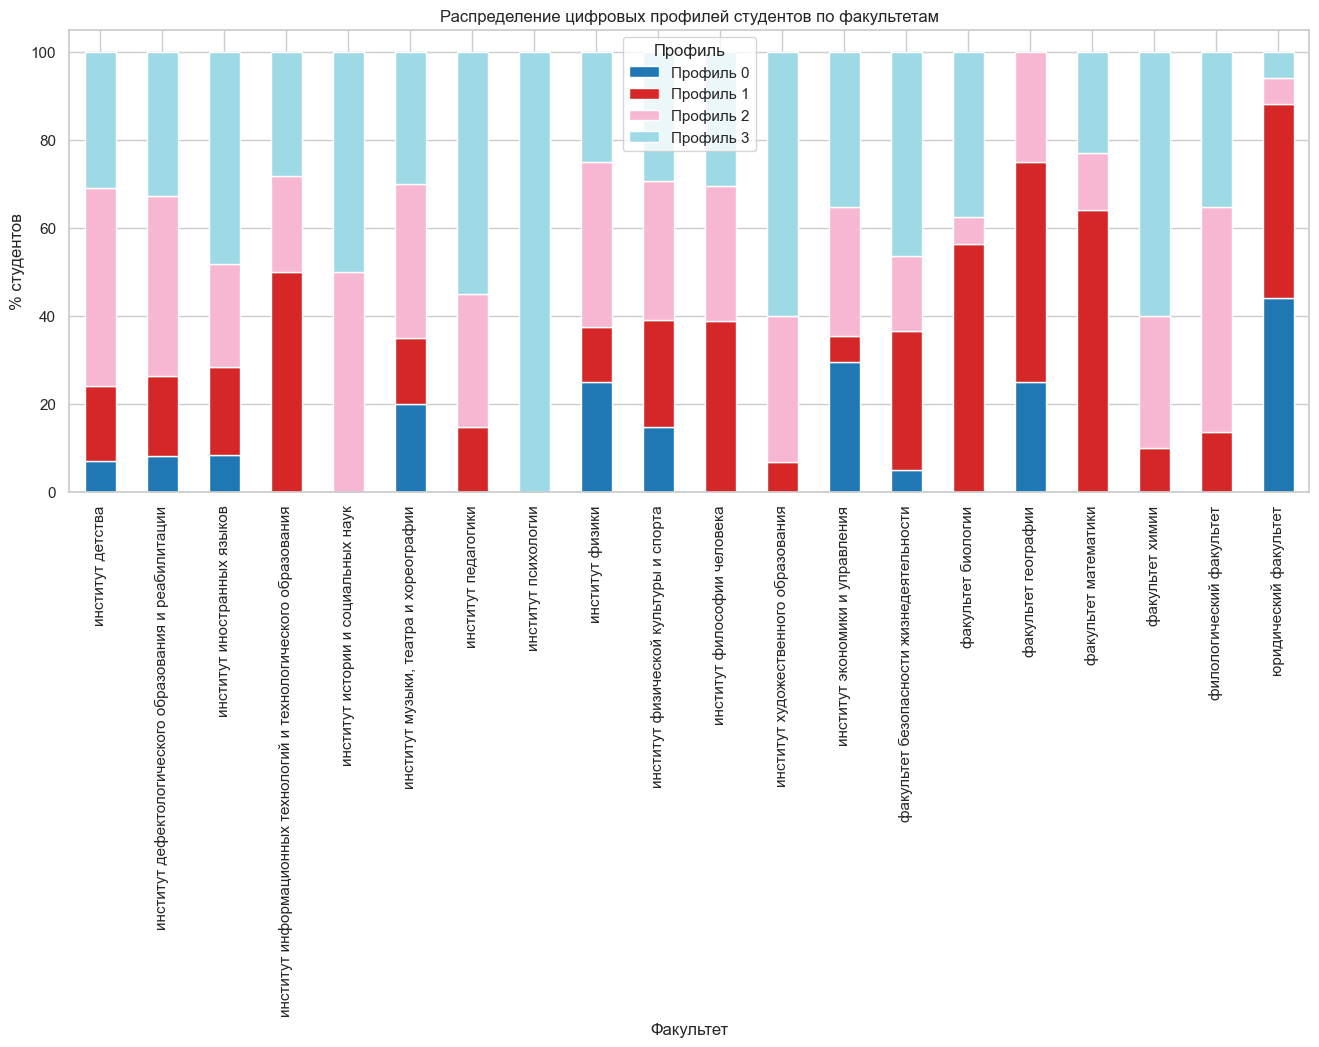

In [69]:
# === Анализ распределения профилей по факультетам ===

print("[2] Подготовка данных по факультетам...")
if "Факультет" not in df.columns:
    raise ValueError("В таблице нет столбца 'Факультет'")
df = df.dropna(subset=["Факультет"])

# Группируем данные
faculty_profile_counts = df.groupby(["Факультет", "Профиль"]).size().unstack(fill_value=0)
faculty_profile_counts_pct = faculty_profile_counts.div(faculty_profile_counts.sum(axis=1), axis=0) * 100

print("[3] Визуализация распределения профилей по факультетам...")
plt.figure(figsize=(16, 8))
faculty_profile_counts_pct.plot(kind="bar", stacked=True, colormap="tab20", figsize=(16, 6))
plt.ylabel("% студентов")
plt.title("Распределение цифровых профилей студентов по факультетам")
plt.tight_layout()
plt.show()


10.3 Подготовка признаков для анализа профилей

In [70]:
# === Подготовка числовых признаков для анализа профилей ===

technical_cols = [
    "ID", "Кластер_AC", "Кластер_FCM", "UMAP1", "UMAP2", "Факультет", "Профиль"
]
feature_cols = [
    col for col in df.columns
    if col not in technical_cols and pd.api.types.is_numeric_dtype(df[col])
]

if not feature_cols:
    print("[!] Нет числовых признаков для построения radar plot.")
else:
    print(f"[INFO] Для анализа используются признаки: {feature_cols}")


[INFO] Для анализа используются признаки: ['Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)', 'Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?', 'Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)', 'Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?', 'Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?', 'Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?', 'Были ли для каждого Практического задания разработаны и опубликованы критерии оценивания?', 'Необходимы ли для каждого Практического задания критерии оценивания?', 'Был ли встроенный электронный журна

10.4 Radar plot по TOP-N различающих признаков

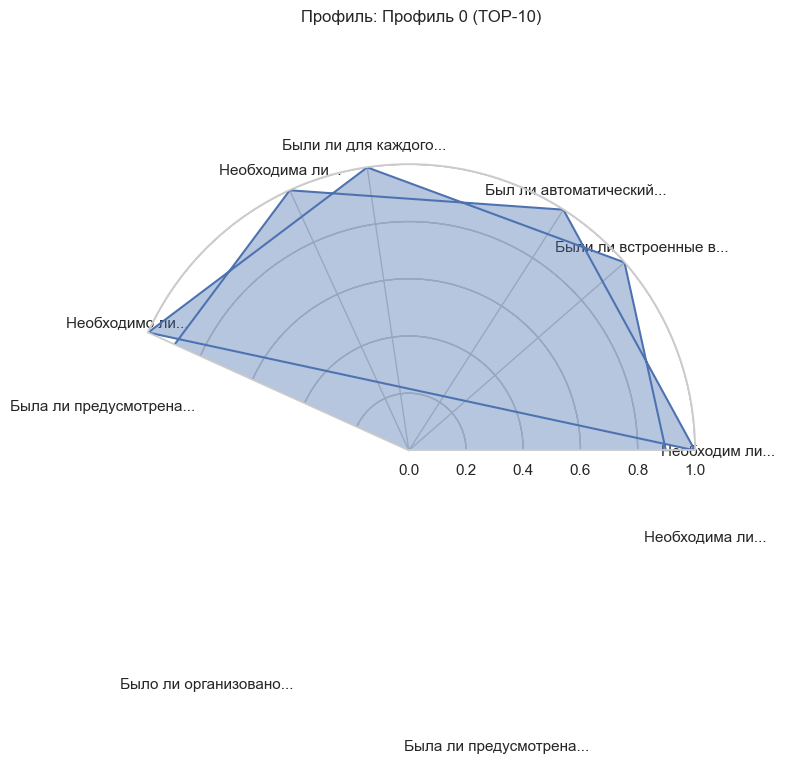

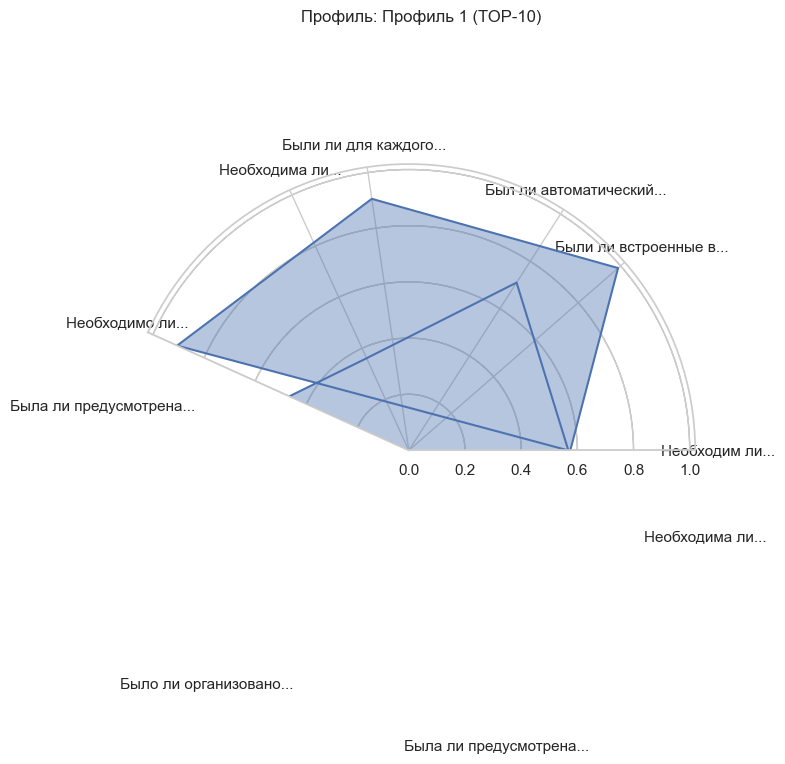

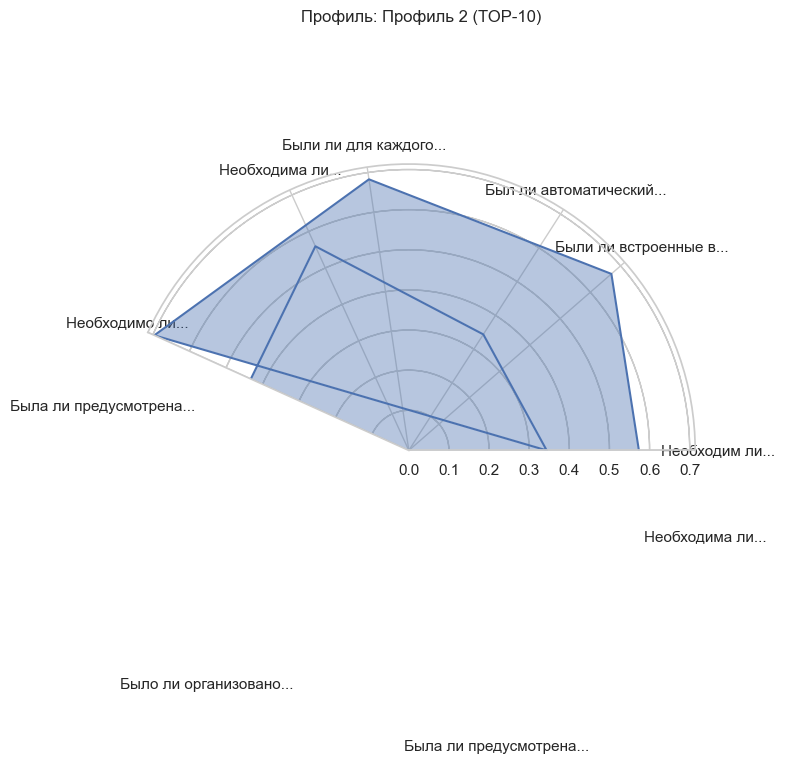

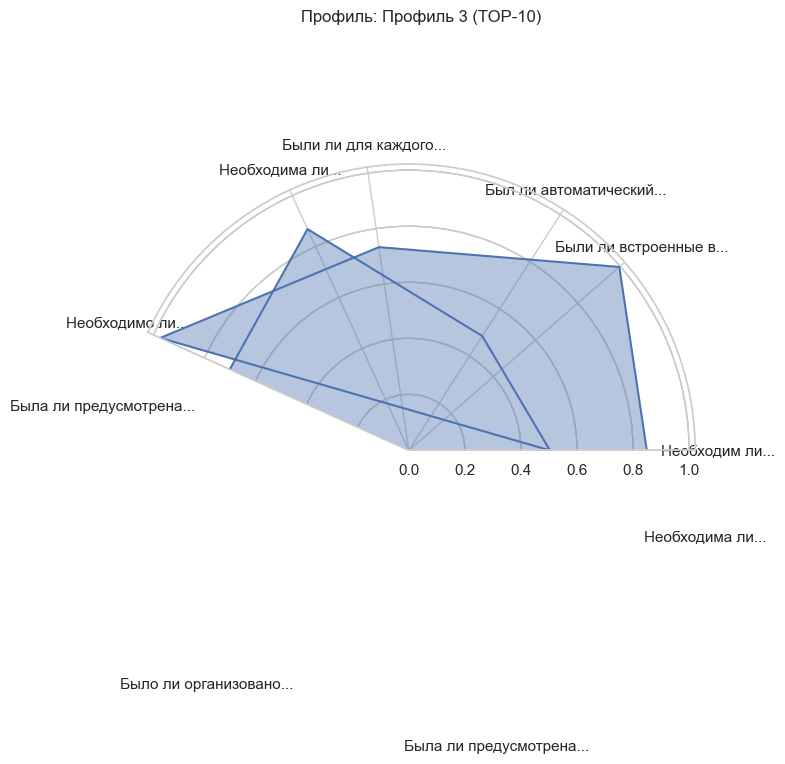

In [71]:
# === Построение radar plot по TOP-N различающих признаков ===

def short_label(label, max_len=25):
    import textwrap
    label = str(label)
    return textwrap.shorten(label, width=max_len, placeholder="...")

if feature_cols:
    avg_by_cluster = df.groupby("Профиль")[feature_cols].mean().T

    N = 10  # число признаков на графике
    avg_diff = avg_by_cluster.max(axis=1) - avg_by_cluster.min(axis=1)
    top_features = avg_diff.sort_values(ascending=False).head(N).index.tolist()
    labels = top_features
    angles = list(range(len(labels))) + [0]

    for profile in avg_by_cluster.columns:
        series = avg_by_cluster.loc[labels, profile].dropna()
        if series.empty:
            continue
        values = series.tolist() + [series.iloc[0]]
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, polar=True)
        ax.plot(angles, values, label=profile)
        ax.fill(angles, values, alpha=0.4)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([short_label(l) for l in labels], fontsize=11, rotation=45)
        plt.title(f"Профиль: {profile} (TOP-{N})")
        plt.tight_layout()
        plt.show()


10.5 Автоматическая текстовая интерпретация профилей

In [72]:
# === Формирование текстовых описаний профилей ===

from IPython.display import Markdown, display

profile_col = "Профиль"
desc = []
profiles = df[profile_col].unique()

for profile in profiles:
    cluster_df = df[df[profile_col] == profile][feature_cols]
    total = len(cluster_df)
    means = cluster_df.mean().sort_values(ascending=False)
    desc.append(f"### Профиль: **{profile}**\n")
    desc.append(f"- Количество студентов: {total}")
    desc.append("**Средние значения признаков (топ-5):**")
    for feat, val in means.head(5).items():
        desc.append(f"  - {feat}: {val:.2f}")
    desc.append("**Особенности профиля:**")
    high_feats = means.head(3)
    low_feats = means.tail(2)
    high_text = ', '.join([f'"{feat}" ({val:.2f})' for feat, val in high_feats.items()])
    low_text = ', '.join([f'"{feat}" ({val:.2f})' for feat, val in low_feats.items()])
    desc.append(f"  - Отличается высокими значениями по: {high_text}.")
    desc.append(f"  - Низкие значения по: {low_text}.")
    desc.append("")  # пустая строка между кластерами

md = "# Автоматическая интерпретация кластеров студентов\n\n" + '\n'.join(desc)
display(Markdown(md))


# Автоматическая интерпретация кластеров студентов

### Профиль: **Профиль 2**

- Количество студентов: 227
**Средние значения признаков (топ-5):**
  - Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?: 0.95
  - Необходимы ли для каждого Практического задания критерии оценивания?: 0.93
  - Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?: 0.85
  - Были ли встроенны в электронный курс видеолекции?: 0.82
  - Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?: 0.82
**Особенности профиля:**
  - Отличается высокими значениями по: "Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?" (0.95), "Необходимы ли для каждого Практического задания критерии оценивания?" (0.93), "Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?" (0.85).
  - Низкие значения по: "Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?" (0.34), "Кластер_Gower" (0.01).

### Профиль: **Профиль 3**

- Количество студентов: 266
**Средние значения признаков (топ-5):**
  - Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?: 1.00
  - Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?: 1.00
  - Были ли встроенные в электронный курс тесты по материалом видео лекций?: 1.00
  - Были ли встроенны в электронный курс видеолекции?: 0.99
  - Необходимо ли организовывать взаимодействие с преподавателями посредством мессенджеров?: 0.97
**Особенности профиля:**
  - Отличается высокими значениями по: "Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?" (1.00), "Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?" (1.00), "Были ли встроенные в электронный курс тесты по материалом видео лекций?" (1.00).
  - Низкие значения по: "Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)" (0.48), "Кластер_Gower" (0.00).

### Профиль: **Профиль 1**

- Количество студентов: 169
**Средние значения признаков (топ-5):**
  - Были ли встроенные в электронный курс тесты по материалом видео лекций?: 0.99
  - Были ли встроенны в электронный курс видеолекции?: 0.99
  - Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?: 0.98
  - Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить): 0.96
  - Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?: 0.95
**Особенности профиля:**
  - Отличается высокими значениями по: "Были ли встроенные в электронный курс тесты по материалом видео лекций?" (0.99), "Были ли встроенны в электронный курс видеолекции?" (0.99), "Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?" (0.98).
  - Низкие значения по: "Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?" (0.36), "Кластер_Gower" (0.00).

### Профиль: **Профиль 0**

- Количество студентов: 49
**Средние значения признаков (топ-5):**
  - Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить): 1.00
  - Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?: 1.00
  - Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов): 1.00
  - Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?: 1.00
  - Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?: 1.00
**Особенности профиля:**
  - Отличается высокими значениями по: "Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)" (1.00), "Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?" (1.00), "Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)" (1.00).
  - Низкие значения по: "Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?" (0.98), "Кластер_Gower" (0.00).


Пояснения:
Построены stacked barplot и radar plot по каждому профилю, отражающие уровень цифровизации на факультетах.
Сформированы автоматические описания для вставки в отчёт, презентацию или для быстрой аналитики.